<a id="01"></a>
# 1. Introducción

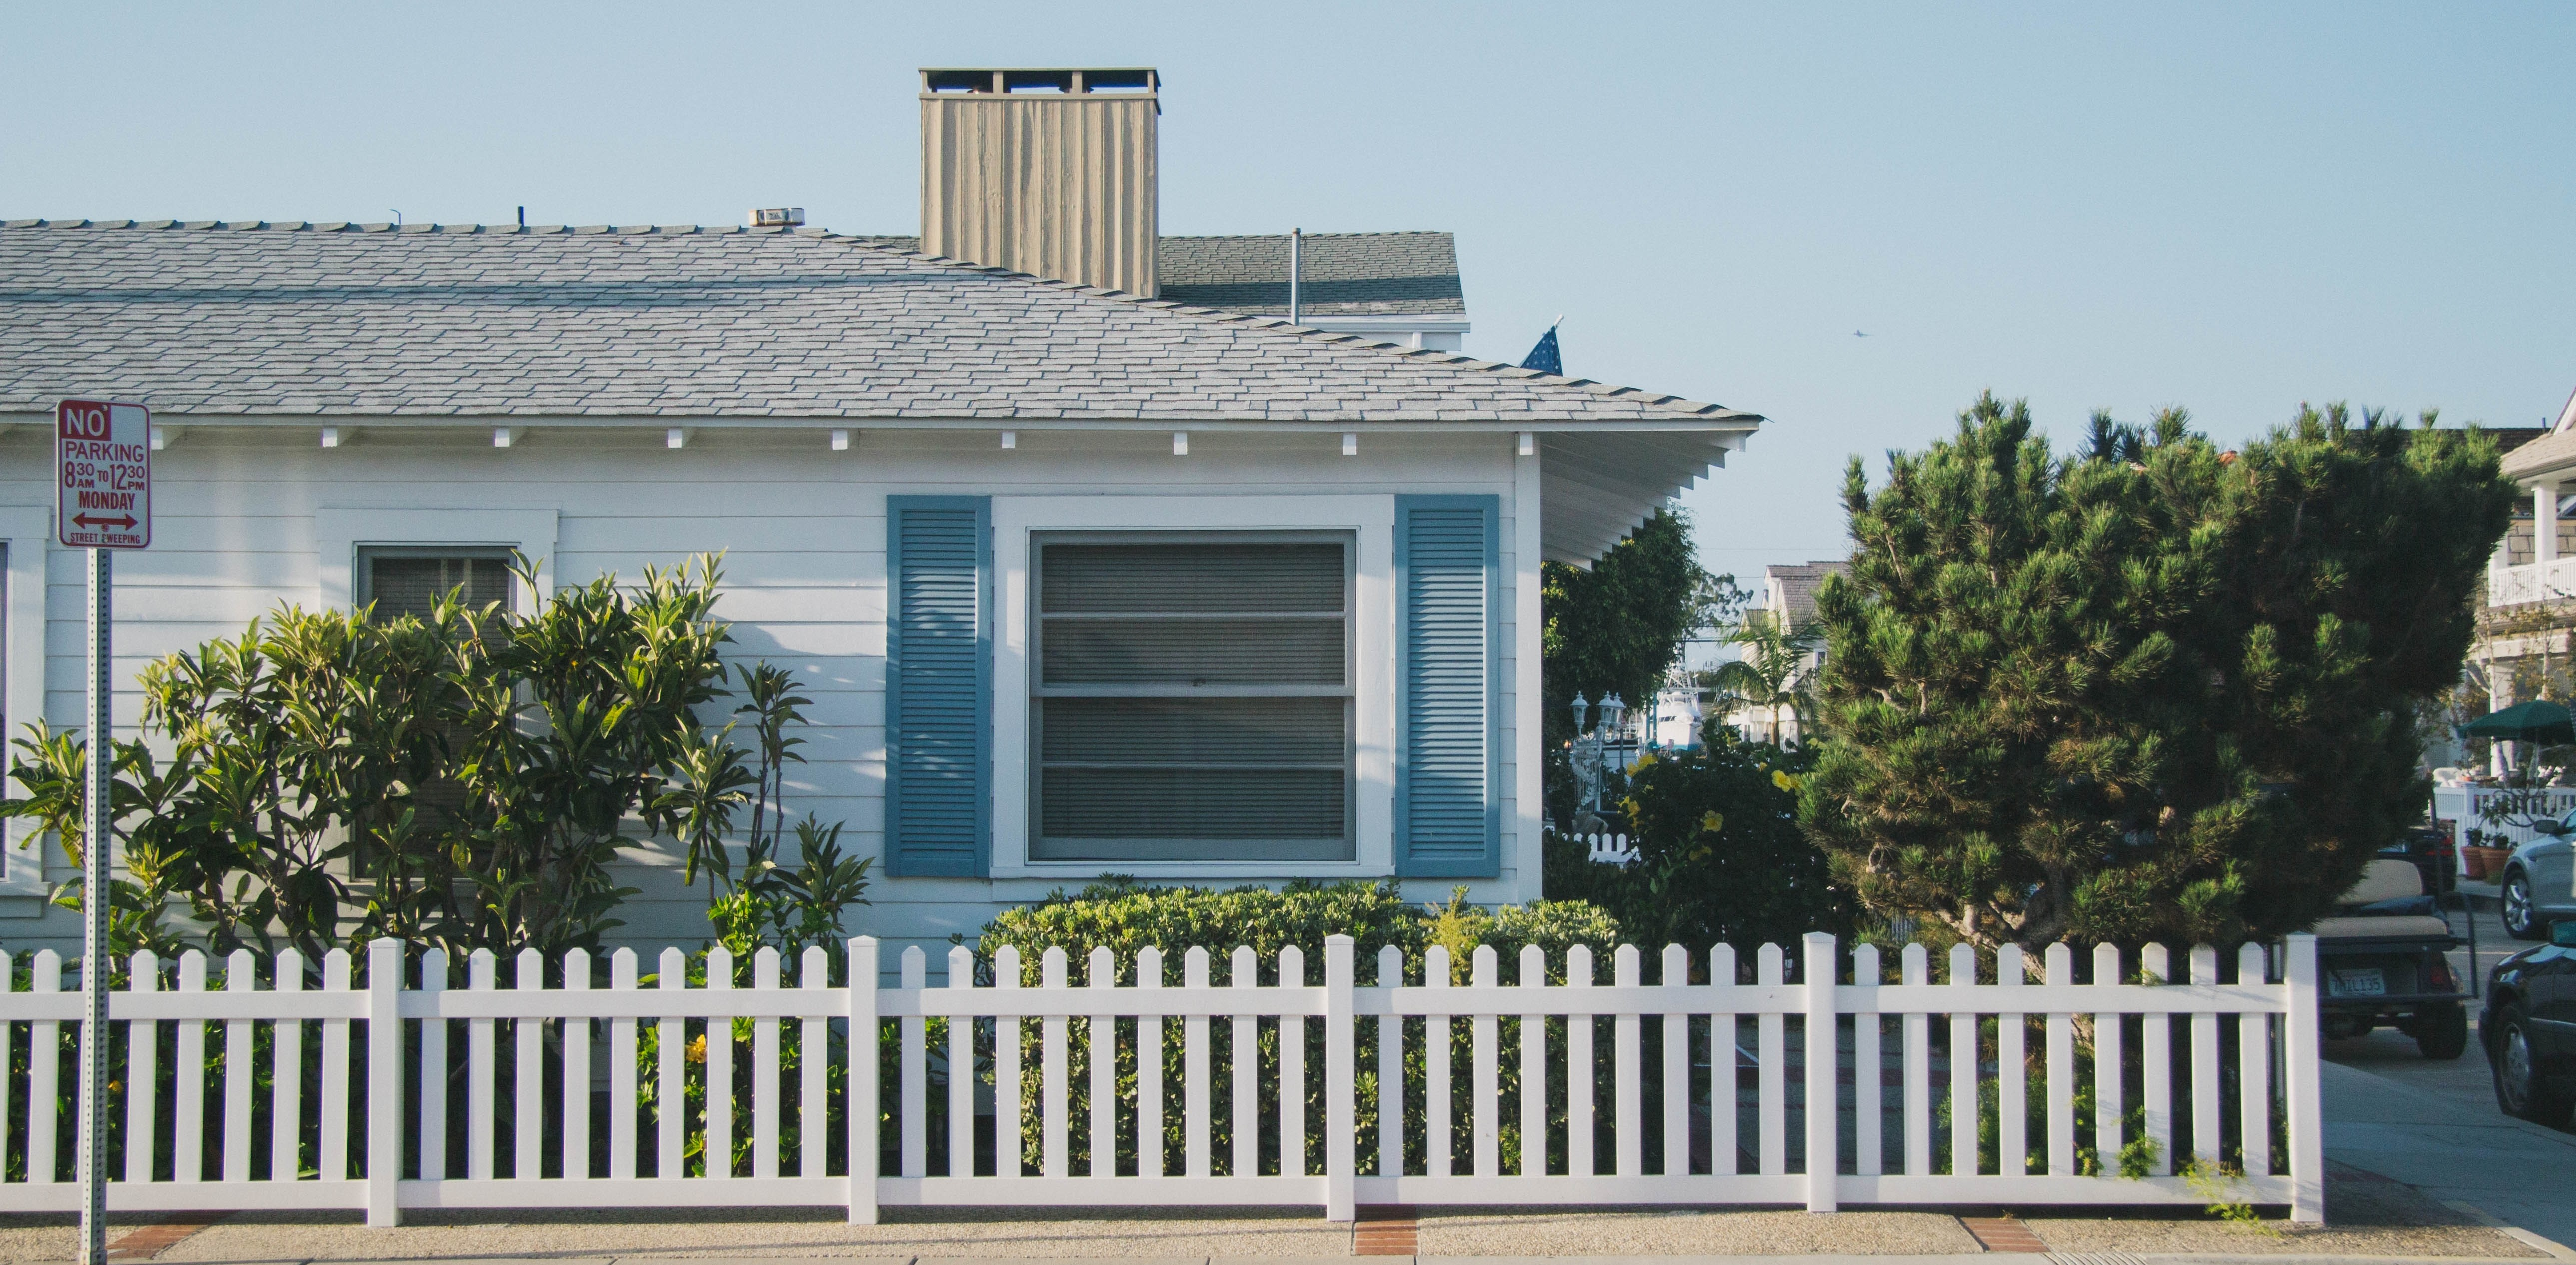

Los tasadores de propiedades de la inmobiliaria Properati hacen la valuación de manera tradicional, esto significa que el proceso es subjetivo al criterio del tasador. Actualmente el proceso lento, además de que se corre el riesgo de subvalorar o sobrevalorar una propiedad. Lo que a su vez genera la insatisfacción del cliente.

Este notebook tienen como objetivo desarrollar un módelo de Machine Learning que prediga el precio de las propiedades con un nivel aceptable de confianza. Los capítulos son los siguientes: <br>
       🏠 [Introducción](#01)  <br>
       🧹 [Preprocesamiento](#02) <br>
       📊 [Análisis exploratorio](#03)  <br>
       🚀 [Modelado](#04)  <br>
       🔍 [Resultados](#05)  <br>
       📣 [Conclusiones y próximos pasos](#06) <br>

## 1.1 Importaciones

Importa librerías a utilizar en el notebook

In [1]:
''' Data manipulation '''
import numpy as np
import pandas as pd
from scipy import stats


''' Visualizations '''
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import ipywidgets as widgets
from pandas_profiling import ProfileReport


''' Machine Learning '''
# Outlier detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# Scaling and tranformations
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.preprocessing import PolynomialFeatures

# Encoding
from sklearn.preprocessing import OneHotEncoder

# Modeling
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Selection
from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 1.2 Configuración de estilo

Creamos la paleta de colores de los gráficos que vamos a usar

In [3]:
blue = '#146EF5'
red = '#ED3767'
amber = '#F5B14C'
mint = '#17BED1'
purple = '#815ADB'
pink = '#FF8FB8'

In [4]:
from matplotlib.colors import LinearSegmentedColormap

# Cualitative colormap
Palette = [blue, red, amber, mint, purple, pink]

# Sequential colormap
Blues = LinearSegmentedColormap.from_list("myBlues", ["white", blue])
Reds = LinearSegmentedColormap.from_list("myReds", ["white", red])
Ambers = LinearSegmentedColormap.from_list("myAmber", ["white", amber])

# Diverging colormap
BlueRed = LinearSegmentedColormap.from_list("myBlueRed", [red, "white", blue])

Define el estilo de los gráficos

In [5]:
params = {'axes.edgecolor': '0.9', 'axes.labelcolor': '0.4',
          'text.color': '0.3', 'xtick.color': '0.5', 'ytick.color': '0.5',
          'font.size': 16, 'axes.titlesize': 16, 'axes.labelsize': 12,
          'xtick.labelsize': 12, 'ytick.labelsize': 12,
          'figure.figsize': (9, 6), 'axes.spines.right': False, 'axes.spines.top': False}

sns.set(context='notebook', style='white', palette=Palette,
        font='Gadugi', rc=params)

<a id="02"></a>
# 2. Preprocesamiento

Empezamos importando el dataset que previamente descargamos de [Properati](https://www.properati.com.co/data/).

In [2]:
# Carga el dataset
data = pd.read_csv('data/Datos_Properati.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146660 entries, 0 to 146659
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   start_date       146660 non-null  object 
 1   end_date         146660 non-null  object 
 2   created_on       146660 non-null  object 
 3   lat              136735 non-null  float64
 4   lon              136701 non-null  float64
 5   l1               146660 non-null  object 
 6   l2               146660 non-null  object 
 7   l3               146660 non-null  object 
 8   rooms            146660 non-null  float64
 9   bedrooms         146660 non-null  float64
 10  bathrooms        140703 non-null  float64
 11  surface_total    126133 non-null  float64
 12  surface_covered  125046 non-null  float64
 13  price            146660 non-null  float64
 14  currency         146660 non-null  object 
 15  title            146660 non-null  object 
 16  description      146660 non-null  obje

In [7]:
data.head()

start_date    end_date  created_on        lat        lon         l1  \
0  2019-10-17  2019-12-23  2019-10-17 -34.605880 -58.384949  Argentina   
1  2019-10-17  2019-11-21  2019-10-17 -34.624056 -58.412110  Argentina   
2  2019-10-17  2019-11-01  2019-10-17 -34.593569 -58.427474  Argentina   
3  2019-10-17  2019-12-23  2019-10-17 -34.581294 -58.436754  Argentina   
4  2019-10-17  2020-03-11  2019-10-17 -34.914194 -57.938219  Argentina   

                       l2             l3  rooms  bedrooms  bathrooms  \
0         Capital Federal  San Cristobal    7.0       7.0        2.0   
1         Capital Federal          Boedo    2.0       1.0        2.0   
2         Capital Federal        Palermo    2.0       1.0        1.0   
3         Capital Federal        Palermo    2.0       1.0        1.0   
4  Bs.As. G.B.A. Zona Sur       La Plata    2.0       1.0        1.0   

   surface_total  surface_covered     price currency  \
0          140.0            140.0  153000.0      USD   
1           70.0             58.0  159000.0      USD   
2           45.0             45.0  125000.0      USD   
3           85.0             50.0  295000.0      USD   
4           50.0             35.0   40000.0      USD   

                                               title  \
0        ***Venta semipiso centro, ideal hostel*****   
1   Espectacular PH reciclado en Boedo sin expensas.   
2  Depto.tipo casa de 2 ambientes en Venta en Pal...   
3  COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...   
4  58 entre 1 y 2  Venta de departamento en ph.1 ...   

                                         description property_type  \
0  DESCRIPCION DE LA PROPIEDAD: Departamento de 1...  Departamento   
1   PH reciclado en Boedo a una cuadra de la plaz...            PH   
2  2 ambienets amplio , excelente estado , patio ...            PH   
3  HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...            PH   
4  58 entre 1 y 2  Venta de departamento en PH. P...            PH   

  operation_type  
0          Venta  
1          Venta  
2          Venta  
3          Venta  
4          Venta

In [8]:
# Checa el tamaño 
print('El dataset tiene {} instancias y {} columnas.'.format(data.shape[0], data.shape[1]))

El dataset tiene 146660 instancias y 19 columnas.


In [9]:
# Checa las columnas
data.columns

Index(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'currency', 'title', 'description', 'property_type',
       'operation_type'],
      dtype='object')

Las variables se pueden clasificar de la siguiente manera:

 - __Localización:__ `lat`, `lon`, `l1`, `l2`, `l3`.
 - __Espacio:__ `rooms`, `bedrooms`, `bathrooms`, `surface_total`, `surface_covered`.
 - __Edificio:__ `property_type`.
 - __Fechas de publicación:__ `start_date`, `end_date`, `created_on`.
 - __Detalles de publicación:__ `title`, `description`, `operation_type`.

Y, finalmente, nuestra variable objetivo: <font color=green>💸 __*price*__ 💸</font>, que deberá ser tranformada con base en `currency`, para tener todas las instancias en la misma moneda.


In [10]:
profile = ProfileReport(data, title='Pandas Profiling Report',
                        html={'style':{'full_width':True}})


profile.to_widgets()

## 2.1 Filtro preliminar

In [11]:
# Delvueve el tipo de dato de cada columna
data.dtypes

start_date          object
end_date            object
created_on          object
lat                float64
lon                float64
l1                  object
l2                  object
l3                  object
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price              float64
currency            object
title               object
description         object
property_type       object
operation_type      object
dtype: object

Empezemos por descartar las instancias duplicadas

In [12]:
print('Con duplicados:', data.shape[0])
data.drop_duplicates(inplace=True)
print('Sin duplicados:', data.shape[0])

Con duplicados: 146660
Sin duplicados: 144302


Verifiquemos que valores obtienen cada variable categórica del dataset.

In [13]:
# Ignoramos title y description por cada una es diferente, no queremos que esto explote.
columns = ['l1', 'l2', 'l3', 'currency', 'property_type', 'operation_type']
for col in columns:
    print(col,':\n', pd.unique(data[col]), '\n')

l1 :
 ['Argentina'] 

l2 :
 ['Capital Federal' 'Bs.As. G.B.A. Zona Sur' 'Bs.As. G.B.A. Zona Norte'
 'Bs.As. G.B.A. Zona Oeste'] 

l3 :
 ['San Cristobal' 'Boedo' 'Palermo' 'La Plata' 'Villa Crespo'
 'Parque Patricios' 'Villa Pueyrredón' 'Pilar' 'Tigre' 'Abasto' 'Flores'
 'Morón' 'Nuñez' 'Almagro' 'Belgrano' 'Floresta' 'Recoleta' 'Balvanera'
 'Caballito' 'Chacarita' 'San Telmo' 'Colegiales' 'La Matanza'
 'San Isidro' 'San Miguel' 'Villa Luro' 'Barrio Norte' 'Las Cañitas'
 'San Nicolás' 'Villa Urquiza' 'Vicente López' 'Parque Centenario'
 'General San Martín' 'Villa General Mitre' 'Lanús' 'Ituzaingó' 'Boca'
 'Once' 'Retiro' 'Monserrat' 'Avellaneda' 'San Fernando' 'Puerto Madero'
 'Villa Ortuzar' 'Parque Chacabuco' 'Centro / Microcentro'
 'Tres de Febrero' 'Liniers' 'Coghlan' 'Congreso' 'Paternal' 'Saavedra'
 'Villa Santa Rita' 'Barracas' 'Villa Lugano' 'Constitución' 'Mataderos'
 'Villa Devoto' 'Parque Avellaneda' 'Villa del Parque'
 'Esteban Echeverría' 'Lomas de Zamora' 'Almirante Brown

Como se puede observar, todas las publicaciones son de Argentina, y todas son ventas con los precios en dolares. Podremos ahora eliminar estas columnas, junto con las relativas a la publicación (fechas, título, descripción) que no serán utilizadas en este modelo.

In [14]:
col_to_drop = ['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1',
               'title', 'description', 'currency', 'operation_type']
data2 = data.drop(col_to_drop, axis=1)
data2.head()

l2             l3  rooms  bedrooms  bathrooms  \
0         Capital Federal  San Cristobal    7.0       7.0        2.0   
1         Capital Federal          Boedo    2.0       1.0        2.0   
2         Capital Federal        Palermo    2.0       1.0        1.0   
3         Capital Federal        Palermo    2.0       1.0        1.0   
4  Bs.As. G.B.A. Zona Sur       La Plata    2.0       1.0        1.0   

   surface_total  surface_covered     price property_type  
0          140.0            140.0  153000.0  Departamento  
1           70.0             58.0  159000.0            PH  
2           45.0             45.0  125000.0            PH  
3           85.0             50.0  295000.0            PH  
4           50.0             35.0   40000.0            PH

Ahora eliminaremos las filas que correspondan a un tipo de propiedad diferente a vivienda.

In [15]:
prop_types = ['Departamento', 'Casa', 'PH']
data3 = data2[data2['property_type'].isin(prop_types)]
print('Se eliminaron {} instancias.'.format(data2.shape[0] - data3.shape[0]))

Se eliminaron 3480 instancias.


El dataset contiene las publicaciones de toda la zona metropolitana de Buenos Aires. Intiuitivamente,las viviendas dentro de la propia ciudad deberían ser más costosas en terminos generales. Para probar est pequeña hipotesis, hallaremos las estadisticos descriptivos discriminando por zona.

In [16]:
l2 = ['Capital Federal', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Sur', 'Bs.As. G.B.A. Zona Oeste']

for loc in l2:
    print(loc)
    display(data3[data3.l2 == loc].describe().apply(lambda s: s.apply(lambda x: format(x, '.2f'))))

Capital Federal


rooms  bedrooms bathrooms surface_total surface_covered        price
count  89874.00  89874.00  87727.00      81157.00        80850.00     89874.00
mean       2.97      1.96      1.56        112.89           95.17    258719.50
std        1.32      1.07      0.86        989.13          785.18    319076.16
min        1.00      0.00      1.00         10.00            1.00      6000.00
25%        2.00      1.00      1.00         49.00           44.00    120000.00
50%        3.00      2.00      1.00         71.00           63.00    175000.00
75%        4.00      3.00      2.00        111.00           96.00    278200.00
max       26.00     15.00     14.00     126062.00       126062.00  32434232.00

Bs.As. G.B.A. Zona Norte


rooms  bedrooms bathrooms surface_total surface_covered       price
count  23106.00  23106.00  22684.00      21404.00        21410.00    23106.00
mean       3.26      2.14      1.80        320.50          143.57   237642.48
std        1.46      1.12      0.98       2311.28         1171.39   206549.46
min        1.00      0.00      1.00         10.00            1.00    12322.00
25%        2.00      1.00      1.00         63.00           55.00   125000.00
50%        3.00      2.00      2.00         98.00           77.00   185000.00
75%        4.00      3.00      2.00        200.00          126.00   285000.00
max       35.00     13.00     14.00     169000.00        91970.00  3600000.00

Bs.As. G.B.A. Zona Sur


rooms  bedrooms bathrooms surface_total surface_covered       price
count  15781.00  15781.00  14949.00      11131.00        11151.00    15781.00
mean       3.51      1.91      1.58        351.05          158.72   179875.23
std        1.59      1.36      0.89       1781.37         1329.40   182740.24
min        1.00      0.00      1.00         12.00            1.00    13000.00
25%        2.00      1.00      1.00         60.00           53.00    87000.00
50%        3.00      2.00      1.00        120.00           84.00   130000.00
75%        4.00      3.00      2.00        300.00          150.00   206000.00
max       30.00     13.00     14.00      99590.00        90183.00  7716649.00

Bs.As. G.B.A. Zona Oeste


rooms  bedrooms bathrooms surface_total surface_covered        price
count  12061.00  12061.00  11280.00       8761.00         8765.00     12061.00
mean       3.26      2.17      1.50        293.48          143.53    151171.51
std        1.43      1.21      0.85       1746.26          821.71    235913.41
min        1.00      0.00      1.00         10.00            1.00      7500.00
25%        2.00      1.00      1.00         52.00           45.00     78000.00
50%        3.00      2.00      1.00        106.00           77.00    110000.00
75%        4.00      3.00      2.00        260.00          136.00    170000.00
max       24.00     11.00      8.00     118984.00        34713.00  11111111.00

Como vemos, las viviendas de la Capital Federal tienden a ser pequeñas y costosas, en contraparte a la Zona Norte, Zona Oeste y especialmente a la Zona Sur. Quiza esta variable categorica sea útil para el modelo de Machine Learning.

## 2.2 Valores atípicos

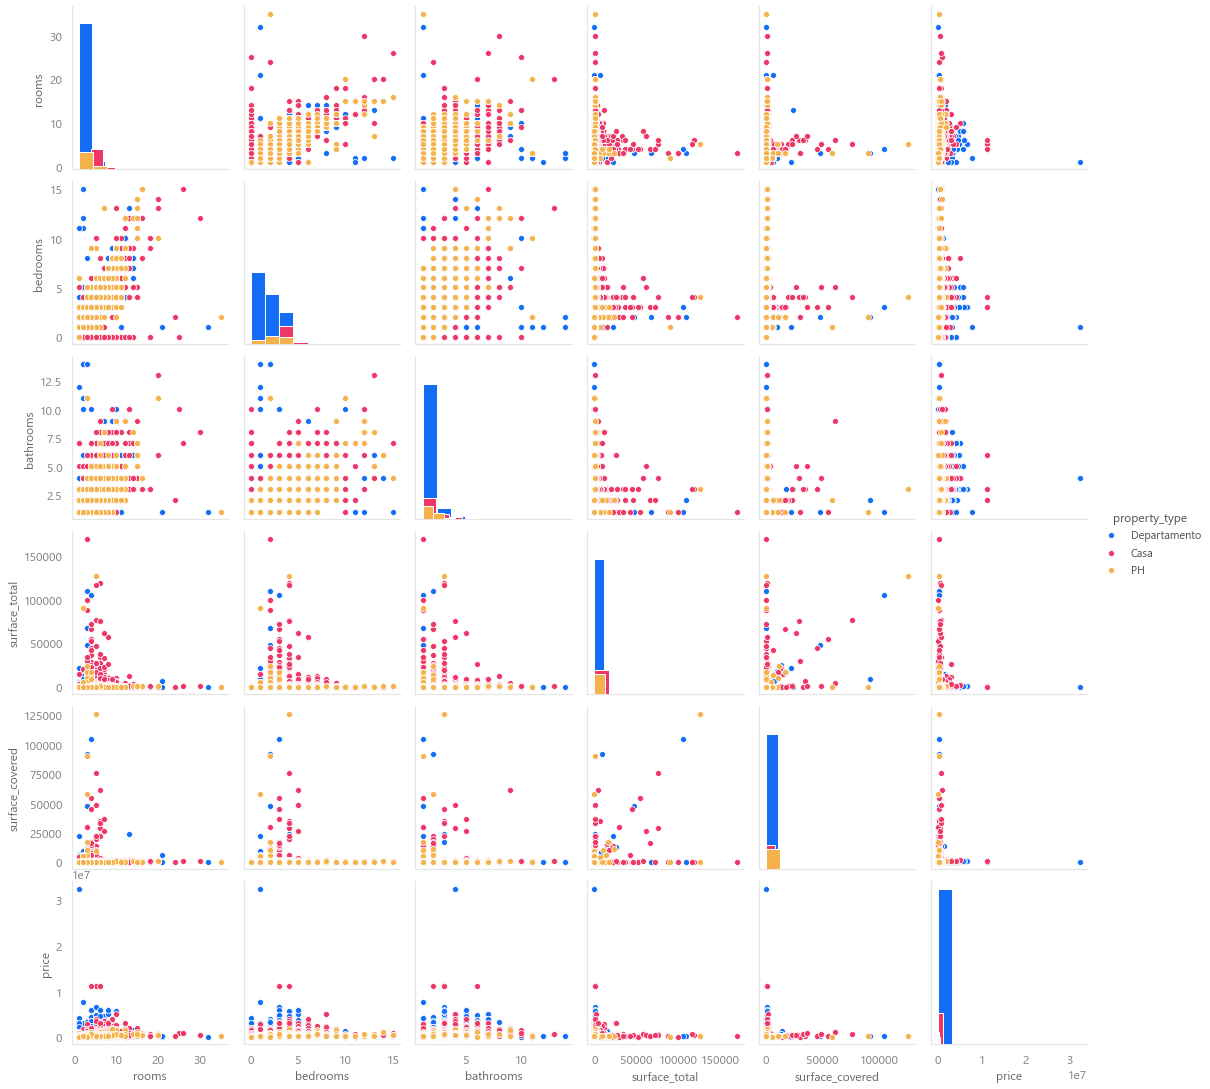

In [17]:
sns.pairplot(data3, hue='property_type', diag_kind='hist',
             hue_order=['Departamento', 'Casa', 'PH'])

Los valores atípicos no permiten extraer mucha información del pairplot. Por ello, antes de continuar a la exploración debemos hacer algo de preprocesamiento, de forma que se puedan sacar conclusiones válidas de la data. 

Para detectar y eliminar los valores atípicos nos serviremos de métodos univariados como IQR o tres sigmas, y de otros más sofisticados que utilizan ML.

In [18]:
# Hacemos diferentes copias del dataset original
data_out_iqr = data3.copy()
data_out_3s = data3.copy()
data_out_if = data3.copy()
data_out_lof = data3.copy()

### 2.2.1 IQR 

In [19]:
def outlier_detector_iqr(data):
    """
    Aplica el método IQR a todas las variables númericas del dataset.
    ________________________________________________________________________________
    
    @ Librerías requeridas
    import pandas as pd;
    import numpy as np;

    @ Input
    data: dataframe original

    @ Return
    y_pred: pandas Series de Pandas conteniendo las etiquetas sobre los outliers
            donde 1 son inlier y -1 los outliers
    """
    
    X = data.copy()
    numeric_cols = X.select_dtypes(include='number').columns.tolist()
    X['outliers'] = np.zeros(X.shape[0]).astype(int)
    
    for i, col in enumerate(numeric_cols):
        
        q1, q3 = np.nanpercentile(X[col], [25, 75])
        iqr = q3-q1
        lim_inf = q1-1.5*iqr
        lim_sup = q3+1.5*iqr
        
        outliers = []
        outliers = [0 if not (x < lim_inf or x > lim_sup) else 1 for x in X[col]] # 0=inlier, 1=outlier
        
        X['outliers'] += outliers
        
    y_pred = X['outliers'].where(X['outliers'] == 0, 1).map({0: 1, 1: -1}) # 1=inlier, -1=outlier
    return y_pred

In [20]:
# Detectamos con IQR
y_pred = outlier_detector_iqr(data_out_iqr)

# Creamos una columna con la etiqeuta predicha
data_out_iqr['outliers'] = y_pred
data_out_iqr['outliers'] = data_out_iqr['outliers'].map({-1: 'Outlier', 1: 'Inlier'})

# Imprimimos la cantidad de oputliers identificados
Inliers = data_out_iqr['outliers'].value_counts()[0]
Outliers = data_out_iqr['outliers'].value_counts()[1]
print('Se identifican {:,} instancias como outliers,'.format(Outliers), end=' ')
print('lo que representa el {:.2%} del dataset.'.format(Outliers/(Inliers+Outliers)))

Se identifican 22,485 instancias como outliers, lo que representa el 15.97% del dataset.


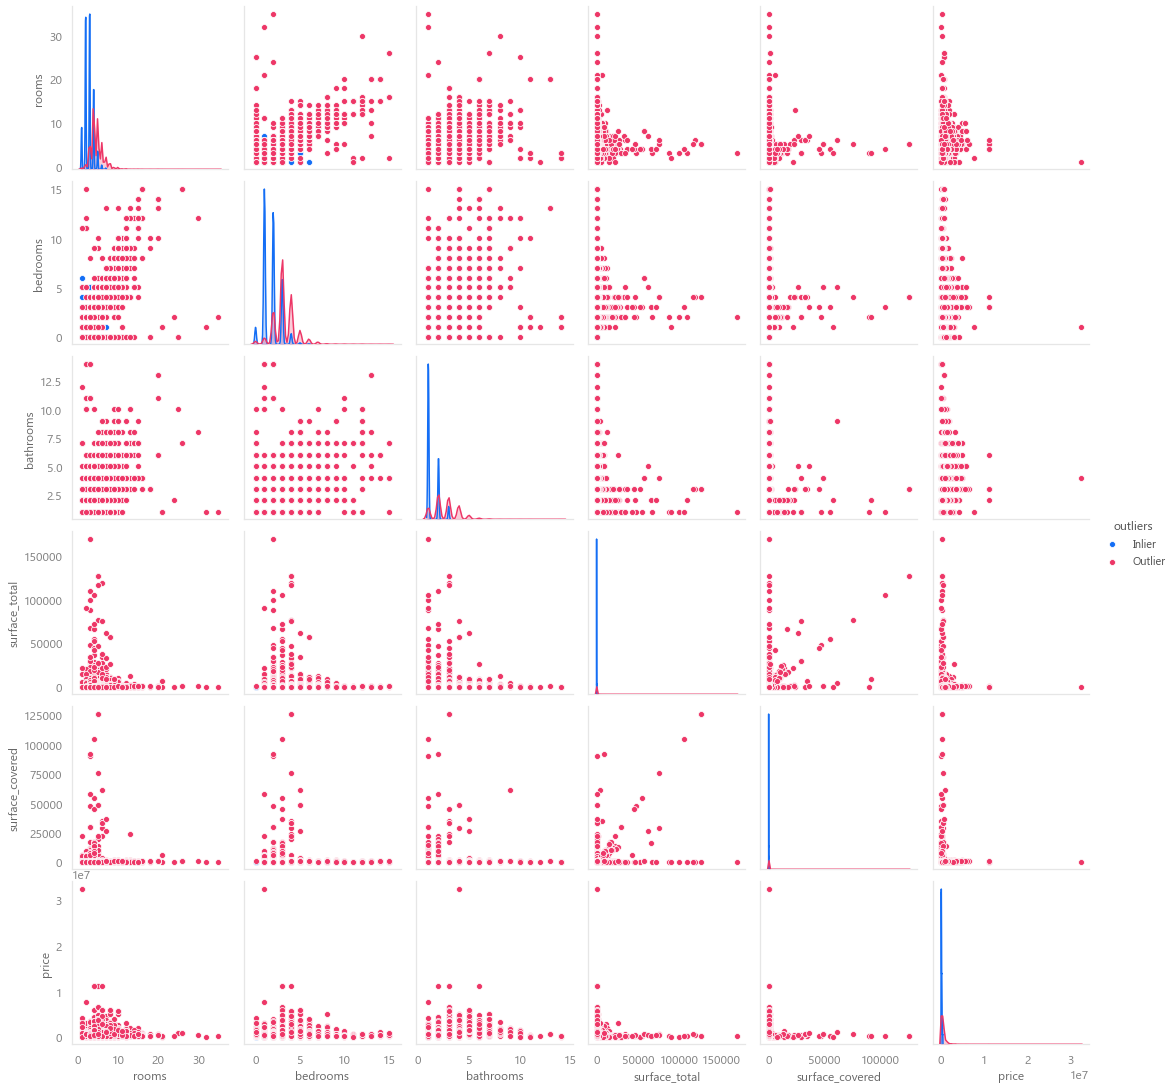

In [21]:
# Visualizamos 
sns.pairplot(data_out_iqr, hue='outliers', hue_order=['Inlier', 'Outlier'])

In [22]:
# Verifiquemos que los valores nulos no hayan sido
# clasificados como outliers
data_out_iqr.query("outliers == 'Inlier'").isnull().sum().sort_values(ascending=False)

surface_covered    17180
surface_total      16925
bathrooms           3720
outliers               0
property_type          0
price                  0
bedrooms               0
rooms                  0
l3                     0
l2                     0
dtype: int64

### 2.2.2 Tres sigmas (3σ)

In [23]:
def outlier_detector_3s(data):
    """
    Aplica el método de los tres sigmas a todas las variables númericas del dataset.
    ________________________________________________________________________________
    
    @ Librerías requeridas
    import pandas as pd;
    import numpy as np;

    @ Input
    data: dataframe original

    @ Return
    y_pred: pandas Series de Pandas conteniendo las etiquetas sobre los outliers
            donde 1 son inlier y -1 los outliers
    """
    
    X = data.copy()
    numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
    X['outliers'] = np.zeros(X.shape[0]).astype(int)
    
    for i, col in enumerate(numeric_cols):
        
        mediana = X[col].median()
        desviacion = X[col].std()
        lim_inf = float(mediana - 3*desviacion)
        lim_sup = float(mediana + 3*desviacion)
        
        outliers = []
        outliers = [0 if not (x < lim_inf or x > lim_sup) else 1 for x in X[col]] # 0=inlier, 1=outlier
        
        X['outliers'] += outliers
        
    y_pred = X['outliers'].where(X['outliers'] == 0, 1).map({0: 1, 1: -1}) # 1=inlier, -1=outlier
    return y_pred

In [24]:
# Detectamos con 3 Sigmas
y_pred = outlier_detector_3s(data_out_3s)

# Creamos una columna con la etiqeuta predicha
data_out_3s['outliers'] = y_pred
data_out_3s['outliers'] = data_out_3s['outliers'].map({-1: 'Outlier', 1: 'Inlier'})

# Imprimimos la cantidad de oputliers identificados
Inliers = data_out_3s['outliers'].value_counts()[0]
Outliers = data_out_3s['outliers'].value_counts()[1]
print('Se identifican {:,} instancias como outliers,'.format(Outliers), end=' ')
print('lo que representa el {:.2%} del dataset.'.format(Outliers/(Inliers+Outliers)))

Se identifican 7,960 instancias como outliers, lo que representa el 5.65% del dataset.


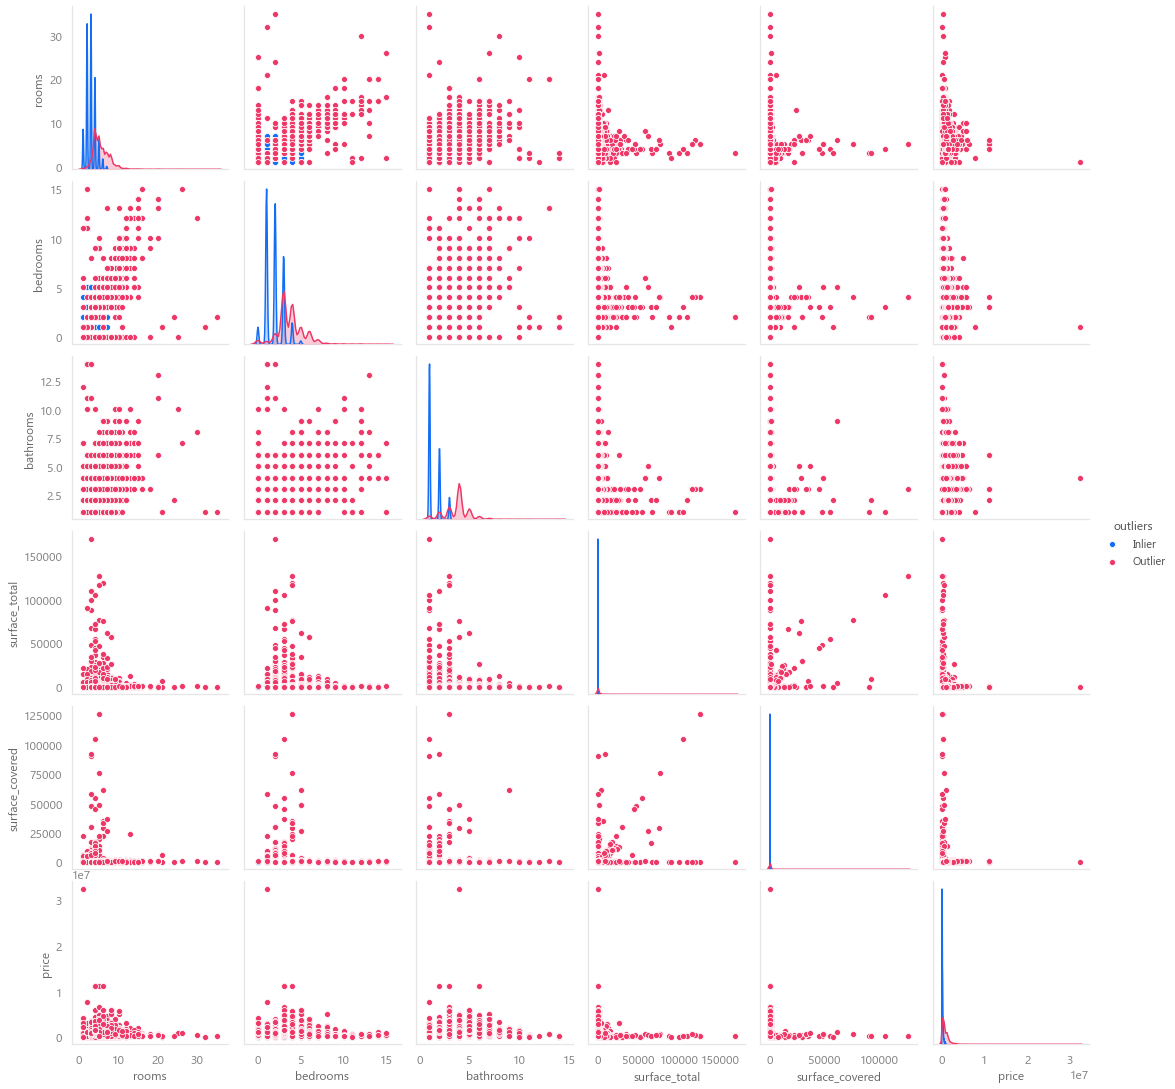

In [25]:
# Visualizamos 
sns.pairplot(data_out_3s, hue='outliers', hue_order=['Inlier', 'Outlier'])

In [26]:
data_out_3s.query("outliers == 'Inlier'").isnull().sum().sort_values(ascending=False)

surface_covered    17620
surface_total      17350
bathrooms           4068
outliers               0
property_type          0
price                  0
bedrooms               0
rooms                  0
l3                     0
l2                     0
dtype: int64

### 2.2.3 Isolation Forest

In [27]:
X = data_out_if.copy()
X = X.fillna(X.mean())

number_cols = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']

# Escalamos los datos
transformer = RobustScaler().fit(X[number_cols])
X[number_cols] = transformer.transform(X[number_cols])

# Detectamos con Isolation Forest
numeric_cols = X.select_dtypes(include='number').columns.tolist()
iforest = IsolationForest(random_state=100)
iforest.fit(X[numeric_cols])
y_pred = iforest.predict(X[numeric_cols]) # 1=inlier, -1=outlier

# Creamos una columna con la etiqeuta predicha
data_out_if['outliers'] = y_pred
data_out_if['outliers'] = data_out_if['outliers'].map({-1: 'Outlier', 1: 'Inlier'})

# Imprimimos la cantidad de oputliers identificados
Inliers = data_out_if['outliers'].value_counts()[0]
Outliers = data_out_if['outliers'].value_counts()[1]
print('Se identifican {:,} instancias como outliers,'.format(Outliers), end=' ')
print('lo que representa el {:.2%} del dataset.'.format(Outliers/(Inliers+Outliers)))

Se identifican 16,520 instancias como outliers, lo que representa el 11.73% del dataset.


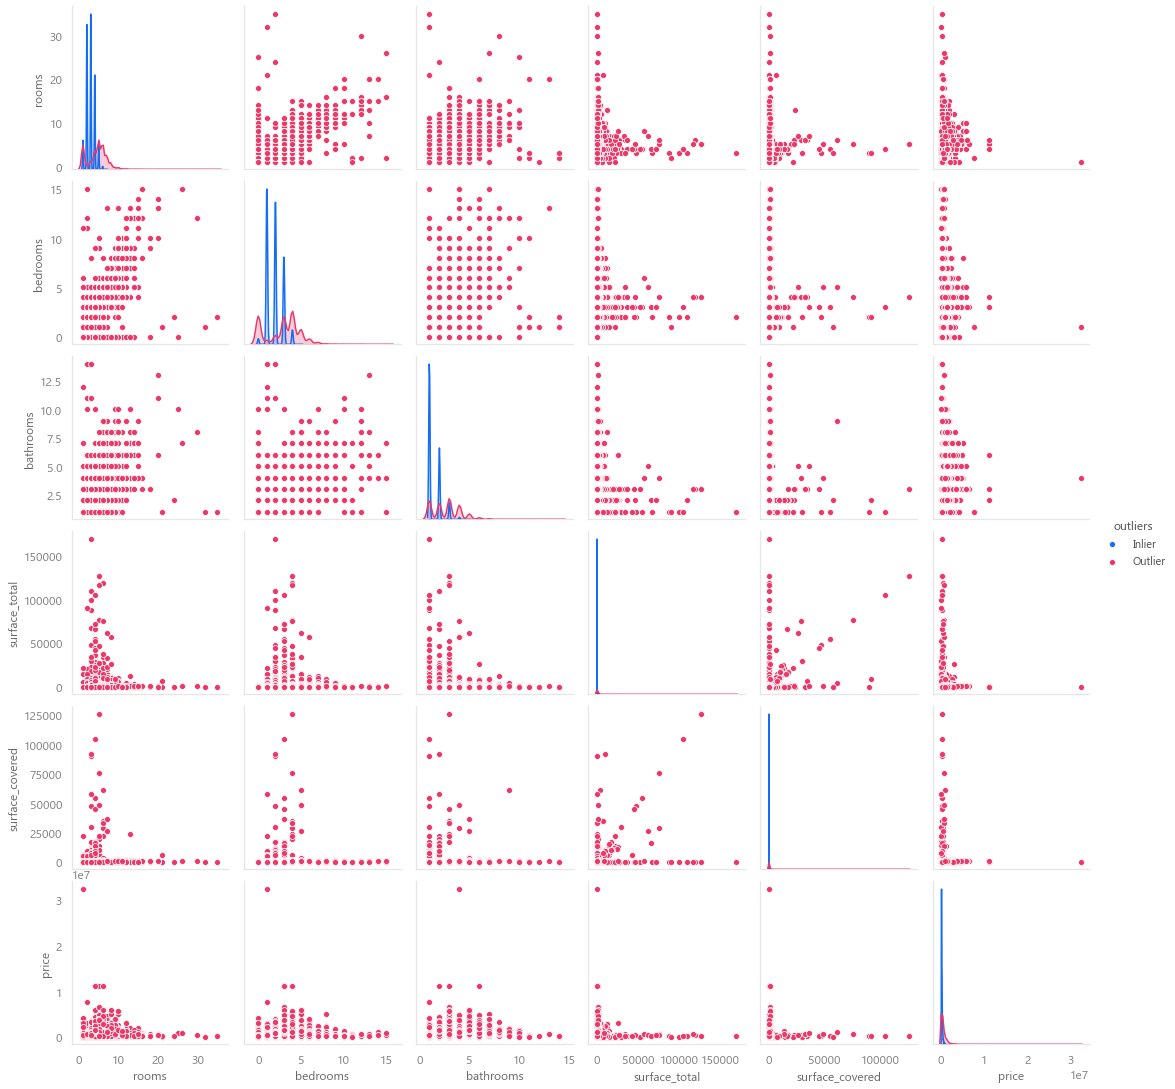

In [28]:
sns.pairplot(data_out_if, hue='outliers', hue_order=['Inlier', 'Outlier'])

In [29]:
data_out_if.query("outliers == 'Inlier'").isnull().sum().sort_values(ascending=False)

surface_covered    14651
surface_total      14389
bathrooms           3229
outliers               0
property_type          0
price                  0
bedrooms               0
rooms                  0
l3                     0
l2                     0
dtype: int64

### 2.2.4 Local Outlier Factor

In [30]:
X = data_out_lof.copy()
X = X.fillna(X.mean())

number_cols = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']

# Escalamos los datos
transformer = RobustScaler().fit(X[number_cols])
X[number_cols] = transformer.transform(X[number_cols])


# Entrenamos y predecimos
numeric_cols = X.select_dtypes(include='number').columns.tolist()
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = lof.fit_predict(X[numeric_cols])

# Creamos una columna con la etiqeuta predicha
data_out_lof['outliers'] = y_pred
data_out_lof['outliers'] = data_out_lof['outliers'].map({-1: 'Outlier', 1: 'Inlier'})

# Imprimimos la cantidad de oputliers identificados
Inliers = data_out_lof['outliers'].value_counts()[0]
Outliers = data_out_lof['outliers'].value_counts()[1]
print('Se identifican {:,} instancias como outliers,'.format(Outliers), end=' ')
print('lo que representa el {:.2%} del dataset.'.format(Outliers/(Inliers+Outliers)))

Se identifican 14,082 instancias como outliers, lo que representa el 10.00% del dataset.


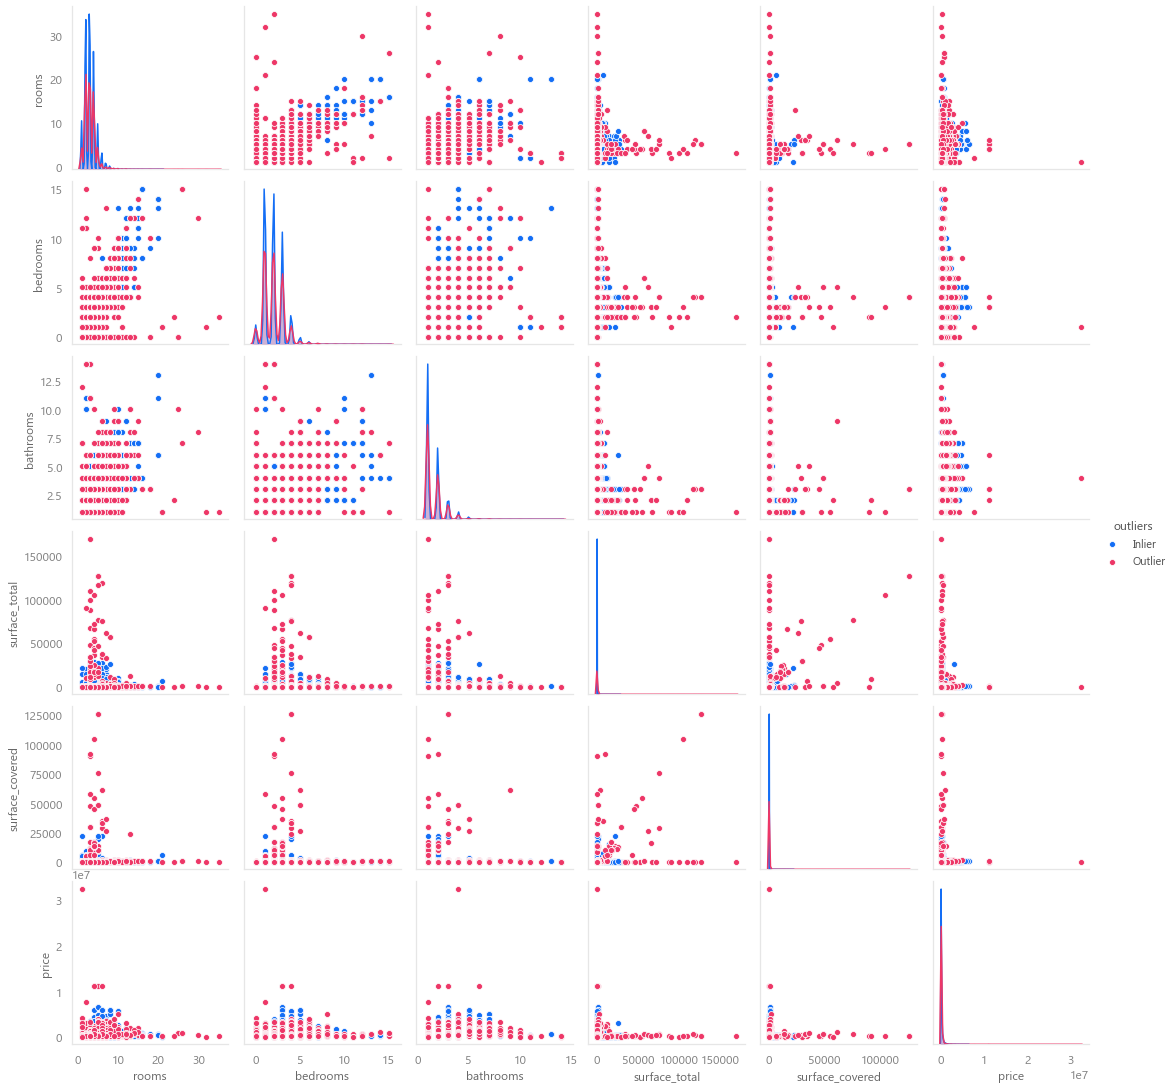

In [31]:
sns.pairplot(data_out_lof, hue='outliers', hue_order=['Inlier', 'Outlier'])

In [32]:
data_out_lof.query("outliers == 'Inlier'").isnull().sum().sort_values(ascending=False)

surface_covered    15909
surface_total      15693
bathrooms           3606
outliers               0
property_type          0
price                  0
bedrooms               0
rooms                  0
l3                     0
l2                     0
dtype: int64

### 2.2.5 Comparativa de métodos

In [33]:
df_outliers = [('IQR', data_out_iqr),
               ('3 sigmas', data_out_3s),
               ('Isolation Forest', data_out_if),
               ('Local Outlier Factor', data_out_lof)]


print('Original')
display(data3.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))))

for name, df in df_outliers:
    print(name)
    df = df.query("outliers != 'Outlier'")
    df = df.drop('outliers', axis=1)
    display(df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))))

Original


rooms bedrooms bathrooms surface_total surface_covered        price
count   140822   140822    136640        122453          122176       140822
mean   3.10001  2.00143   1.59679       183.745         112.921       237214
std    1.39717  1.13166  0.885971        1448.7         926.699       285975
min          1        0         1            10               1         6000
25%          2        1         1            52              47       112000
50%          3        2         1            78              68       165000
75%          4        3         2           138             108       263714
max         35       15        14        169000          126062  3.24342e+07

IQR


rooms  bedrooms bathrooms surface_total surface_covered    price
count   118337    118337    114617        101412          101157   118337
mean   2.77733   1.76094   1.37964       80.8712         67.9203   174980
std    1.05542  0.924752  0.589334       45.0753         32.2757  92058.1
min          1         0         1            10               1     6000
25%          2         1         1            49              44   105000
50%          3         2         1            68              60   150000
75%          3         2         2           100              83   225000
max          7         6         3           267             199   491000

3 sigmas


rooms  bedrooms bathrooms surface_total surface_covered     price
count   132862    132862    128794        115512          115242    132862
mean   2.94853   1.89167   1.46288       124.191         82.7861    199424
std    1.17188  0.992311  0.651062       191.453         65.7083    137387
min          1         0         1            10               1      6000
25%          2         1         1            51              46    110000
50%          3         2         1            74              65    160000
75%          4         3         2           122              98    245000
max          7         5         3          4424            2773  1.02e+06

Isolation Forest


rooms  bedrooms bathrooms surface_total surface_covered        price
count   124302    124302    121073        109913          109651       124302
mean   2.89049   1.87652   1.45019       99.4734         74.7966       193174
std    1.02525  0.883126   0.66178        92.663         40.5987       123316
min          1         0         1            10               1         6000
25%          2         1         1            50              45       110000
50%          3         2         1            72              63       159000
75%          4         3         2           113              92       240000
max          7         5         5          1800             350  1.10538e+06

Local Outlier Factor


rooms bedrooms bathrooms surface_total surface_covered    price
count   126740   126740    123134        111047          110831   126740
mean   3.09875   2.0007   1.59504       165.545         101.113   237789
std    1.38511  1.12241  0.879275       577.327         263.873   268404
min          1        0         1            13               1     6000
25%          2        1         1            52              47   111400
50%          3        2         1            78              68   165000
75%          4        3         2           138             108   264000
max         21       15        14         28578           22448  6.5e+06

Decartamos 3Sigmas por ser demasiado permisivo y a Local Outlier Factor porque simplemente no está eliminando outliers. 
Nos quedamos con los resultado de Isolation Forest porque su _describe_ se parece un poco más a los datos reales, y a diferencia del IQR, este no mutila las distribución disminuyendo a sur vez la variabilidad natural de los datos.  

In [34]:
data4 = data_out_if.query("outliers != 'Outlier'")
data4 = data4.drop('outliers', axis=1)
display(data4.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))))

rooms  bedrooms bathrooms surface_total surface_covered        price
count   124302    124302    121073        109913          109651       124302
mean   2.89049   1.87652   1.45019       99.4734         74.7966       193174
std    1.02525  0.883126   0.66178        92.663         40.5987       123316
min          1         0         1            10               1         6000
25%          2         1         1            50              45       110000
50%          3         2         1            72              63       159000
75%          4         3         2           113              92       240000
max          7         5         5          1800             350  1.10538e+06

No hay propiedades con valor 0, aunque sí que hay algunas con superficie cubierta de 1 m2, las eliminaremos porque seguro se deben a error de digitación.

In [35]:
data4.query('surface_covered < 15').shape

(140, 9)

Hay 140 instancias con superficie cubierta menor a 15m2.

In [36]:
data4.drop(data4.query('surface_covered < 15').index, inplace=True)
data4.describe().apply(lambda s: s.apply(lambda x: format(x, '.1f')))

rooms  bedrooms bathrooms surface_total surface_covered      price
count  124162.0  124162.0  120937.0      109838.0        109511.0   124162.0
mean        2.9       1.9       1.5          99.5            74.9   193215.4
std         1.0       0.9       0.7          92.6            40.5   123322.5
min         1.0       0.0       1.0          10.0            15.0     6000.0
25%         2.0       1.0       1.0          50.0            45.0   110000.0
50%         3.0       2.0       1.0          72.0            63.0   159000.0
75%         4.0       3.0       2.0         113.0            92.0   240000.0
max         7.0       5.0       5.0        1800.0           350.0  1105383.0

Ahora, gracias al _describe,_  nos damos cuenta que tambien hay instancias donde la superficie cubierta es mayor a la superciie total. Hallemos su cantidad y precuencia para valorar si las eliminamos o las transformarlas.

In [37]:
print(data4.query('surface_covered > surface_total').shape[0]/data4.shape[0]) 

0.008231181843075981


Solo representa el 0.8% del dataset, de modo que las eliminaremos luego de hacer la imputación de valores faltantes, más que nada porque en realidad no sabemos si lo que está bien digitado es la superficie cubierta o la total.

In [38]:
# Terminaremos eliminando los datasets creados
del data_out_iqr
del data_out_3s
del data_out_if
del data_out_lof

## 2.3 Valores faltantes

Al tratar con los valores faltantes debemos responder dos puntos: la frecuencia de los datos faltantes y si realmente los datos faltantes obedecen a la alietoriedad.

In [39]:
# Datos faltantes
total = data4.isnull().sum().sort_values(ascending=False)
porcentaje = (data4.isnull().sum()/data4.isnull().count()).sort_values(ascending=False)
datos_faltantes = pd.concat([total, porcentaje], axis=1, keys=['Total', 'Porcentaje'])
datos_faltantes.style.format({'Total': '{:,}', 'Porcentaje': '{:.2%}'})

Como vemos, tres de las nueve variables tienen valores faltantes. Antes de decidir si eliminarlos o imputarlos, intentaremos averiguar qué mecanismo dio origen a los datos faltantes.

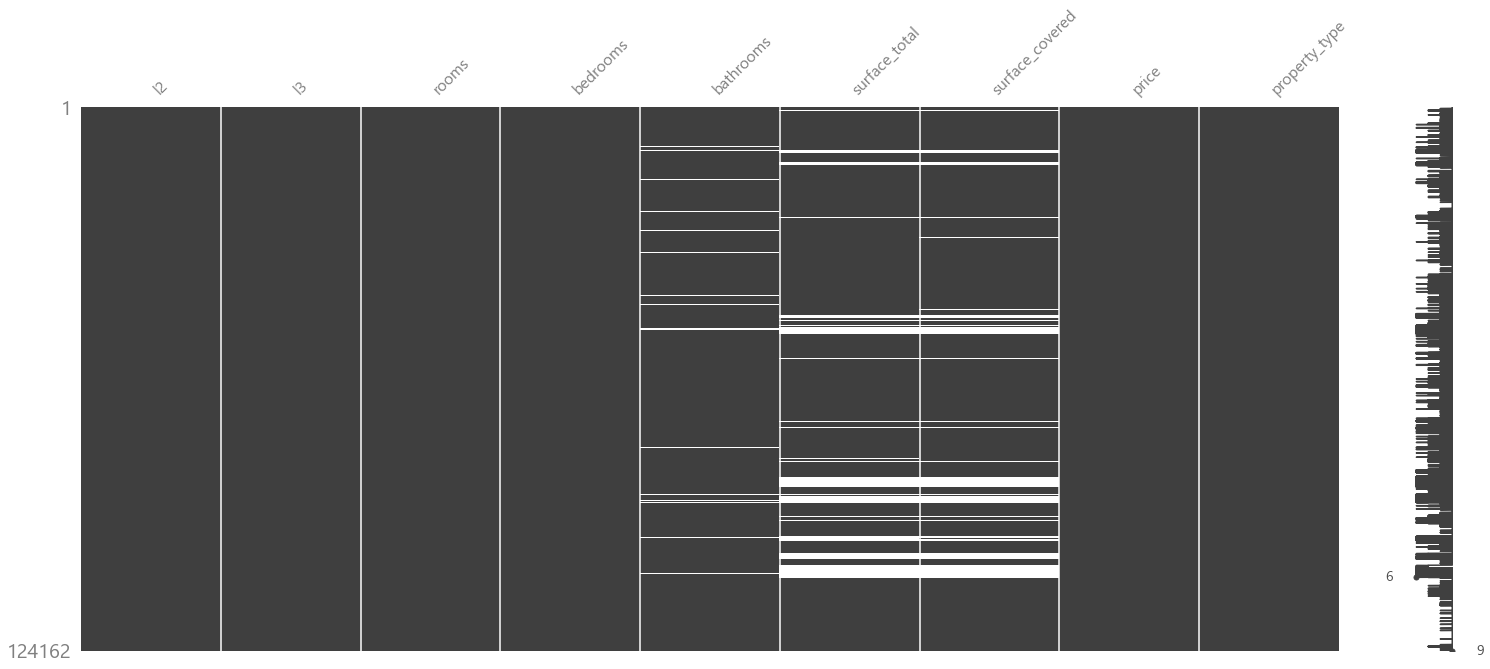

In [40]:
# visualiza los valores flatantes en un matrix
msno.matrix(data4)

La correlación de nulidad varía de -1 (si una variable aparece la otra definitivamente no lo hace) a 0 (las variables que aparecen o no aparecen no tienen efecto entre sí) a 1 (si una variable aparece la otra definitivamente también lo hace).

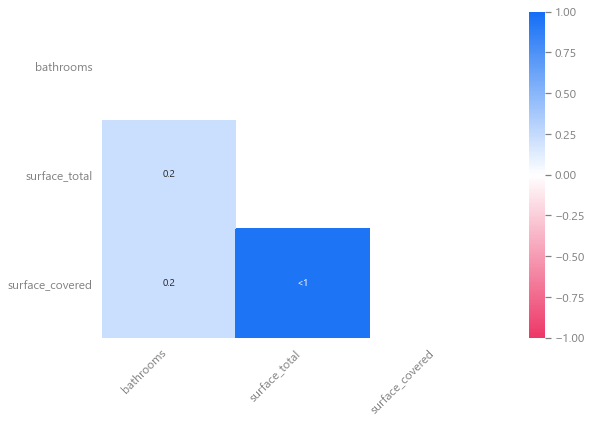

In [41]:
# Visualiza la correlación de los valores faltantes en diferentes columnas como un heatmap
msno.heatmap(data4, figsize=(9,6), fontsize=12, cmap=BlueRed)

De las anteriores visulizaciones podemos concluir:
- La correlación de datos faltante entre supreficie total y superficie subierta es cercana una, es decir, cuando una tienen datos la otra también y viceversa. 
- Los datos faltante de Baños no tiene ninguna relación con otra variable con datos faltantes.

Ahora procederemos a verrificar el tipo de valor faltante de cada variable. La bibliografía nos dice que debemos asumir que todas las variable son MAR hasta que se demuestre lo contrario. 

Probablemente la forma más común de comprobar si hay datos faltantes de tipo __MCAR__ es crear variables dummies para las variables que contienen datos faltantes (que marcan si hay datos faltantes o no) y luego realizar múltiples pruebas t (datos continuos) y/o pruebas de chi-cuadrado (datos categóricos) entre las variables dummies y otras variables para ver si la falta de datos está relacionada con los valores de las otras variables. Si estas pruebas muestran que la ausencia de valores está relacionada con los valores de las otras variables, entonces esto presta evidencia indirecta para los datos MAR.

### 2.3.1 MCAR (Categóricas)

Definimos la función para hacer las pruebas.

In [42]:
def mcar_cat(data, cat_col, null_col):
    '''
    Cuenta los valores nulos por cada tipo de la variable categorica y
    extrae su porcentaje del total.
    
    data: el dataframe.
    cat_col: ['string'] la columna que contiene valores categoricos.
    null_col: ['string'] la columna que contiene valores los valores nulos.
    '''
    # Cuenta los valores de la columna categorica
    total = data[cat_col].value_counts().reset_index().sort_values('index', ignore_index=True)
    
    # Cuenta los valores faltantes de la columna a evaluar
    null = data[null_col].isnull().groupby([data[cat_col]]).sum().astype(int).reset_index()
    
    # Porcentaje de valores faltantes sobre el total de instancias de cada tipo
    porcentaje = null.iloc[:, 1]/total.iloc[:, 1]
    
    # Crea el dataframe
    cols = [cat_col, 'null', 'porc']
    datos_faltantes = pd.concat([null.iloc[:, 0], null.iloc[:, 1], porcentaje], axis=1, keys=cols)
    return datos_faltantes

##### Missing respecto a `l2`

In [43]:
null_cols = ['bathrooms', 'surface_total', 'surface_covered']
for col in null_cols:
    print(col, ':')
    display(mcar_cat(data4, 'l2', col).style.format({'null': '{:,}', 'porc': '{:.2%}'}))

bathrooms :


surface_total :


surface_covered :


##### Missing respecto a `l3`

Puesto que los valores fatantes de las superficies se parecen bastante, procederemos a solo analizar surface_total y asumir el mismo resultado para surface_covered

In [44]:
null_cols = ['bathrooms', 'surface_total', 'surface_covered']
for col in null_cols:
    print(col, ':')
    l3 = mcar_cat(data4, 'l3', col)
    display(l3.sort_values('porc', ascending=False).head(10).style.format({'null': '{:,}', 'porc': '{:.2%}'}))

bathrooms :


surface_total :


surface_covered :


##### Missing respecto a `property_type`

In [45]:
null_cols = ['bathrooms', 'surface_total', 'surface_covered']
for col in null_cols:
    print(col, ':')
    display(mcar_cat(data4, 'property_type', col).style.format({'null': '{:,}', 'porc': '{:.2%}'}))

bathrooms :


surface_total :


surface_covered :



***
Para resumir los datos, construimos un tabla de __MCAR test__ donde digitaremos `True` para cada par de variable donde se evidencia que la ausencia de datos se debe completamente al azar, y `False` para aquellas en las que se note algún patron y con las cuales se pueda obtener información para su futura imputación. Los pares de variables de digan `False` se asumirán como MAR, excepto que aquelllas variables que estén muy correlacionadas con la variable faltante, en cuyo caso se valorará que sea MNAR.

| Column | l2 | l3	| rooms	| bedrooms	| bathrooms	 | surface_total | surface_covered | price | property_type |
| :- | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| bathrooms | True | True | | | | | | | True |
| surface_total | True | False | | | | | | | False|
| surface_covered | True| False | | | | | | | False |


### 2.3.2 MCAR (Númericas)

In [46]:
def mcar_cont(df, null_col, corr_col, bins=10):
    '''
    Cuenta los valores nulos por cada bin de la variable continua correlacionada.

    df: el dataframe.
    null_col: ['string'] la columna que contiene valores los valores nulos.
    corr_col: ['string'] la columna correlacionada con valores numericos.
    bins: [int or list of scalar] el número de bins en el que dividirá la colummna 
          correlacionada. Default = 10.
    '''
    # Binea a colummna correlacionada
    data = df.copy()
    data['bins'] = pd.cut(data[corr_col], bins=bins)

    # Cuenta los valores null por intervalo
    mnar = data[null_col].isnull().groupby(
        [data['bins']]).sum().astype(int).reset_index(name='count')

    # Frecuecia de los null por intervalo
    mnar['freq'] = mnar['count'] / \
        data.groupby([data['bins']]).count()[corr_col].values

    # Agregamos el punto medio para poder graficar
    mnar['bin_centres'] = mnar['bins'].apply(lambda x: x.mid)

    # Graficamos
    plt.figure(figsize=(7, 4))
    plt.scatter(mnar['bin_centres'], mnar['freq'])
    plt.title('Frecuencia de valores faltantes de {}'.format(null_col))
    plt.xlabel(corr_col)
    plt.ylabel('Frecuencia')
    plt.show()

In [47]:
def mcar_disc(df, null_col, corr_col):
    '''
    Cuenta los valores nulos por cada bin de la variable discreta correlacionada.

    df: el dataframe.
    null_col: ['string'] la columna que contiene valores los valores nulos.
    corr_col: ['string'] la columna correlacionada con valores numericos.

    '''
    #Cuenta los valores null por intervalo
    mnar = df[null_col].isnull().groupby([df[corr_col]]).sum().astype(int).reset_index(name='count')
    
    #Frecuecia de los null por intervalo
    total = df['rooms'].value_counts().reset_index().sort_values('index', ignore_index=True)
    mnar['freq'] = mnar['count']/total.iloc[:,1]
    
    #Graficamos
    plt.figure(figsize = (7, 4))
    plt.scatter(mnar.iloc[:,0], mnar['freq'])
    plt.title('Frecuencia de valores faltantes de {}'.format(null_col))
    plt.xlabel(corr_col)
    plt.ylabel('Frecuencia')
    plt.show()

##### Missing con respecto a `rooms`

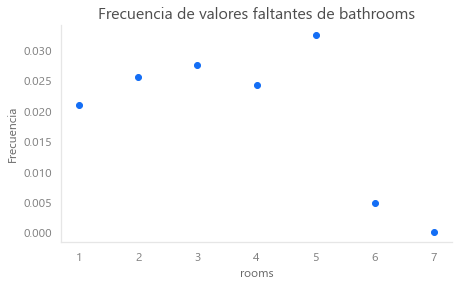

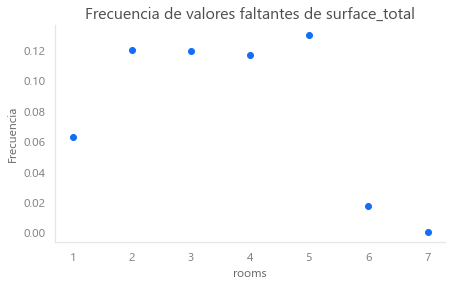

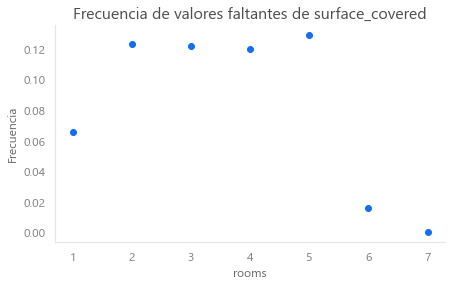

In [48]:
null_cols = ['bathrooms', 'surface_total', 'surface_covered']
for col in null_cols:
    mcar_disc(data4, col, 'rooms')

##### Missing con respecto a `bedrooms`

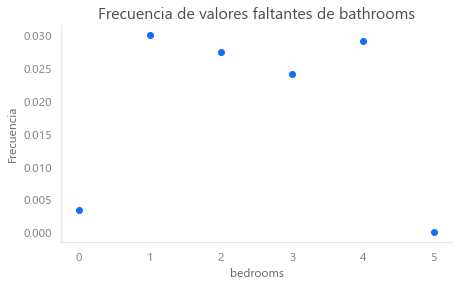

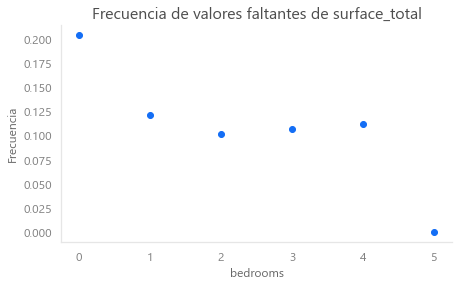

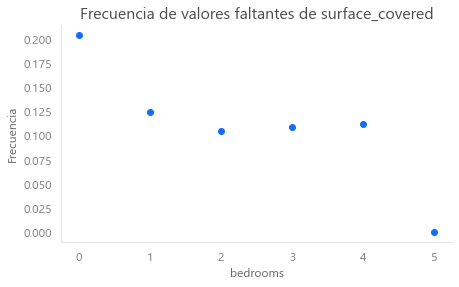

In [49]:
null_cols = ['bathrooms', 'surface_total', 'surface_covered']
for col in null_cols:
    mcar_disc(data4, col, 'bedrooms')

##### Missing con respecto a `bathrooms`

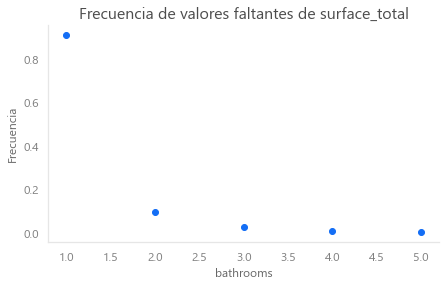

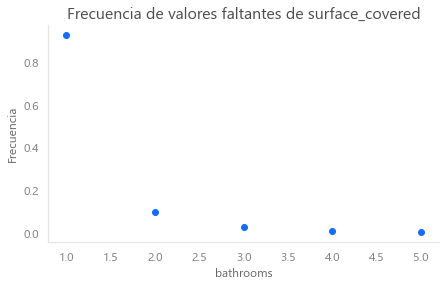

In [50]:
null_cols = ['surface_total', 'surface_covered']
for col in null_cols:
    mcar_disc(data4, col, 'bathrooms')

##### Missing con respecto a `surface_total`

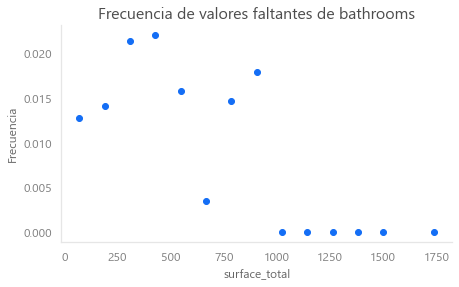

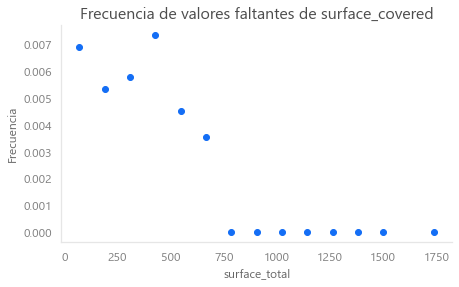

In [51]:
null_cols = ['bathrooms', 'surface_covered']
for col in null_cols:
    mcar_cont(data4, null_col=col, corr_col='surface_total', bins=15)

##### Missing con respecto a `surface_covered`

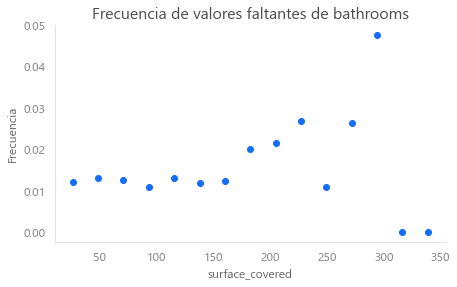

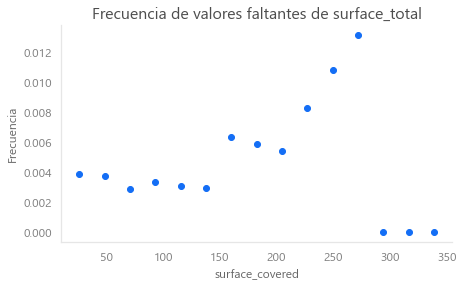

In [52]:
null_cols = ['bathrooms', 'surface_total']
for col in null_cols:
    mcar_cont(data4, null_col=col, corr_col='surface_covered', bins=15)

##### Missing con respecto a `price`

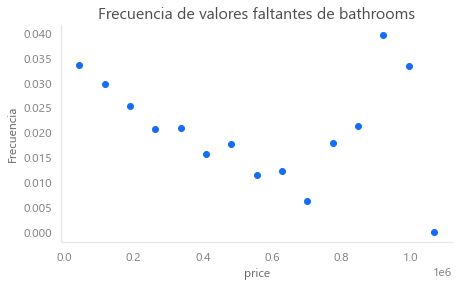

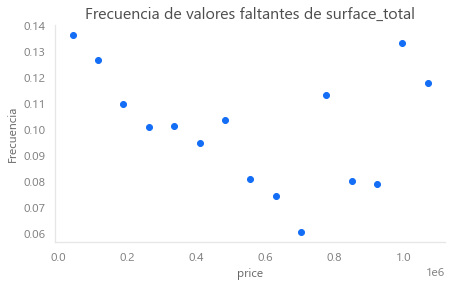

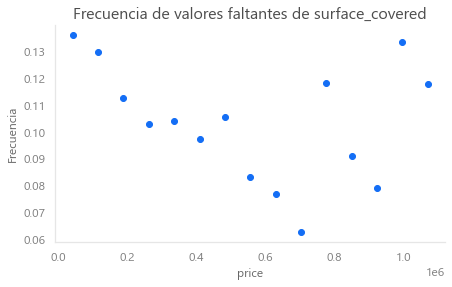

In [53]:
null_cols = ['bathrooms', 'surface_total', 'surface_covered']
for col in null_cols:
    mcar_cont(data4, null_col=col, corr_col='price', bins=15)

***
Actualizamos nuestra tabla de __MCAR test__ con las pruebas númericas:

| variable | l2 | l3	| rooms	| bedrooms	| bathrooms	 | surface_total | surface_covered | price | property_type |
| :- | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| bathrooms | True | True | True | True | NA | True | True | True | True |
| surface_total | True | False | True | True | False | NA | True | True | False|
| surface_covered | True| False | True  | True | False | True |NA | True | False |

De esto sacamos las siguientes conclusiones:
- Puesto que las variables con datos faltantes no tienen correlación alta con otra variable, no podemos identificar algún caso de MNAR.
- Bathroom se puede llegar a clasificar como MCAR puesto que sus valores faltantes no desmotraron relación con alguna otra variable observable.
- Las dos varibales referentes a superficie se clasifican como MAR ya que se denota evidencia con los datos observados de otras variables.

### 2.3.3 Imputación de valores faltantes

Puesto que usaremos diferentes métodos de imputación, intetaremos evaluar su performace gráficamente. Las variables que usaremos para imputar las que tienen valores faltantes serán estas:
- __Bathrooms:__ bedrooms.
- __Surface total:__  bedrooms, bathrooms, property_type.
- __Surface covered:__ bedrooms, bathrooms, surface_total, property_type.

_Nota:_ aunque la variable rpcie nos pordía servir para predecir la superficie, no sería una buena practica usarla porque habría una 'data lekeage'.

In [54]:
# Creamos diferentes copias del dataset para compararlos
data_imp_median = data4.copy()
data_imp_mode = data4.copy()
data_imp_iter = data4.copy()
data_imp_knn = data4.copy()

__Mediana:__

In [55]:
# Imputamos con mediana
cols = ['bathrooms', 'surface_total', 'surface_covered']
imp_median = SimpleImputer(strategy='median')
imp_median.fit(data_imp_median[cols])
data_imp_median[cols] = imp_median.transform(data_imp_median[cols])

# Verificamos datos faltantes
data_imp_median.isnull().sum().sort_values(ascending=False)

property_type      0
price              0
surface_covered    0
surface_total      0
bathrooms          0
bedrooms           0
rooms              0
l3                 0
l2                 0
dtype: int64

__Moda:__

In [56]:
# Imputamos con moda
cols = ['bathrooms', 'surface_total', 'surface_covered']
imp_mode = SimpleImputer(strategy='most_frequent')
imp_mode.fit(data_imp_mode[cols])
data_imp_mode[cols] = imp_mode.transform(data_imp_mode[cols])

# Verificamos datos faltantes
data_imp_mode.isnull().sum().sort_values(ascending=False)

property_type      0
price              0
surface_covered    0
surface_total      0
bathrooms          0
bedrooms           0
rooms              0
l3                 0
l2                 0
dtype: int64

__Iterative Imputer:__

In [57]:
from sklearn.tree import ExtraTreeRegressor

X = data_imp_iter.copy()

number_cols = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
string_cols = ['property_type', 'l2']

# Escalamos los datos
transformer = RobustScaler().fit(X[number_cols])
X[number_cols] = transformer.transform(X[number_cols])

# Codificamos las variables categoricas
for col in string_cols:
    X = pd.concat([X, pd.get_dummies(X[col])], axis=1)
    X.drop(col, axis=1, inplace=True)

#Imputamos con Iterative Imputer
numeric_cols = X.select_dtypes(include='number').columns.tolist()
extra_tree = ExtraTreeRegressor(random_state=0)
imp_iter = IterativeImputer(extra_tree, random_state=100)
X[numeric_cols] = imp_iter.fit_transform(X[numeric_cols])

# Desescalamos los datos
X[number_cols] = transformer.inverse_transform(X[number_cols])

# Reemplazamos las columnas faltantes en nuestro dataset original
cols = ['bathrooms', 'surface_total', 'surface_covered']
data_imp_iter[cols] = X[cols]
data_imp_iter['bathrooms'] = data_imp_iter['bathrooms'].round()

# Verificamos datos faltantes en nuestro dataset original
print(data_imp_iter.isnull().sum().sort_values(ascending=False))

property_type      0
price              0
surface_covered    0
surface_total      0
bathrooms          0
bedrooms           0
rooms              0
l3                 0
l2                 0
dtype: int64


__KNN Imputer:__

In [58]:
X = data_imp_knn.copy()

number_cols = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
string_cols = ['property_type', 'l2']

# Escalamos los datos
transformer = RobustScaler().fit(X[number_cols])
X[number_cols] = transformer.transform(X[number_cols])

# Codificamos las variables categoricas
for col in string_cols:
    X = pd.concat([X, pd.get_dummies(X[col])], axis=1)
    X.drop(col, axis=1, inplace=True)
    
#Imputamos con KNN
numeric_cols = X.select_dtypes(include='number').columns.tolist()
knnimputer = KNNImputer(n_neighbors=10)
X[numeric_cols] = knnimputer.fit_transform(X[numeric_cols])
X[numeric_cols].isnull().sum()

# 'Desescalamos' los datos
X[number_cols] = transformer.inverse_transform(X[number_cols])

# Reemplazamos las columnas faltantes en nuestro dataset original
cols = ['bathrooms', 'surface_total', 'surface_covered']
data_imp_knn[cols] = X[cols]
data_imp_knn['bathrooms'] = data_imp_knn['bathrooms'].round()

# Verificamos datos faltantes en nuestro dataset original
print(data_imp_knn.isnull().sum().sort_values(ascending=False))

property_type      0
price              0
surface_covered    0
surface_total      0
bathrooms          0
bedrooms           0
rooms              0
l3                 0
l2                 0
dtype: int64


#### 2.3.3.1 Comparando imputaciones de 'bathrooms'

Definimos la función que luego usaremos con cada variable

In [59]:
def impute_scatter_compare(df_original, df_imputed, var_null, vars_compare):
    '''
    Compara diferentes formas de imputación mediante scatter plots.
    
    
    Argumentos
    df_original: (obj: pd.DataFrame) DataFrame original, que contiene los valores faltantes.
    df_imputed: (list) Lista de los datasets con los valores faltantes, debe contener un nombre para cada dataframe.
    var_null: (str) Nombre de la columna que tiene los valores faltantes.
    vars_compare: (list) Lista de strings con los nombres de las columnas con las que se quiere visualizar la comparativa.
    
    Return
    Matplotlib plot

    '''
    # Define las medidas del gráfico
    plt.figure(figsize=(len(df_imputed)*3.5, len(vars_compare)*3.5))
    plt.subplots_adjust(wspace=0.15, hspace=0.15)

    plot_num = 1

    for i, var in enumerate(vars_compare):

        for name, df in df_imputed:
            plt.subplot(len(vars_compare), len(df_imputed), plot_num)

            if i == 0:
                plt.title(name)
            
            # Crea una lista booleanas de valores nulos
            nulls = df_original.isnull()[var_null].astype(int)
            
            # Grafica los puntos que reales e imputados
            sns.scatterplot(var_null, var, data=df[nulls == 0], s=25)
            sns.scatterplot(var_null, var, data=df[nulls == 1], s=25)

            # Define si el plot actual debe llevar etiquetas en los ejes
            cols = len(df_imputed)
            filas = len(vars_compare)
            n_plots = cols * filas
            
            # Eje X
            x_labels = list(np.arange(n_plots-cols+1, n_plots + 1))
            if plot_num in x_labels:
                plt.xlabel(var_null)
            else:
                plt.xlabel('')
                plt.xticks(())
            
            # Eje Y
            y_labels = [1]
            while len(y_labels) < filas:
                y_labels.append(y_labels[-1]+cols)
                if len(y_labels) == filas:
                    continue

            if plot_num in y_labels:
                plt.ylabel(var)
            else:
                plt.ylabel('')
                plt.yticks(())
            
            plot_num += 1

    plt.show()

In [60]:
def impute_hist_compare(df_original, df_imputed, var_null):
    '''
    Compara diferentes formas de imputación mediante histogramas.
    
    
    Argumentos
    df_original: (obj: pd.DataFrame) DataFrame original, que contiene los valores faltantes.
    df_imputed: (list) Lista de los datasets con los valores faltantes, debe contener un nombre para cada dataframe.
    var_null: (str or list) Nombre de la columna que tiene los valores faltantes.
    
    Return
    Matplotlib plot

    '''
    # Define las medidas del gráfico
    plt.figure(figsize=(len(df_imputed)*3.5, 3.5))
    plt.subplots_adjust(wspace=0.15, hspace=0.15)

    plot_num = 1

    for name, df in df_imputed:
        plt.subplot(1, len(df_imputed), plot_num)

        plt.title(name)
            
        # Crea una lista booleanas de valores nulos
        nulls = df_original.isnull()[var_null].astype(int)
            
        # Grafica los puntos que reales e imputados
        rango = (df[var_null].min(), df[var_null].max())
        
        sns.distplot(df[nulls == 0][var_null], kde=False, bins=15, 
                     hist_kws={'range': rango, 'alpha': 0.8})
        
        sns.distplot(df[nulls == 1][var_null], kde=False, bins=15, 
                     hist_kws={'range': rango, 'alpha': 1})
        
        # Define si el plot actual debe llevar etiquetas en los ejes
        plt.xlabel(var_null)

        if plot_num == 1:
            plt.ylabel('density')
        else:
            plt.ylabel('')
            plt.yticks(())
            
        plot_num += 1

    plt.show()

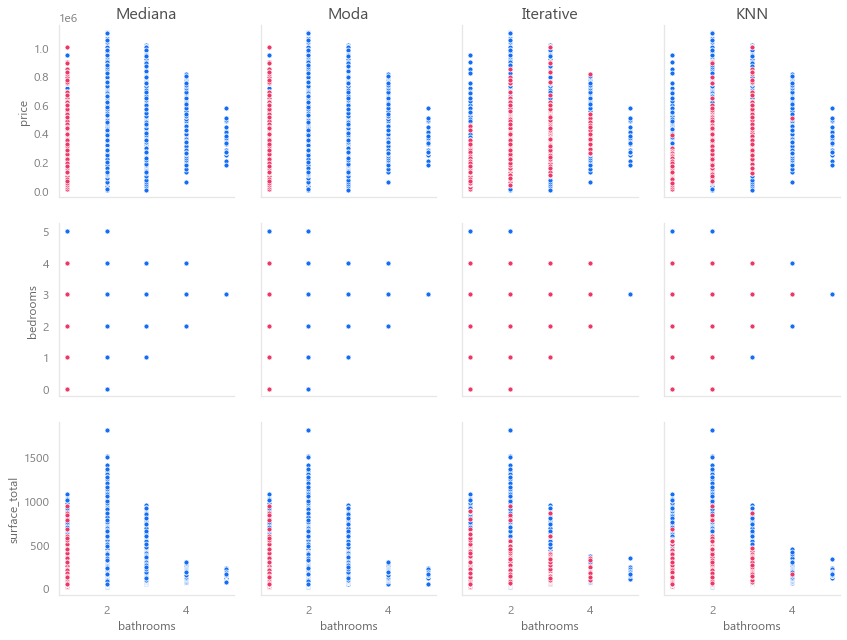

In [61]:
df_imputed = [('Mediana', data_imp_median), ('Moda', data_imp_mode),
              ('Iterative', data_imp_iter), ('KNN', data_imp_knn)]
var_null = 'bathrooms'
vars_compare = ['price', 'bedrooms', 'surface_total']

impute_scatter_compare(data4, df_imputed, var_null, vars_compare)

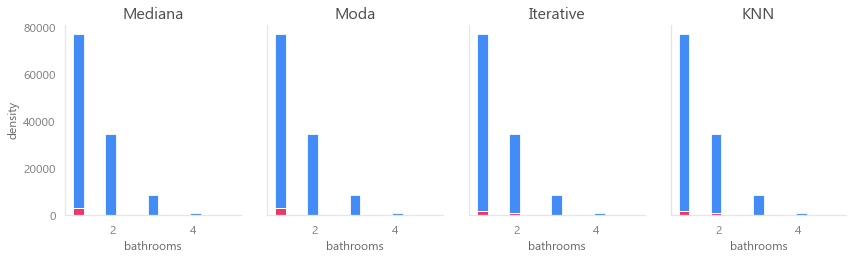

In [62]:
impute_hist_compare(data4, df_imputed, var_null)

#### 2.3.3.2 Comparando imputaciones de `surface_total`

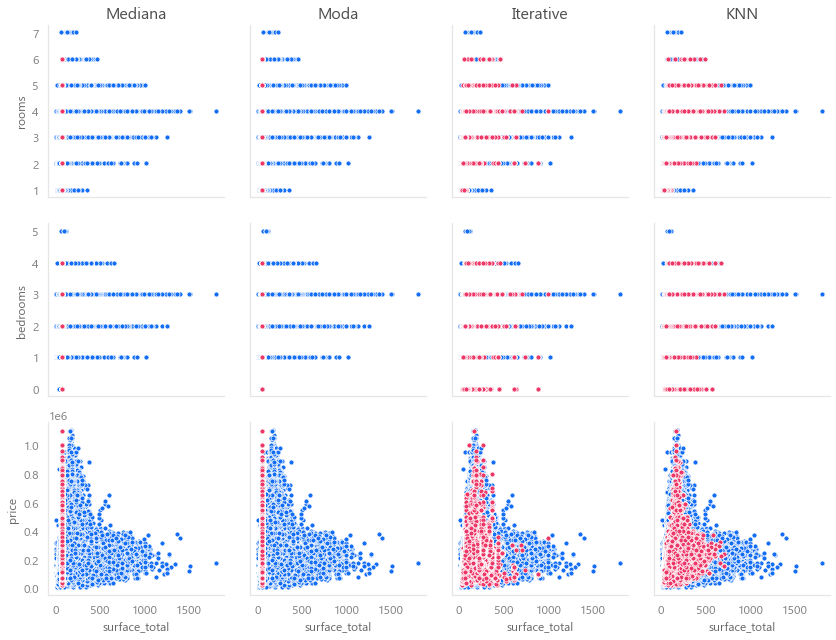

In [63]:
var_null = 'surface_total'
vars_compare = ['rooms', 'bedrooms', 'price']

impute_scatter_compare(data4, df_imputed, var_null, vars_compare)

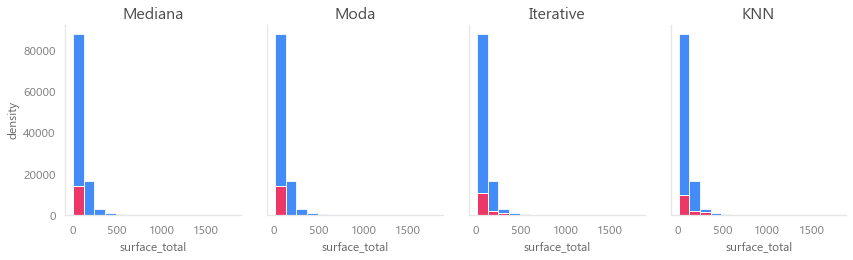

In [64]:
impute_hist_compare(data4, df_imputed, var_null)

#### 2.3.3.3 Comparando imputaciones de `surface_covered`

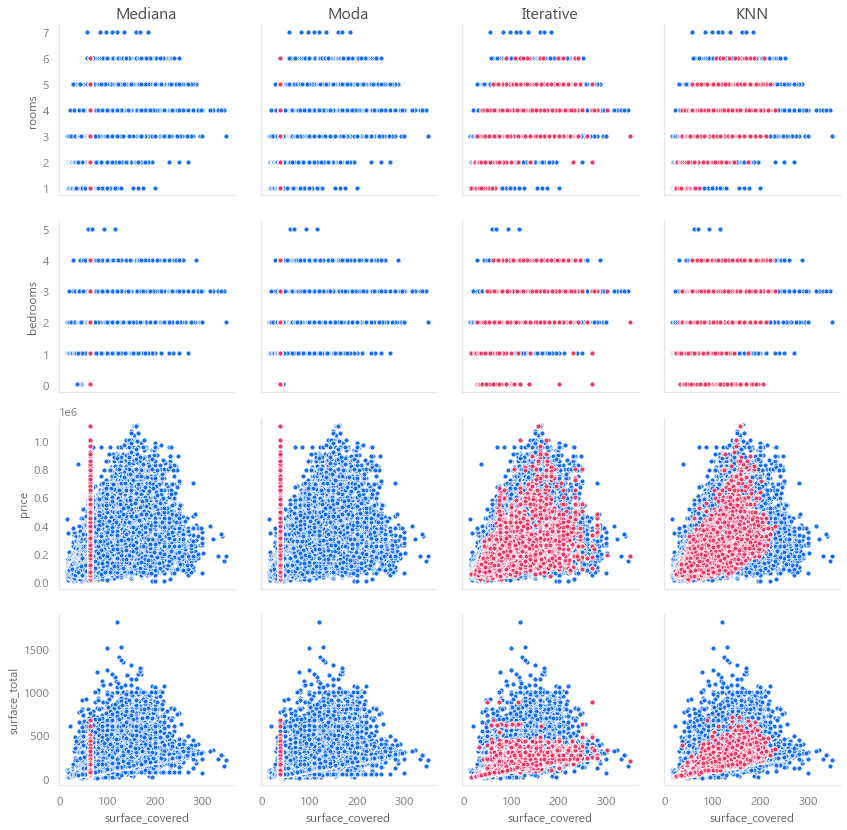

In [65]:
var_null = 'surface_covered'
vars_compare = ['rooms', 'bedrooms', 'price', 'surface_total']

impute_scatter_compare(data4, df_imputed, var_null, vars_compare)

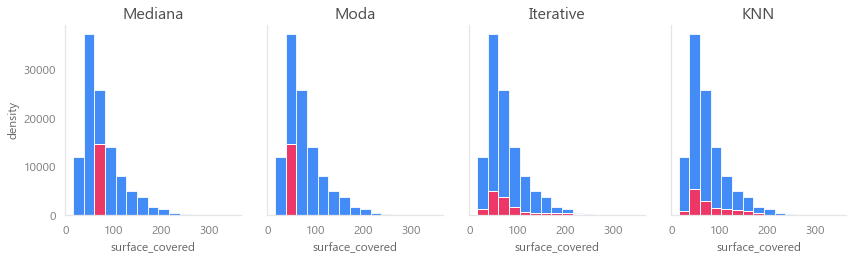

In [66]:
impute_hist_compare(data4, df_imputed, var_null)

***
Como se puede observar Iterative Imputer y KNN Imputer son los dos métodos que mejor imputan los datos faltantes. Gracias a las visualizaciones podemos sacar conclusiones certeras de qué método se comporta mejor con cada caso. Si bien Iterative no hace un mala imputación, podemos ver las distribuciones de las imputaciones de KNN se asemejan más a la distribución de los datos observados, por ello usaremos este método para imputar las tres variables.

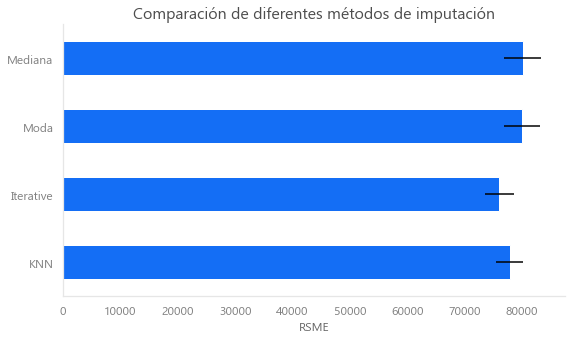

In [67]:
numeric_cols = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

df_imputed = [('Mediana', data_imp_median), ('Moda', data_imp_mode),
              ('Iterative', data_imp_iter), ('KNN', data_imp_knn)]

score_imputers = pd.DataFrame() 
estimator = DecisionTreeRegressor(random_state=100)

for name, df in df_imputed:
    X = df[numeric_cols]
    y = df['price'].values
    score_imputers[name] = cross_val_score(estimator, X, y, 
                                           scoring='neg_root_mean_squared_error', 
                                           cv=5)

# Grafica los resultados
fig, ax = plt.subplots(figsize=(9, 5))
means = -score_imputers.mean()
errors = score_imputers.std()
means.plot.barh(xerr=errors, ax=ax, ecolor='black')
ax.set_title('Comparación de diferentes métodos de imputación')
ax.set_xlabel('RSME')
ax.invert_yaxis()
plt.show()

In [68]:
# Intercambiamos las columnas por la de los datos imputados
cols = ['bathrooms', 'surface_total', 'surface_covered']
data5 = data4.copy()
data5[cols] = data_imp_iter[cols]

# Verificamos que no falten datos
data5.isnull().sum()

l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
property_type      0
dtype: int64

In [69]:
# Revisamos que las propiedad con superficie cubierta mayor que la total
print(data5.query('surface_covered > surface_total').shape[0]/data5.shape[0]) 

0.01607577197532256


Vemos que la cantidad aumentó a 1.6%, las eliminamos.

In [70]:
data5 = data5.query('surface_total >= surface_covered')
print(data5.query('surface_covered > surface_total').shape[0]/data5.shape[0])

0.0


In [71]:
# Eliminamos las variables que ya utilizamos
del data_imp_median
del data_imp_mode
del data_imp_iter
del data_imp_knn
del X, y, y_pred
del df

<a id="03"></a>

# 3. Análisis exploratorio

El análisis exploratorio de los datos (EDA) los abordaremos de manera sistemática, primero abordamos cada varible pos sí misma, para luego pasar a sus relaciones, en el análisis multivariado. Finalmente terminaremos la parte del preprocesamiento requerido para el modelado con Machine Learning.

In [72]:
data5.describe().apply(lambda s: s.apply(lambda x: format(x, '.1f')))

rooms  bedrooms bathrooms surface_total surface_covered      price
count  122166.0  122166.0  122166.0      122166.0        122166.0   122166.0
mean        2.9       1.9       1.4         100.7            75.1   193458.5
std         1.0       0.9       0.7          93.0            40.9   123582.4
min         1.0       0.0       1.0          16.0            15.0     6000.0
25%         2.0       1.0       1.0          50.0            45.0   110000.0
50%         3.0       2.0       1.0          73.0            63.0   159400.0
75%         4.0       3.0       2.0         114.0            92.0   240000.0
max         7.0       5.0       5.0        1800.0           322.0  1105383.0

Con estas estadísticas descriptivas sacamos las siguientes conclusiones:

- La propiedades (que como hemos notado en los anteriores analisis) que en su mayoría son departamentos tienen en promedio 2 habitaciones y 1 baño, y tienden a no sobrepasar los 100m2 de superficie total. Mientras que el precio de la gran mayoría se encuentra en el rango \\$100k y \\$250k. 
- Gracias al procesamiento de outliers previo, los valores más extremos de cada variable no alejan tanto de la media y la mediana.
- No hay propiedades con valor 0, aunque sí que hay algunas con superficie cubierta de 1 m2, las eliminaremos porque seguro se deben a error de digitación.

## 3.1 Análisis univariado

Primero analizamos la variable independiente, el precio.

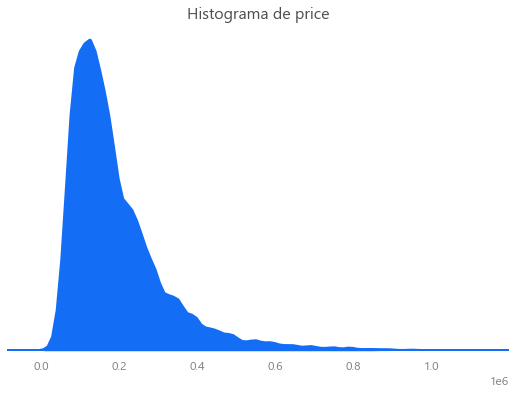

In [73]:
# Histograma
sns.kdeplot(data5.price, 
            shade=True, 
            alpha=1, 
            lw=2, 
            color=blue, 
            legend=False)
sns.kdeplot(data5.price, 
            lw=4, 
            color=blue, 
            legend=False)
plt.axhline(y=0, lw=4)

plt.title('Histograma de price')
plt.xlabel('')
plt.yticks(())
sns.despine(left=True, bottom=True)

In [74]:
# Custosis y asimetría
print('Asimetría: {}'.format(data5.price.skew()))
print('Curtosis: {}'.format(data5.price.kurt()))

Asimetría: 1.9886416296585026
Curtosis: 5.606933278490301


De los histograma podemos obtener:
- La variable precio tiene asimetría positiva.
- La curtosis es alta.
- Se puede aplicar una transformación logaritmica y normalizar la distribución.

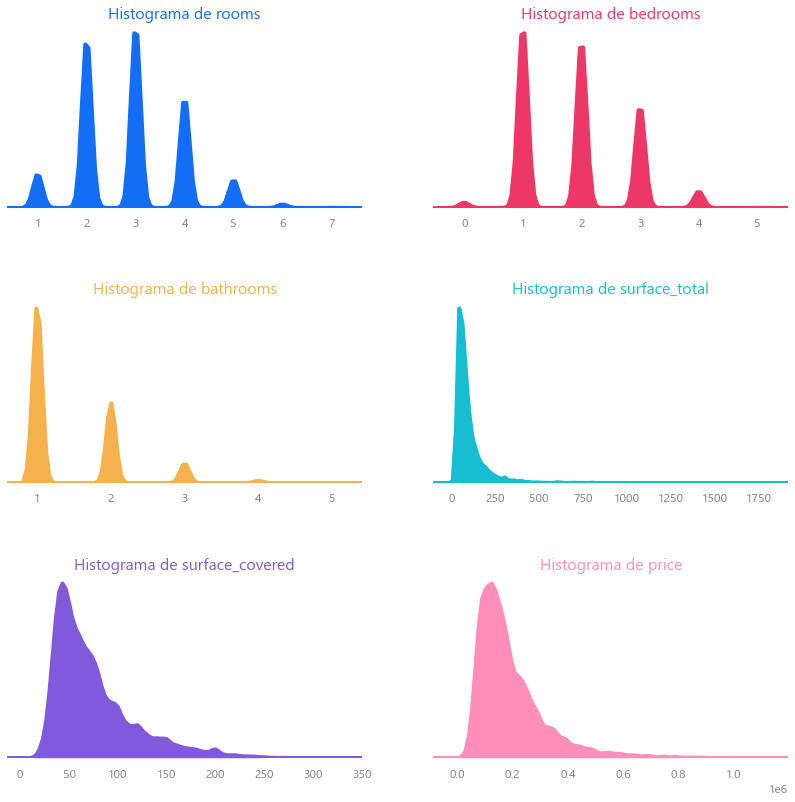

In [75]:
numeric_cols = data5.select_dtypes(include='number').columns.tolist()

plt.figure(figsize=(14, (len(numeric_cols)/2)*4.5))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plot_num = 1
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols)/2, 2, plot_num)
    
    sns.kdeplot(data5[col], 
                shade=True, 
                alpha=1, 
                lw=2, 
                color=Palette[i], 
                legend=False)
    
    sns.kdeplot(data5[col], 
                lw=4, 
                color=Palette[i], 
                legend=False)
    
    plt.axhline(y=0, lw=4, color=Palette[i])
    plt.title('Histograma de {}'.format(col), color=Palette[i])
    plt.xlabel('')
    plt.yticks(())
    sns.despine(left=True, bottom=True)
    plot_num += 1

La visulización de las variables númericas nos dan algunas ideas interesantes sobre la distribución de valores:

1. __Rooms__ es una variable discreta, por ello el histograma luce más como un diagrama de barras. Sin embargo, nos sirve para visualizar como se distribuye las observaciones. Vemos que la mayoría está entre 2, 3 y 4, mientras que propiedas con 6 y 7 claramente representan un minoría. Más adelante revisaremos cual es el precio promedio por cantidad de ambientes.

2. El número de __Bedrooms__ llega hasta 14, aunque la mayoría se ubica entre 1 y 3. Mientras que en __Bathroooms,__ el áximo número de baños es 4. Lo cual tiene bastante sentido, ya que no se suele ter un baño por cada habitación en una vivienda, sea departametno, csas o PH.

3. La distribución de __Surface_total__ y __Surface_covered__ es muy similar, ambas asímetricas y leptocurticas, la diferencia reside en que la superficie ttoal adquiere valores más altos que superficie cubierta. ¿Convendría hacer transformación logaritmica a ambas variaables?

Ahora, para los atributos categóricos, sería mejor si pudiéramos ver sus distribuciones de frecuencia. Usaremos los countplots para lograr esto.

In [76]:
def put_labels(X, fontsize=12):
    padding = max(X) * 0.01
    for i, val in enumerate(X):
        ax.text(x=X[i]-padding,
                y=i,
                s='{:,}'.format(X[i]),
                va='center',
                ha='right',
                color='white',
                weight='bold',
                fontsize=fontsize)

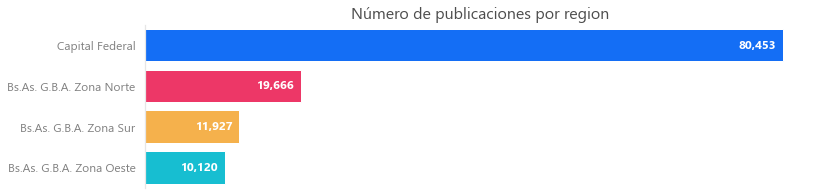

In [77]:
#Hallamos las publicaciones por localidad
regiones = data5.l2.value_counts()

# Creamos el countplot
plt.figure(figsize=(12, 3))
ax = sns.barplot(x=regiones.values, 
                 y=regiones.index,
                 palette=Palette, 
                 orient='h', 
                 saturation=1)
ax.set_title('Número de publicaciones por region')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(())
sns.despine(bottom=True)
put_labels(regiones)

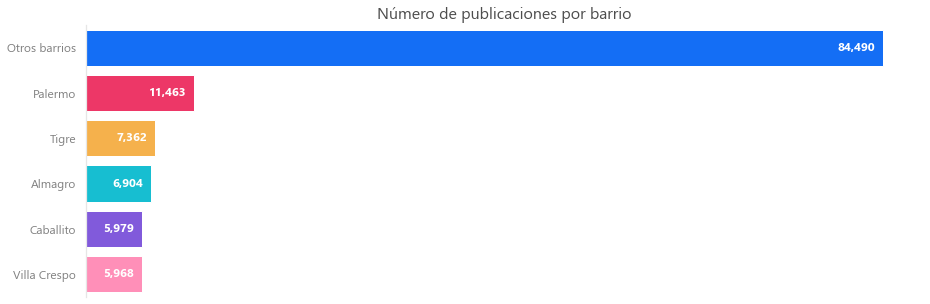

In [78]:
#Hallamos las publicaciones por barrio y mantenemos los 5 más altos
barrios = data5.l3.value_counts()
otros = barrios.iloc[5:].sum()
barrios = barrios.drop(index=barrios.iloc[5:].index)
barrios['Otros barrios'] = otros
barrios.sort_values(ascending=False, inplace=True)

# Creamos el countplot
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=barrios.values, 
                 y=list(barrios.index),
                 palette=Palette[:6], 
                 orient='h', 
                 saturation=1)
ax.set_title('Número de publicaciones por barrio')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
sns.despine(bottom=True)
put_labels(barrios)

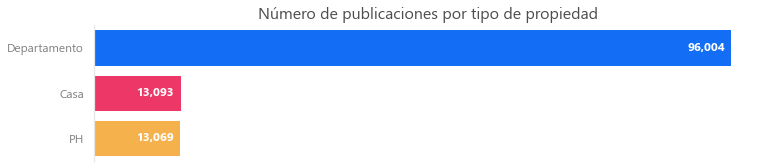

In [79]:
#Hallamos las publicaciones por localidad
tipos = data5.property_type.value_counts()

# Creamos el countplot
plt.figure(figsize=(12, 2.5))
ax = sns.barplot(x=tipos.values, 
                 y=tipos.index,
                 palette=Palette, 
                 orient='h', 
                 saturation=1)
ax.set_title('Número de publicaciones por tipo de propiedad')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
sns.despine(bottom=True)
put_labels(tipos)

De los graficos anteriores podemos interpretar las siguientes cosas:
- La mayoría de las publicaciones son de Capital federal, el resto provienen del resto de zonas del Área Metropolitana de Buenos Aires.
- Hay barrios que tienen más publicaciones que otros, entre los principales está Palermo, Tigre, Almagro, Villa Crespo y  Caballito. Hay algo en común que tienen todos estos barrios, y es que están entre los que tienen mayor numero de habitantes, y los que tienen una gran superficie. Todas estas pertencen a Capital Federal, a excepción de Tigre, que está en el partido homonimo en la zona nore la provincia de Buenos aires.
- Los departamentos representan la gran mayoría de lo que se publica, el resto está distribuido uniformemente entre casas y PH.


## 3.2 Análisis multivariado

Para explorar las relaciones entre las variables nos valdremos de diagramas de dispersión y diagramas de barra para las atributos categoricos. Pero ante grafiquemos la una matriz de correlación entre las variables, que nos servirá para guiar la exploración.

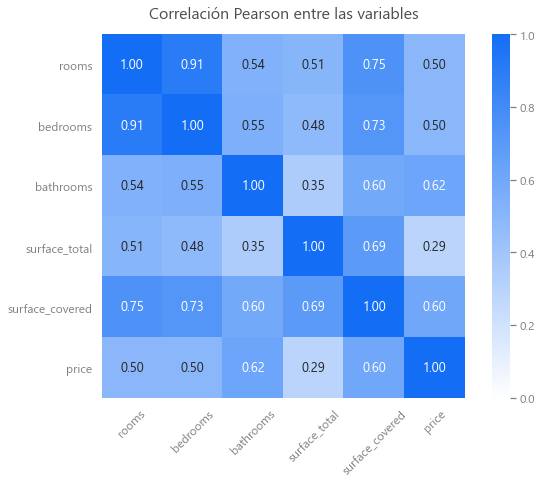

In [80]:
plt.figure(figsize=(9, 7))
corr = data5.corr()
sns.heatmap(data = corr, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels= corr.columns, yticklabels= corr.columns, 
            cmap=Blues, vmin=0)

plt.title('Correlación Pearson entre las variables', pad=16)
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

Podemos ver que hay una relativamente alta correlación entre las variables.
1. El atributo surface_total no parece será relevante para predecir el precio.
2. De las variables númericas, potencialmente las que más le aportaran al modelo serán el número de baños y la supercie cubierta.

Verifiquemos estos resultados con regplots de Seaborn.

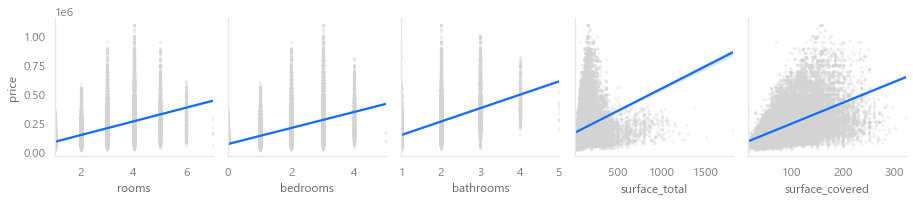

In [81]:
sns.pairplot(data5.sample(frac=0.5, random_state=100), 
             x_vars=['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered'], 
             y_vars=['price'],
             kind='reg',
             aspect=1,
             plot_kws={'line_kws':{'color':blue},
                       'scatter_kws':{'color':'lightgrey', 's': 5, 'alpha':0.2}}
            )

Hay un correlación positiva con todas variables, tal como vimos en el heatmap, pero en el caso de _surface total_ el diagrama de dispersión muestra una especie de divergencia, posibemente sean dos grupos de propiedades con comportamiento diferentes, lo que hace que la correlación no sea tan alta como con _surface covered._

Analizemos a mayor profundidad el diagrama de dispersión entre estas dos variables.

Text(0.5, 1.05, 'Regplots de precio y superficie total (desagregado por tipo de propiedad)')

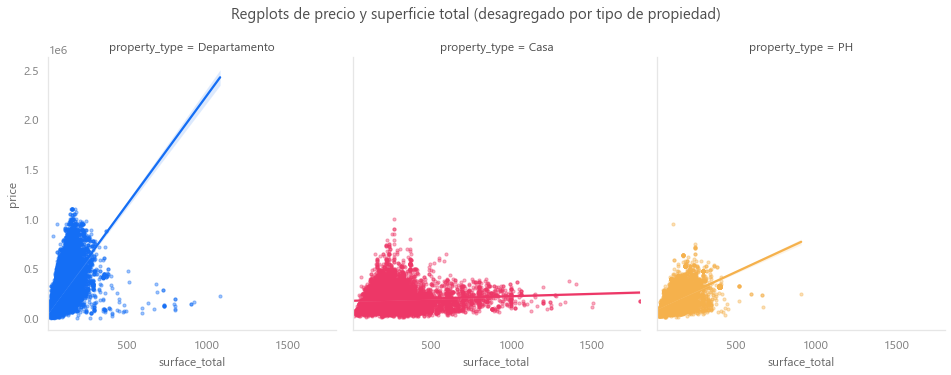

In [82]:
sns.lmplot(x='surface_total', 
           y='price',   
           data=data5,
           hue='property_type', 
           hue_order=['Departamento', 'Casa', 'PH'],
           col='property_type', 
           col_order=['Departamento', 'Casa', 'PH'],
           height=5, 
           aspect=.9, 
           scatter_kws={"s": 10, 'alpha': 0.4})

plt.suptitle('Regplots de precio y superficie total (desagregado por tipo de propiedad)', y=1.05, fontsize=15)

Como se observa, cada tipo de propieda tienen un tipo diferente de relación precio-superficie, siendo la casa la que menos correlación presenta entre superficie y precio. Estaría bien visualizar los mismo pero con respecto a cada tipo de zona o localidad de Buenos Aires.

In [83]:
pd.crosstab(data5['property_type'], data5['l2'], margins=True, margins_name='Total')

l2             Bs.As. G.B.A. Zona Norte  Bs.As. G.B.A. Zona Oeste  \
property_type                                                       
Casa                               3632                      3581   
Departamento                      14527                      5065   
PH                                 1507                      1474   
Total                             19666                     10120   

l2             Bs.As. G.B.A. Zona Sur  Capital Federal   Total  
property_type                                                   
Casa                             4302             1578   13093  
Departamento                     6291            70121   96004  
PH                               1334             8754   13069  
Total                           11927            80453  122166

De los resultados anteriores, podemos decir que el ratio de tipo de propiedad es más o menos símilar en Zona Oeste y Zona Sur, mientras que en Capital Federal y Zona Norte presentan un gran disparidad con la mayoría de las publicaciones siendo departamentos. Visualizemos esto en un diagrama de barras.

Text(0, 0.5, '')

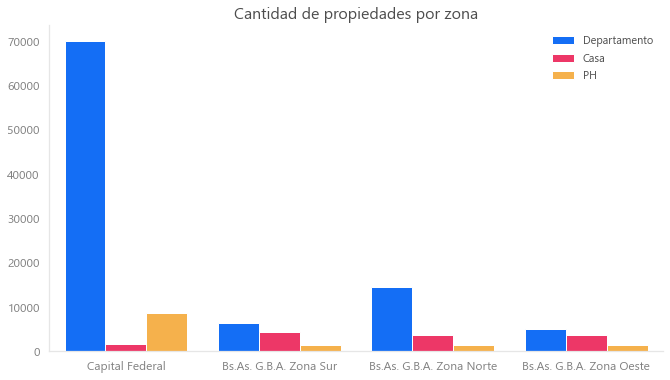

In [84]:
plt.figure(1, figsize=(11, 6))
sns.countplot(x='l2', data=data5, 
              hue='property_type', 
              hue_order=['Departamento', 'Casa', 'PH'],
              saturation=1)
plt.title('Cantidad de propiedades por zona')
plt.legend(frameon=False)
plt.xlabel('')
plt.ylabel('')

Ahora grafiquemos la regresión por localidad:

Text(0.5, 1.05, 'Regplots de precio y superficie total (desagregado por localidad)')

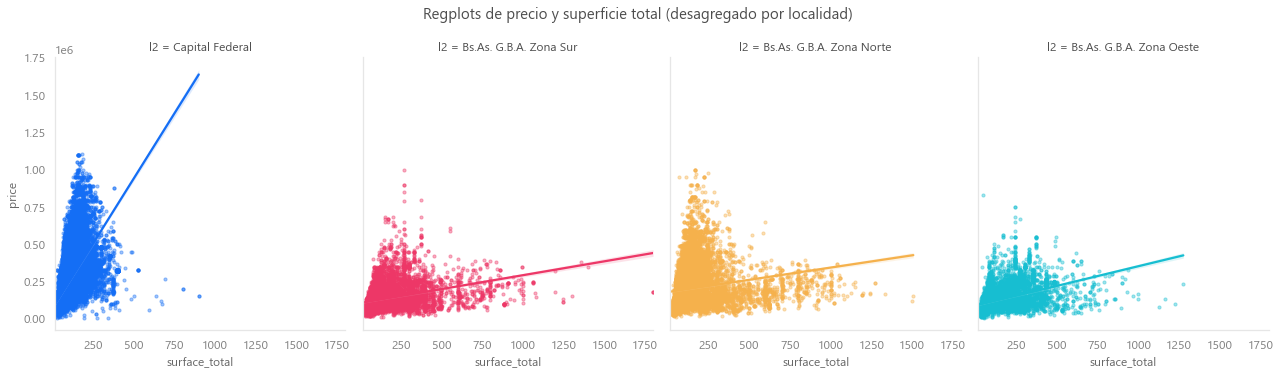

In [85]:
sns.lmplot(x='surface_total', y='price', hue='l2', col='l2', 
           height=5, aspect=.9,  data=data5, 
           scatter_kws={"s": 10, 'alpha': 0.4})
plt.suptitle('Regplots de precio y superficie total (desagregado por localidad)', y=1.05, fontsize=15)

Esto nos permite substraer algo importante: la correlación por tipo de zona depende en gran medida del ratio que esta tenga en cuanto al tipo de propiedad. Si miramos el caso de Capital Federal, debido a que sus publicaciones son mayoritariamente departamentos, su regplot se parece mucho al regplot de solo departamento. Por otro lado, Zona Norte al tener una cantidad considerable de casa, su regplot se parece bastante al regplot general de superficie total y precio.

¿Será menos preciso el modelo al predecir las propiedades que son casas, o en general las que están ubicadas de Zona Norte? Si solo usaramos el superficie tal quizás sí, pero aún nos quedan otras features por explorar.

In [86]:
def patch_violinplot(palette, n):
    from matplotlib.collections import PolyCollection
    ax = plt.gca()
    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    colors = sns.color_palette(palette, n_colors=n) * (len(violins)//n)
    for i in range(len(violins)):
        violins[i].set_edgecolor(colors[i])

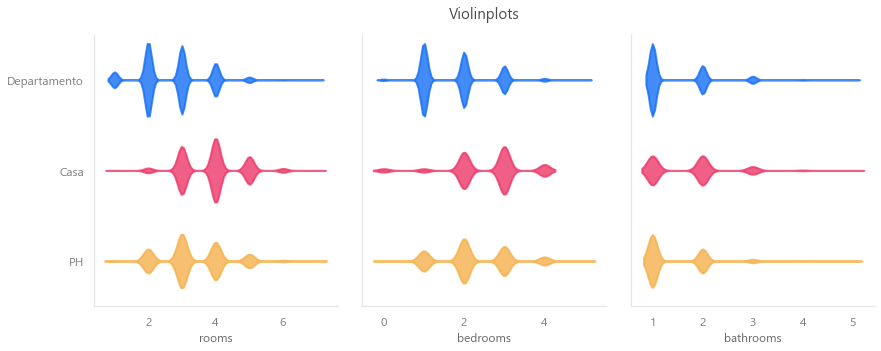

In [87]:
plt.figure(1, figsize=(14, 5))
n = 1
for cols in ['rooms', 'bedrooms', 'bathrooms']:
    plt.subplot(1, 3, n)
    plt.subplots_adjust(wspace=0.1)
    
    # Creamos el violin plot
    ax = sns.violinplot(x=cols, 
                        y='property_type', 
                        data=data5,
                        order=['Departamento', 'Casa', 'PH'],
                        inner=None, 
                        saturation=1, 
                        linewidth=2)
    plt.setp(ax.collections, alpha=0.8)
    patch_violinplot(Palette, 3)
    plt.title('Violinplots' if n == 2 else '', fontsize=15, pad=16 )
    plt.ylabel('')
    plt.yticks(None if n == 1 else [])
    n += 1
plt.show()

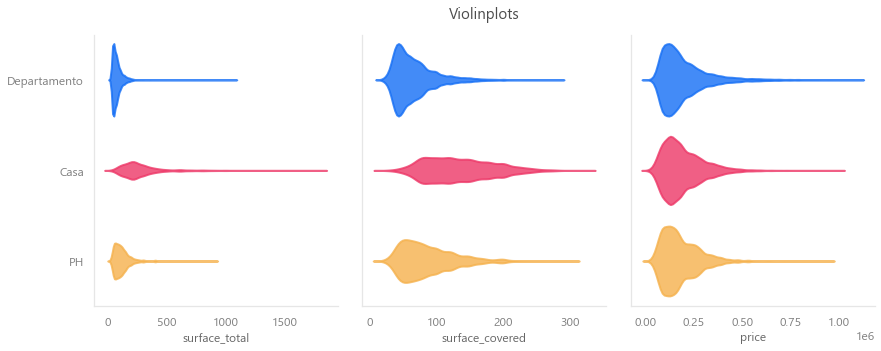

In [88]:
plt.figure(1, figsize=(14, 5))
n = 1
for cols in ['surface_total', 'surface_covered', 'price']:
    plt.subplot(1, 3, n)
    plt.subplots_adjust(wspace=0.1)
    
    # Creamos el violin plot
    ax = sns.violinplot(x=cols, 
                        y='property_type', 
                        data=data5,
                        order=['Departamento', 'Casa', 'PH'],
                        inner=None,
                        saturation=1, 
                        linewidth=2)
    plt.setp(ax.collections, alpha=0.8)
    patch_violinplot(Palette, 3)
    plt.title('Violinplots' if n == 2 else '', fontsize=15, pad=16 )
    plt.ylabel('')
    plt.yticks(None if n == 1 else [])
    n += 1
plt.show()

Los graficos de violin son extremadamente útiles para comparar distribución de variables númericas con relación a otra variable categórica. Podemos apreciar que los tipos de propiedad se distribuyen diferente en cada variable, pero especialmente en cuanto a sus superficies y al número de ambientes-habitaciones.

Las casas son en general más espaciosas pero no necesariamente más costosas. Esto quizá se deba a que la mayoría de las casas no está en al capital sino en las demas zonas de la provincia, mientras que los departamentos sí que lo están. Esto de alguna forma logra que se compense el precio y por ello la distribución de ambos tipos sean similares.

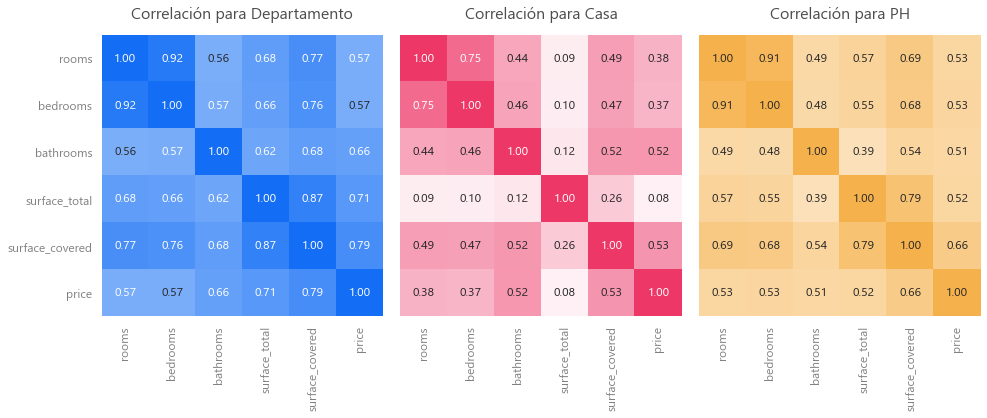

In [89]:
plt.figure(1, figsize=(14, 6))
n = 1

cmaps = [Blues, Reds, Ambers]

for i, tipo in enumerate(['Departamento', 'Casa', 'PH']):
    
    plt.subplot(1, 3, n)
    plt.subplots_adjust(wspace=0.1)
    
    corr = data5[data5.property_type == tipo].corr()
    sns.heatmap(data = corr, 
                cbar=False, 
                square=True, 
                annot=True, 
                fmt= '.2f', 
                annot_kws={'size': 12}, 
                xticklabels=corr.columns, 
                yticklabels= corr.columns, 
                cmap=cmaps[i], 
                vmin=0)
    
    plt.title('Correlación para {}'.format(tipo), pad=16)
    plt.xticks(rotation = 90)
    plt.yticks(None if n == 1 else [], rotation = 0)
    plt.tight_layout()
    n += 1
plt.show()

De estos heatmaps podemos observar que el tipo de propiedad Casa tiene una correlación general más baja que las de los otros tipos, por ello intuimos que el modelo se desempeñará peor en este caso.

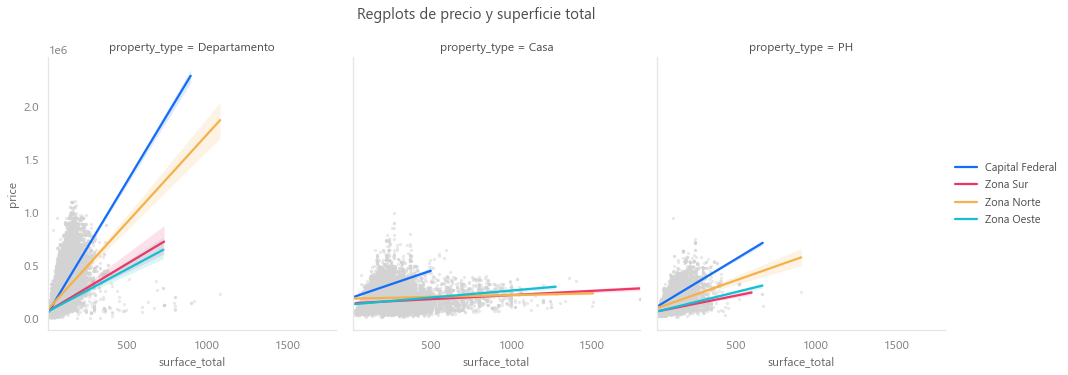

In [90]:
sns.lmplot(data=data5,
           x='surface_total', 
           y='price', 
           hue='l2', 
           col='property_type',
           col_order=['Departamento', 'Casa', 'PH'],
           height=5, 
           aspect=0.9,
           legend=False,
           scatter_kws={'color':'lightgrey', "s": 5, 'alpha': 0.4})

plt.suptitle('Regplots de precio y superficie total', y=1.05, fontsize=15)

plt.legend(title=None, 
           loc='center left', 
           labels=['Capital Federal', 'Zona Sur', 'Zona Norte', 'Zona Oeste'],
           bbox_to_anchor=(1, 0.5),
           frameon=False)

De este regplot combinado se puede sacar lo siguiente: 
1. Zona Sur y Zona Norte tiene comportamientos muy similares en cuanto precio-superficie total.
2. Capital Federal, como era de esperarse, tiende a tener los precio más precios más altos que las otras zonas aun teniendo menor superficie total
3. Departamento y PH tiene correlación positiva sin importar la zona en que se encuentren. 
4. Casa es completamente impredecible en casi todas las zonas, que varíe su perficie total no hace que varíe otros atributos como el precio, los ambientes, las habitaciones o los baños. Si se fueran a predecir solo casas probablemente descartaríamos esta variable antes de entrenar los modelos.

## 3.3 Ingeniería de atributos

### 3.3.1 Creación de nuevos atributos

In [91]:
data5['m2_price'] = data5['price']/data5['surface_covered']
data5['m2_price'] = data5['m2_price'].round(1)
data5.head(3)

l2       l3  rooms  bedrooms  bathrooms  surface_total  \
1  Capital Federal    Boedo    2.0       1.0        2.0           70.0   
2  Capital Federal  Palermo    2.0       1.0        1.0           45.0   
3  Capital Federal  Palermo    2.0       1.0        1.0           85.0   

   surface_covered     price property_type  m2_price  
1             58.0  159000.0            PH    2741.4  
2             45.0  125000.0            PH    2777.8  
3             50.0  295000.0            PH    5900.0

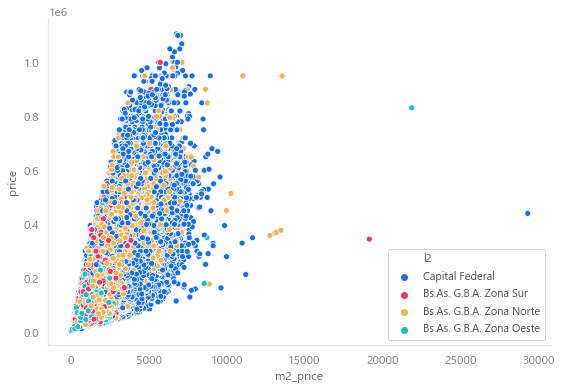

In [92]:
sns.scatterplot(x='m2_price', y='price', hue='l2', data=data5)

Se puede observar la presencia de cierto outliers que Isolation Forest no logró eliminar. Lo haremos manualmente:

In [93]:
data5 = data5.query('m2_price <= 12000')

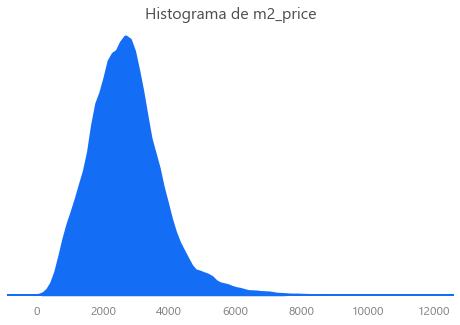

In [94]:
# Histograma
plt.figure(figsize=(8, 5))
sns.kdeplot(data5.m2_price, 
            shade=True, 
            alpha=1, 
            lw=2, 
            color=blue, 
            legend=False)
sns.kdeplot(data5.m2_price, 
            lw=4, 
            color=blue, 
            legend=False)
plt.axhline(y=0, lw=4)

plt.title('Histograma de m2_price')
plt.xlabel('')
plt.yticks(())
sns.despine(left=True, bottom=True)


In [95]:
m2 = data5.groupby(['l3']).mean().sort_values(by=['m2_price'], 
                                              ascending=False)['m2_price']
                                            
m2 = pd.DataFrame(m2.values, 
                  index=m2.index.rename(None), 
                  columns=['m2_price'])
m2

m2_price
Puerto Madero  5700.196837
Las Cañitas    4143.594118
Palermo        3688.487141
Belgrano       3662.521635
Nuñez          3629.895193
...                    ...
Hurlingham     1201.141176
Merlo          1198.044518
José C Paz     1136.769604
Villa Soldati  1072.273077
Marcos Paz     1022.257143

[89 rows x 1 columns]

In [96]:
m2.describe()

m2_price
count    89.000000
mean   2294.031270
std     782.410727
min    1022.257143
25%    1660.560690
50%    2280.039241
75%    2710.679491
max    5700.196837

In [97]:
bins = [0, 1600, 2600, 6000]
m2['m2_price_binned'] = pd.cut(m2['m2_price'], bins=bins, labels=['Clase baja', 'Clase media', 'Clase alta'])
m2

m2_price m2_price_binned
Puerto Madero  5700.196837      Clase alta
Las Cañitas    4143.594118      Clase alta
Palermo        3688.487141      Clase alta
Belgrano       3662.521635      Clase alta
Nuñez          3629.895193      Clase alta
...                    ...             ...
Hurlingham     1201.141176      Clase baja
Merlo          1198.044518      Clase baja
José C Paz     1136.769604      Clase baja
Villa Soldati  1072.273077      Clase baja
Marcos Paz     1022.257143      Clase baja

[89 rows x 2 columns]

In [98]:
clase_baja = list(m2[m2['m2_price_binned'] == 'Clase baja'].index)
clase_media = list(m2[m2['m2_price_binned'] == 'Clase media'].index)
clase_alta = list(m2[m2['m2_price_binned'] == 'Clase alta'].index)

In [99]:
data5['class'] = ['Clase baja' if x in clase_baja
                               else ('Clase media'
                                     if x in clase_media
                                     else 'Clase alta') for x in data5['l3']]

In [100]:
data5.head(7)

l2                l3  rooms  bedrooms  bathrooms  \
1         Capital Federal             Boedo    2.0       1.0        2.0   
2         Capital Federal           Palermo    2.0       1.0        1.0   
3         Capital Federal           Palermo    2.0       1.0        1.0   
4  Bs.As. G.B.A. Zona Sur          La Plata    2.0       1.0        1.0   
5         Capital Federal      Villa Crespo    2.0       1.0        1.0   
6         Capital Federal      Villa Crespo    2.0       1.0        1.0   
8         Capital Federal  Parque Patricios    1.0       1.0        1.0   

   surface_total  surface_covered     price property_type  m2_price  \
1           70.0             58.0  159000.0            PH    2741.4   
2           45.0             45.0  125000.0            PH    2777.8   
3           85.0             50.0  295000.0            PH    5900.0   
4           50.0             35.0   40000.0            PH    1142.9   
5           56.0             56.0  150000.0            PH    2678.6   
6           70.0             70.0  159500.0            PH    2278.6   
8           45.0             37.0   89000.0            PH    2405.4   

         class  
1  Clase media  
2   Clase alta  
3   Clase alta  
4   Clase baja  
5   Clase alta  
6   Clase alta  
8  Clase media

### 3.3.2 Transformación de variables

Algunos de los supuestos de los modelos multivariados como la regresión lineal son:
- __Normalidad__ - La distribución de la variable aleatoria es parecida al Normal.
- __Homocedasticidad__ - Que los errores tengan varianza constante. 
- __Linealidad__ - La relación entre diferentes variables es lineal y no polinómica.
- __Ausencia de errores correlacionados__ - Que los errores en la medición de las variables explicativas sean independientes entre sí.

Intentaremos transformar la variables que no tengan una distribución normal, y luego verificaremos el supuesto de la homocedasticidad.

#### 3.3.2.1 Normalidad

Para probar la normalidad de las variable usaremos histogramas para comparar asimetría y curtosis, y graficos de probabilidad normal.

In [101]:
def normality_test(data, variable):
    '''
    Dibuja un histograma a la izquierda y diagrama de cuantiles vs cuantiles a la derecha.
    
    data: DataFrame
    variable: (str) nombre de la variable a analizar
    
    '''
    #histogram and normal probability plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3)

    sns.distplot(data[variable], norm_hist=True, 
                 fit=stats.norm,
                 bins=25,
                 ax=ax1)
    ax1.set_title('Histogram')
    ax1.set_xlabel(variable)
    ax1.set_ylabel('Density')
    res = stats.probplot(data[variable], plot=ax2)

Vamos a realizar estos test y trnasformaciones en una copia de nuestro dataset ya que para la parte de modelado haremos toda esta parte de preprocesamiento dentro un pipeline.

In [102]:
data6 = data5.copy()

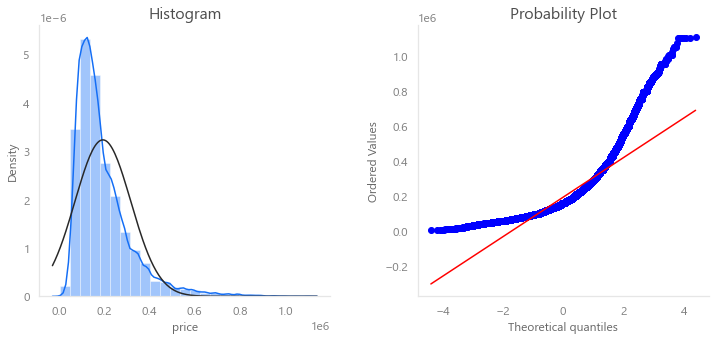

In [103]:
normality_test(data6, 'price')

__Price__ no es normal puesto que muestra una curtosis alta, asimetría positiva y no sigue la línea diagonal de Quantile vs Quantile plot (Probability Plot).
Transformaremos esta variable para intentar resolver el problema.

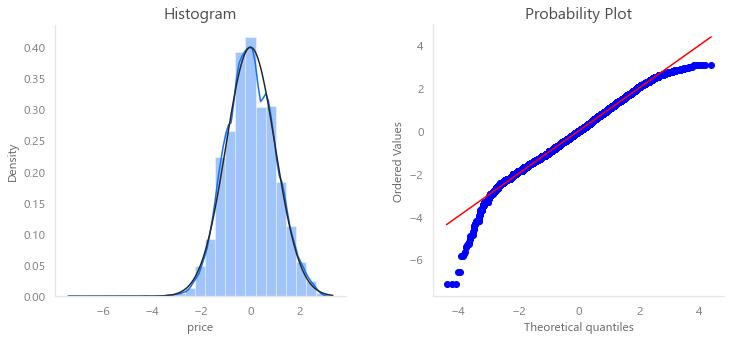

In [104]:
# Aplica transformación de 'yeo-johnson'
data6['price'] = PowerTransformer().fit_transform(data6[['price']])

# Hacemos la prueba nuevamente
normality_test(data6, 'price')

Nice! Ahora probemos superficie total:

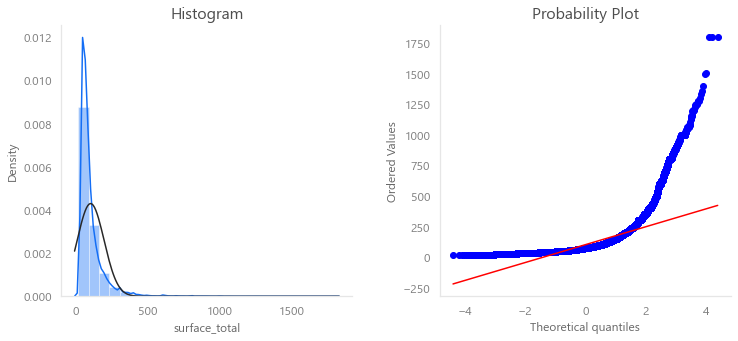

In [105]:
normality_test(data6, 'surface_total')

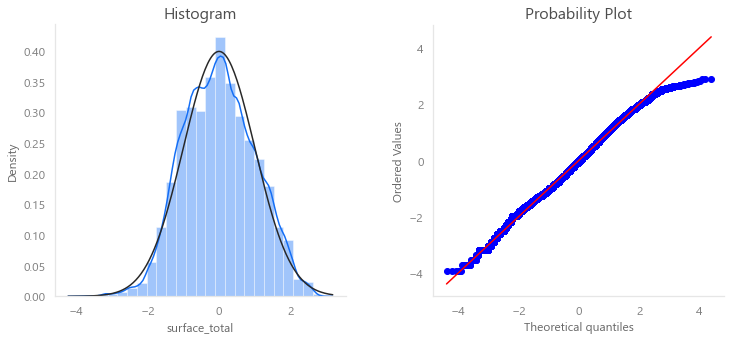

In [106]:
data6['surface_total'] = PowerTransformer(
).fit_transform(data6[['surface_total']])

normality_test(data6, 'surface_total')

Mejoró siginificativamente. Finalmente, superficie cubierta:

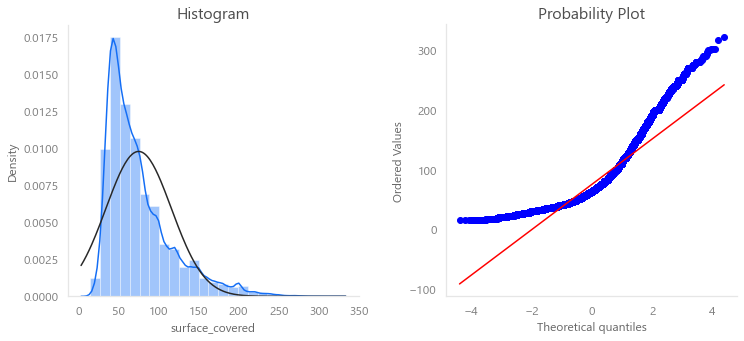

In [107]:
normality_test(data6, 'surface_covered')

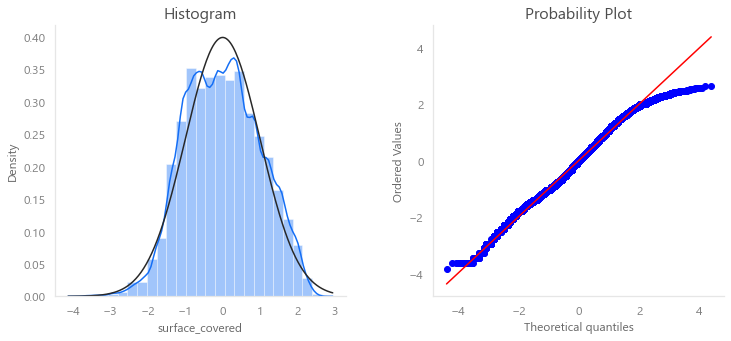

In [108]:
data6['surface_covered'] = PowerTransformer(
).fit_transform(data6[['surface_covered']])

normality_test(data6, 'surface_covered')

#### 3.3.2.2 Homocedasticidad

El mejor enfoque para probar la homocedasticidad para dos variables es gráficamente. Las desviaciones de una dispersión heterocedastica se muestran con formas como conos (pequeña dispersión en un lado del gráfico, gran dispersión en el lado opuesto) o rombos (un gran número de puntos en el centro de la distribución).

Comenzando por "price" y "surface_total"...

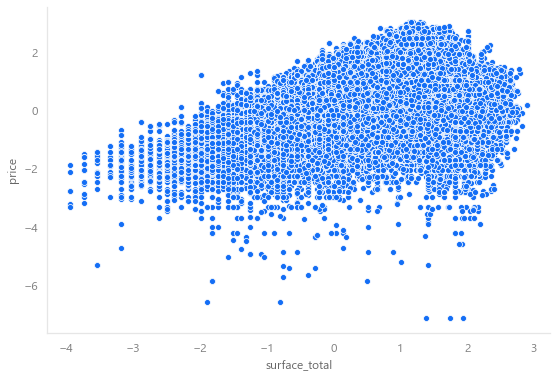

In [109]:
# Diagrama de dispersión 
sns.scatterplot(data6.surface_total, data6.price)

Las versiones anteriores de este gráfico de dispersión tenían una forma cónica (al inicio del análisis multivariado). Como se puede observar, el actual gráfico de dispersión ya no tiene una forma cónica. Sólo con asegurar la normalidad en algunas variables se resuelve el problema de la homocedasticidad.

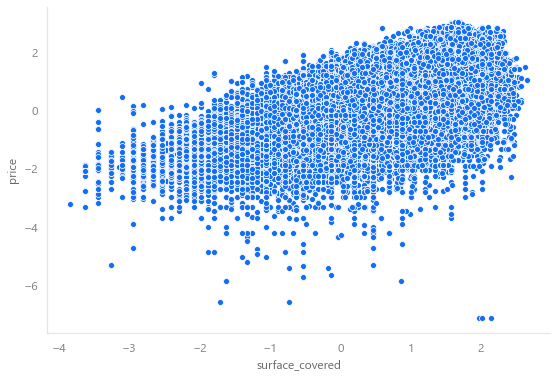

In [110]:
# Diagrama de dispersión 
sns.scatterplot(data6.surface_covered, data6.price)

Podemos decir que, en general, 'price' exhibe iguales niveles de varianza en todo el rango de 'surface_covered'.

##### <a id="04"></a>

# 4. Modelado

## 4.1 Modelo I: Baseline

El primer modelo es, naturalmente, el modelo más simple: siempre predecir el promedio de todos los precios.

In [111]:
X = data5.drop(columns=['price', 'm2_price'])
y = data5['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=100)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(97726, 9) (97726,) (24432, 9) (24432,)


In [112]:
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, y_train)

y_train_pred_dummy = dummy_regr.predict(X_train)
y_test_pred_dummy = dummy_regr.predict(X_test)

In [113]:
def metricas(y_train, y_train_pred, y_test, y_test_pred):
    '''
    Halla las métricas para problemas de regresión (RSME, MAE y R2).
    
    Paramentros
    ----------
    y_train: numpy array
        La variable objetivo para la parte Train.
        
    y_train_pred: numpy array
        La predicción del modelo con respecto a la parte Train.
        
    y_test: numpy array
        La variable objetivo para la parte Test.
        
    y_test_pred: numpy array
        La predicción del modelo con respecto a la parte Test.
    
    
    Regresa
    -------
        Imprime por pantalla todas las métricas
    
    
    Notas
    ------
    Liberías requeridas: 
        Scikit-Learn (métodos: mean_squared_error, mean_absolute_error, r2_score)
    
    '''
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'| RSME en Train: {rmse_train}')
    print(f'| RSME en Test: {rmse_test}')
    print(' ——————————————–––––––––-------')
    
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    print(f'| MAE en Train: {mae_train}')
    print(f'| MAE en Test: {mae_test}')
    print(' ——————————————–––––––––-------')
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f'| R2 en Train: {r2_train}')
    print(f'| R2 en Test: {r2_test}')   

In [114]:
metricas(y_train, y_train_pred_dummy, y_test, y_test_pred_dummy)

| RSME en Train: 123619.03745594245
| RSME en Test: 123257.04278094073
 ——————————————–––––––––-------
| MAE en Train: 89528.84394940991
| MAE en Test: 89529.82157585616
 ——————————————–––––––––-------
| R2 en Train: 0.0
| R2 en Test: -3.861898931534213e-06


In [115]:
def evaluar_modelo(y_train, y_train_pred, y_test, y_test_pred):
    '''
    Crea múltiples gráficos para evaluar el modelo visualmente.
    
    Paramentros
    ----------
    y_train: numpy array
        La variable objetivo para la parte Train.
        
    y_train_pred: numpy array
        La predicción del modelo con respecto a la parte Train.
        
    y_test: numpy array
        La variable objetivo para la parte Test.
        
    y_test_pred: numpy array
        La predicción del modelo con respecto a la parte Test.
    
    
    Regresa
    -------
        Matplotlib GridSpec
    
    
    Notas
    ------
    Liberías requeridas: Matplotlib, Seaborn.

    '''
    # Importa los métodos necesario
    from matplotlib.ticker import FuncFormatter
    from matplotlib.gridspec import GridSpec

    def kilos(x, pos):
        'The two args are the value and tick position'
        return '%3.0fK' % (x * 1e-3)
    formatter = FuncFormatter(kilos)
    
    
    fig = plt.figure(constrained_layout=False, figsize=(12, 9))
    widths = [5, 5]
    heights = [3, 5]
    gs = fig.add_gridspec(ncols=2, nrows=2, wspace=0.4, hspace=0.35,
                          width_ratios=widths,
                          height_ratios=heights)
    
    
    # Histograma de errores
    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_title('Histograma de errores')
    train_errors = y_train - y_train_pred
    test_errors = y_test - y_test_pred
    rango = (min(np.min(train_errors), 
                 np.min(test_errors)),
             max(np.max(train_errors), 
                 np.max(test_errors)))        
    sns.distplot(train_errors, kde=False, bins=45, label='Train', 
                 hist_kws={'range': rango, 'alpha': 1}, 
                 ax=ax1)
    sns.distplot(test_errors, kde=False, bins=45, label='Test',
                 hist_kws={'range': rango, 'alpha': 1},
                 ax=ax1)
    ax1.set_ylabel('Cantidad')
    ax1.set_xlabel('Error')
    ax1.legend(fancybox=True, loc='right')
    ax1.xaxis.set_major_formatter(formatter)
    
    # Gráfico de residuales
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_title('Gráfico de residuales')
    ax2.scatter(y_train_pred,  y_train_pred - y_train,
               s=25, edgecolor='white', linewidths=0.5, alpha=1,
               label='Train')
    ax2.scatter(y_test_pred, y_test_pred - y_test, 
               s=25, edgecolor='white', linewidths=0.5, alpha=1,
               label='Test')
    ax2.hlines(y=0, 
               xmin=np.min(ax2.get_xlim()), 
               xmax=np.max(ax2.get_xlim()), 
               color='black', alpha=0.9,
               lw=2)
    ax2.set_xlabel('Valores predichos')
    ax2.set_ylabel('Residuos')
    ax2.legend(fancybox=True, loc='lower right')
    ax2.xaxis.set_major_formatter(formatter)
    ax2.yaxis.set_major_formatter(formatter)
    
    
    # Gráfico de y vs y predicho
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.set_title('Gráfico de error de predicción')
    ax3.scatter(y_test, y_test_pred, color=red,
                s=25, edgecolor='white', linewidths=0.5, alpha=1)
    lims = [np.min([ax3.get_xlim(), ax3.get_ylim()]),
            np.max([ax3.get_xlim(), ax3.get_ylim()])] 
    ax3.plot(lims, lims, '-k',  alpha=1, lw=2, label='Identidad')
    sns.regplot(y_test, y_test_pred, scatter=False, ci=None,
                color='black', label='Mejor ajuste',
                line_kws={'ls': '--', 'alpha':0.6, 'lw':2})
    ax3.set_xlabel('Valores reales (test)')
    ax3.set_ylabel('Valores predichos (test)')
    ax3.legend(fancybox=True, loc='lower right')
    ax3.xaxis.set_major_formatter(formatter)
    ax3.yaxis.set_major_formatter(formatter)

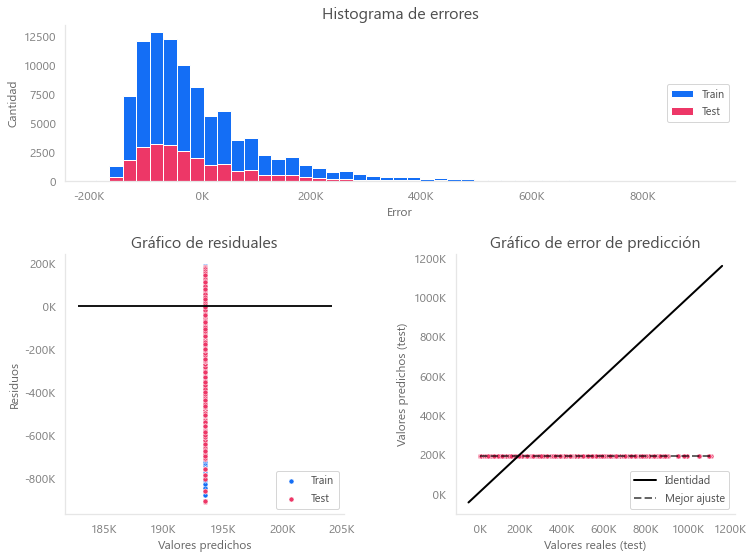

In [116]:
evaluar_modelo(y_train, y_train_pred_dummy, y_test, y_test_pred_dummy)

Notese que el histograma de errores sigue la misma distribución que la variable precio, como hay pocas propiedades por debajo de la media (hacia cero) y muchas por encima (hacia +inf), entonces se crea esa distribución con la cola larga y una asimetría positiva. 

## 4.2 Modelo II: Arbol de decisión

Este modelo no solo nos servirá para comparar con el proyecto del bloque 1 sino tambien para comparar contra otros modelos del notebook: regresión lineal, bosques aleatorios, XGBoosts, etc.

In [117]:
# Seleccionamos las columnas
numerical_columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
categorical_columns = ['l2', 'property_type', 'class']

# Instanciamos el preprocesador
preprocessor = make_column_transformer((StandardScaler(), numerical_columns),
                                       (OneHotEncoder(), categorical_columns))

In [118]:
# Define las listas vacias para los valores de RMSE deseados
rmse_train_tree = []
rmse_test_tree = []

# Define la lista de valores de k que va a explorar
n_nodes = np.arange(1, 30, 2, dtype=int)

for n in n_nodes:
    tree = DecisionTreeRegressor(max_depth= n)
    pipeline_tree = make_pipeline(preprocessor, tree)
    pipeline_tree.fit(X_train, y_train)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = pipeline_tree.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = pipeline_tree.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    print('Profundidad: {}, RSME: {}'.format(n, test_rmse))
    # Agregar la información a las listas
    rmse_train_tree.append(train_rmse)
    rmse_test_tree.append(test_rmse)

Profundidad: 1, RSME: 102003.15336679846
Profundidad: 3, RSME: 78321.74964526026
Profundidad: 5, RSME: 68428.71478618777
Profundidad: 7, RSME: 64846.36418487249
Profundidad: 9, RSME: 61783.36781833108
Profundidad: 11, RSME: 59041.64511414529
Profundidad: 13, RSME: 57724.274945397134
Profundidad: 15, RSME: 56546.78911160524
Profundidad: 17, RSME: 56163.63808124534
Profundidad: 19, RSME: 56144.368264882825
Profundidad: 21, RSME: 55959.861496418984
Profundidad: 23, RSME: 55559.98756434875
Profundidad: 25, RSME: 55560.20392876784
Profundidad: 27, RSME: 55986.60740156573
Profundidad: 29, RSME: 55860.2646256648


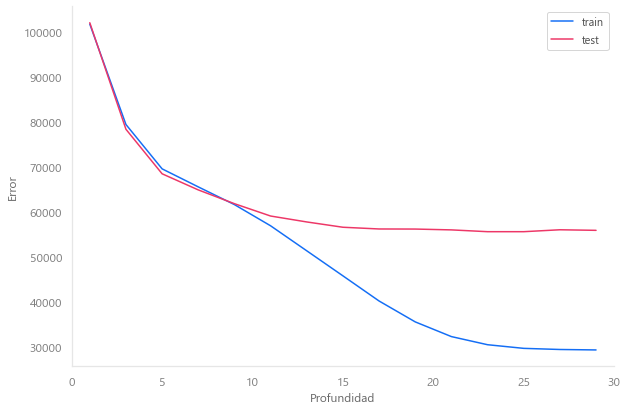

In [119]:
plt.plot(n_nodes, rmse_train_tree, label='train')
plt.plot(n_nodes, rmse_test_tree, label='test')
plt.legend(loc='best')
plt.xlim(xmin=0, xmax=30)
plt.xlabel('Profundidad')
plt.ylabel('Error')
plt.tight_layout()
sns.despine()

In [120]:
tree = DecisionTreeRegressor(max_depth= 10)
pipeline_tree = make_pipeline(preprocessor, tree)
pipeline_tree.fit(X_train, y_train)
y_train_pred_tree = pipeline_tree.predict(X_train)
y_test_pred_tree = pipeline_tree.predict(X_test)

Definimos una función para evaluar las diferentes métricas de regresión.

In [121]:
metricas(y_train, y_train_pred_tree, y_test, y_test_pred_tree)

| RSME en Train: 59292.60919788497
| RSME en Test: 60116.09260882732
 ——————————————–––––––––-------
| MAE en Train: 37745.20957458222
| MAE en Test: 38345.09742565395
 ——————————————–––––––––-------
| R2 en Train: 0.7699456715964437
| R2 en Test: 0.7621190417882623


Definimos una función para evaluar los gráficos

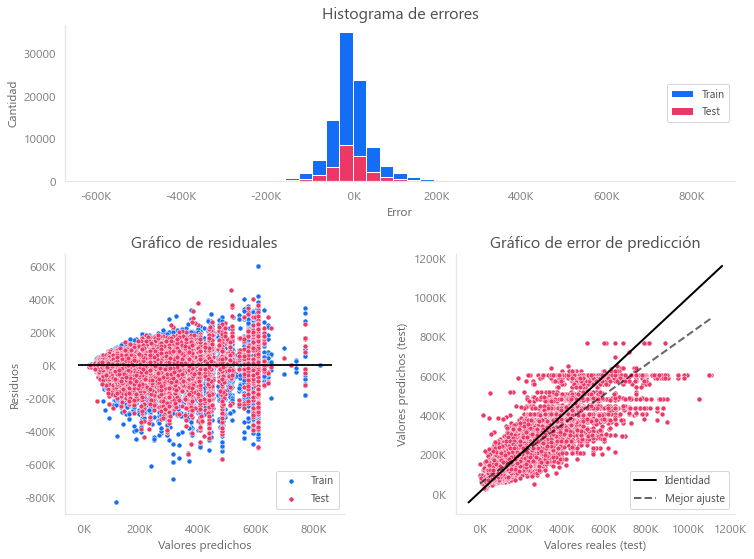

In [122]:
evaluar_modelo(y_train, y_train_pred_tree, y_test, y_test_pred_tree)

Escribir analisis de los resultados y comparación con el modelo del proyecto 1

## 4.3 Modelo III: Regresión lineal con Lasso

__Creamos el pipeline__

In [123]:
# Seleccionamos las columnas
discrete_columns = ['rooms', 'bedrooms', 'bathrooms']
continous_columns = ['surface_total', 'surface_covered']
categorical_columns = ['l2', 'property_type', 'class']

# Instanciamos el preprocesador
preprocessor = make_column_transformer((StandardScaler(), discrete_columns),
                                       (PowerTransformer(), continous_columns),
                                       (OneHotEncoder(), categorical_columns))

# Instanciamos el regresor
regressor = LassoCV(alphas=np.logspace(-5, 0, 15), 
                    max_iter=1000, 
                    tol=0.1,
                    cv=3,
                    random_state=100,
                    n_jobs=-1,
                    verbose=1
                   )
transformer = PowerTransformer()
tt = TransformedTargetRegressor(regressor=regressor, transformer=transformer)

# Instaciamos el pipeline
pipeline_lasso = make_pipeline(preprocessor, tt)

__Entrenamos y evaluamos__

In [124]:
pipeline_lasso.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
.............................................[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['rooms', 'bedrooms',
                                                   'bathrooms']),
                                                 ('powertransformer',
                                                  PowerTransformer(),
                                                  ['surface_total',
                                                   'surface_covered']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['l2', 'property_type',
                                                   'class'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=LassoCV(alphas=array([1.00000000e-

In [125]:
pipeline_lasso[-1].regressor_.alpha_

1e-05

In [126]:
y_train_pred_lasso = pipeline_lasso.predict(X_train)
y_test_pred_lasso = pipeline_lasso.predict(X_test)

In [127]:
metricas(y_train, y_train_pred_lasso, y_test, y_test_pred_lasso)

| RSME en Train: 68707.27872051393
| RSME en Test: 67963.38942514358
 ——————————————–––––––––-------
| MAE en Train: 43378.30095386922
| MAE en Test: 42955.52742681668
 ——————————————–––––––––-------
| R2 en Train: 0.691087999242912
| R2 en Test: 0.6959617327531995


__Comparamos las importancias de las variables__

In [128]:
feature_names = (pipeline_lasso.named_steps['columntransformer']
                               .named_transformers_['onehotencoder']
                               .get_feature_names(input_features=categorical_columns))

feature_names = np.concatenate([discrete_columns, 
                                continous_columns, 
                                feature_names])

coefs = pd.DataFrame(pipeline_lasso.named_steps['transformedtargetregressor']
                                   .regressor_.coef_,
                     columns=['Coefficients'], index=feature_names)

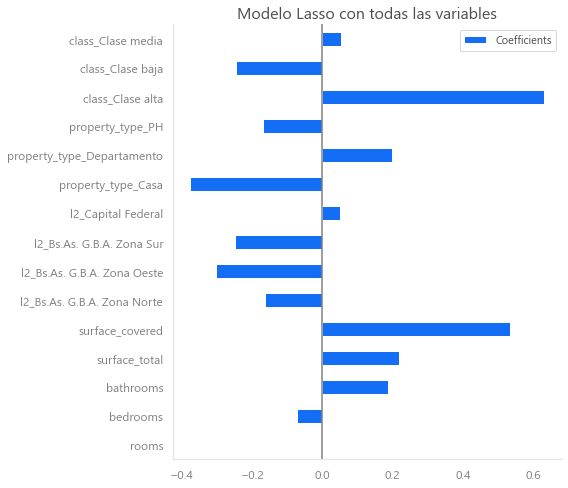

In [129]:
coefs.plot(kind='barh', figsize=(9, 8))
plt.title('Modelo Lasso con todas las variables')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Si comparamos con el heatmap de nuestro dataset podemos notar que la selección de variables de Lasso es adecuada

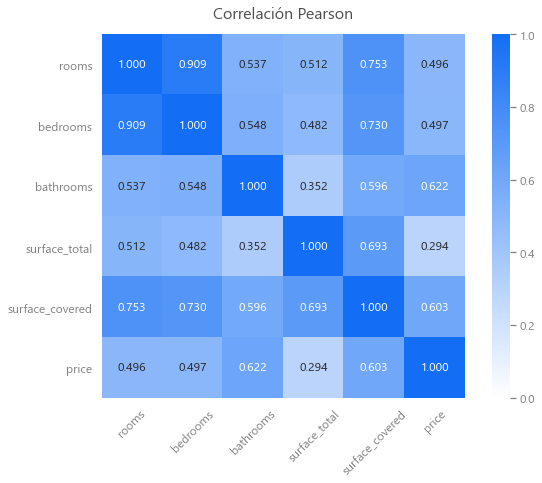

In [130]:
# Creamos un heatmap
plt.figure(figsize=(9, 7))
columns = ['rooms', 'bedrooms', 'bathrooms', 
           'surface_total', 'surface_covered', 'price']

corr = data5[columns].corr()

sns.heatmap(data = corr, cbar=True, square=True, annot=True, 
            fmt= '.3f', annot_kws={'size': 12}, 
            xticklabels= corr.columns, yticklabels= corr.columns, 
            cmap=Blues, vmin=0)

plt.title('Correlación Pearson', pad=16)
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

Del anterior heatmap podemos obtener toda la información que necesatimos para seleccionar.
- Rooms y Bedrooms presentan alta correlación entre ellas mismas y una correlación muy similar con Price.
- Con surface_total y surface_covered sucede lo mismo en el anterior punto. Solo que acá una de las dos tiene una correlación más alta que la otra con relación a price.
- Bathrooms parece particularmente util porque no tiene la menor correlacion general con las demás variables pero a su vez una alta correlación con price.

Con lo anterior podemos sacar un ranking de las mejora variables predictoras:
1. __surface_covered__
2. __bathrooms__
3. bedrooms
4. rooms
5. surface_total

### 4.3.1 Lasso eliminando variables correlacionadas

In [131]:
# Seleccionamos las columnas
discrete_columns = ['bathrooms']
continous_columns = ['surface_covered']
categorical_columns = ['l2', 'property_type', 'class']

# Instanciamos el preprocesador
preprocessor = make_column_transformer((StandardScaler(), discrete_columns),
                                       (PowerTransformer(), continous_columns),
                                       (OneHotEncoder(), categorical_columns))

# Instanciamos el regresor
regressor = LassoCV(alphas=np.logspace(-4, 1, 10), 
                    max_iter=1000, 
                    tol=0.1,
                    cv=3,
                    random_state=100,
                    n_jobs=-1,
                    verbose=0
                   )
transformer = PowerTransformer()
tt = TransformedTargetRegressor(regressor=regressor, transformer=transformer)

# Instaciamos el pipeline
pipeline_lasso_b = make_pipeline(preprocessor, tt)

In [132]:
pipeline_lasso_b.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['bathrooms']),
                                                 ('powertransformer',
                                                  PowerTransformer(),
                                                  ['surface_covered']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['l2', 'property_type',
                                                   'class'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=LassoCV(alphas=array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940

In [133]:
pipeline_lasso_b[-1].regressor_.alpha_

0.0001

In [134]:
y_train_pred_lasso_b = pipeline_lasso_b.predict(X_train)
y_test_pred_lasso_b = pipeline_lasso_b.predict(X_test)

In [135]:
metricas(y_train, y_train_pred_lasso_b, y_test, y_test_pred_lasso_b)

| RSME en Train: 69489.95866459954
| RSME en Test: 68772.33714592812
 ——————————————–––––––––-------
| MAE en Train: 44029.219375568224
| MAE en Test: 43655.51388643791
 ——————————————–––––––––-------
| R2 en Train: 0.6840099618714803
| R2 en Test: 0.6886809068242175


In [136]:
feature_names = (pipeline_lasso_b.named_steps['columntransformer']
                               .named_transformers_['onehotencoder']
                               .get_feature_names(input_features=categorical_columns))

feature_names = np.concatenate([discrete_columns, 
                                continous_columns, 
                                feature_names])

coefs_b = pd.DataFrame(pipeline_lasso_b.named_steps['transformedtargetregressor']
                                   .regressor_.coef_,
                     columns=['Coefficients'], index=feature_names)

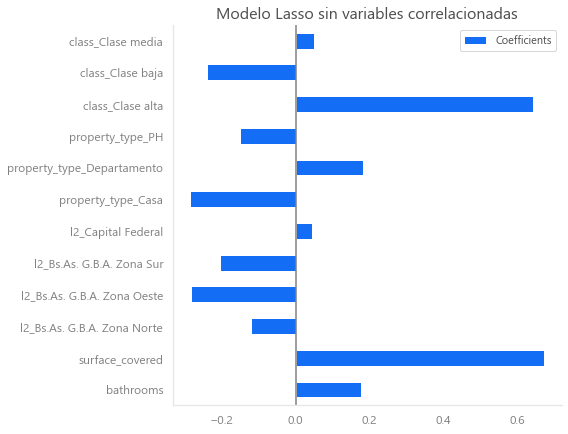

In [137]:
coefs_b.plot(kind='barh', figsize=(9, 7))
plt.title('Modelo Lasso sin variables correlacionadas')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Podemos notar que el error apenas aumentó, lo que confirma aún más el hecho de que no son necesarios para predecir el precio. Su importancia fue absorbida por la variables correlacionadas respectivas.

## 4.4 Modelo IV: Atributos polinómicos

### 4.4.1 Busqueda del _degree_ optimo

__Creamos el pipeline__

In [138]:
discrete_columns = ['rooms', 'bedrooms', 'bathrooms']
continous_columns = ['surface_total', 'surface_covered']


scaler = make_column_transformer((StandardScaler(), discrete_columns),
                                 (PowerTransformer(), continous_columns),
                                  remainder= 'passthrough')

final_columns = discrete_columns + continous_columns \
                + ['l2', 'l3', 'property_type', 'class']                 

X_train_poly = pd.DataFrame(scaler.fit_transform(X_train), 
                            columns=final_columns)
X_test_poly = pd.DataFrame(scaler.transform(X_test), 
                           columns=final_columns)

In [139]:
# Seleccionamos las columnas
numerical_columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
categorical_columns = ['l2', 'property_type', 'class']

# Instanciamos el preprocesador
preprocessor = make_column_transformer((PolynomialFeatures(), numerical_columns),
                                       (OneHotEncoder(), categorical_columns))

# Regresor 
regressor = LinearRegression()
transformer = PowerTransformer()
tt = TransformedTargetRegressor(regressor=regressor, transformer=transformer)

# Pipeline
pipeline_poly = make_pipeline(preprocessor, tt)

# GridSearch
params = {'columntransformer__polynomialfeatures__degree': [1, 2, 3, 4, 5]}

gs2 = GridSearchCV(estimator=pipeline_poly,
                  param_grid=params,
                  scoring='neg_root_mean_squared_error',
                  cv=5)

__Entrenamos__

In [140]:
gs2.fit(X_train_poly, y_train)
gs2.best_score_

-66701.26177405409

In [141]:
gs2.best_params_

{'columntransformer__polynomialfeatures__degree': 4}

In [142]:
resultados = pd.DataFrame(gs2.cv_results_)
resultados

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.332240      0.013692         0.036403        0.002499   
1       0.371543      0.042077         0.041833        0.004161   
2       0.566145      0.044377         0.066805        0.004916   
3       1.170885      0.125490         0.104910        0.008902   
4       1.775757      0.123082         0.136126        0.012726   

  param_columntransformer__polynomialfeatures__degree  \
0                                                  1    
1                                                  2    
2                                                  3    
3                                                  4    
4                                                  5    

                                              params  split0_test_score  \
0  {'columntransformer__polynomialfeatures__degre...      -67293.381914   
1  {'columntransformer__polynomialfeatures__degre...      -66010.796422   
2  {'columntransformer__polynomialfeatures__degre...      -65496.979963   
3  {'columntransformer__polynomialfeatures__degre...      -65213.975815   
4  {'columntransformer__polynomialfeatures__degre...      -65081.497451   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0      -68111.689699      -70346.521326      -68529.946414      -6.923170e+04   
1      -66615.103798      -68903.438678      -67195.332602      -6.806439e+04   
2      -66105.987122      -68477.683962      -66723.202255      -6.798652e+04   
3      -65865.737057      -68320.895549      -66441.708665      -6.766399e+04   
4      -65781.416288      -69576.366563      -67206.723614      -2.896102e+06   

   mean_test_score  std_test_score  rank_test_score  
0    -68702.648687    1.034148e+03                4  
1    -67357.811467    1.027684e+03                3  
2    -66958.074805    1.120975e+03                2  
3    -66701.261774    1.142589e+03                1  
4   -632749.672888    1.131677e+06                5

Ahora graficamos el promedio ya desviación de cada degree y así poder elegir uno.

In [143]:
df_splits = resultados.filter(regex='split')

errors = pd.DataFrame(columns=['Degree', 'Split error'])

for i in [0, 1, 2, 3, 4]:
    dicc = {'Degree': 'Degree {}'.format(i+1),
            'Split error': np.abs(df_splits.loc[i, :].values)}
    errors = pd.concat([errors, pd.DataFrame(dicc)], axis=0)

(64000.0, 75000.0)

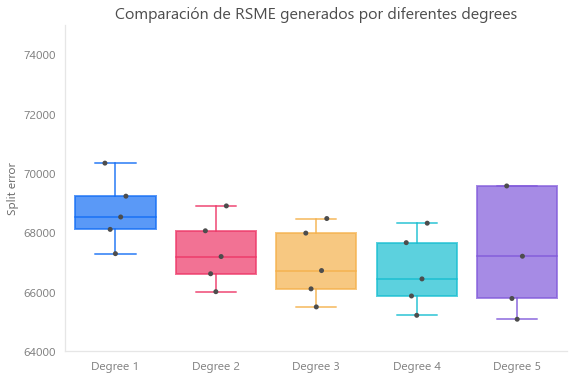

In [144]:
ax = sns.boxplot(x='Degree', y='Split error', data=errors, 
                 saturation=1, whis=3, linewidth=2, boxprops=dict(alpha=.7))

for i, artist in enumerate(ax.artists):
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

ax = sns.swarmplot(x='Degree', y='Split error', data=errors, color=".3")
ax.set_title('Comparación de RSME generados por diferentes degrees')
ax.set_xlabel('')
ax.set_ylim((64000, 75000))

Si bien, el GridSearch encontró que el mejor grado era el 4, este en realidad no tiene una mejora significativa frente a los otros modelos. Evaluaremos este modelo, pero el que escogeremos será el de grado 2 porque es mucho más simple y porque su mejora frente al grado 1 está bastante bien.

__Predecimos y evaluamos__

In [145]:
model2 = gs2.best_estimator_
model2.fit(X_train_poly, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=4),
                                                  ['rooms', 'bedrooms',
                                                   'bathrooms', 'surface_total',
                                                   'surface_covered']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['l2', 'property_type',
                                                   'class'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=LinearRegression(),
                                            transformer=PowerTransformer()))])

In [146]:
y_train_pred_2 = model2.predict(X_train_poly)
y_test_pred_2 = model2.predict(X_test_poly)

In [147]:
metricas(y_train, y_train_pred_2, y_test, y_test_pred_2)

| RSME en Train: 66576.28202476326
| RSME en Test: 65594.54285537817
 ——————————————–––––––––-------
| MAE en Train: 42060.91884583026
| MAE en Test: 41513.544304602154
 ——————————————–––––––––-------
| R2 en Train: 0.7099530112766348
| R2 en Test: 0.7167867230986689


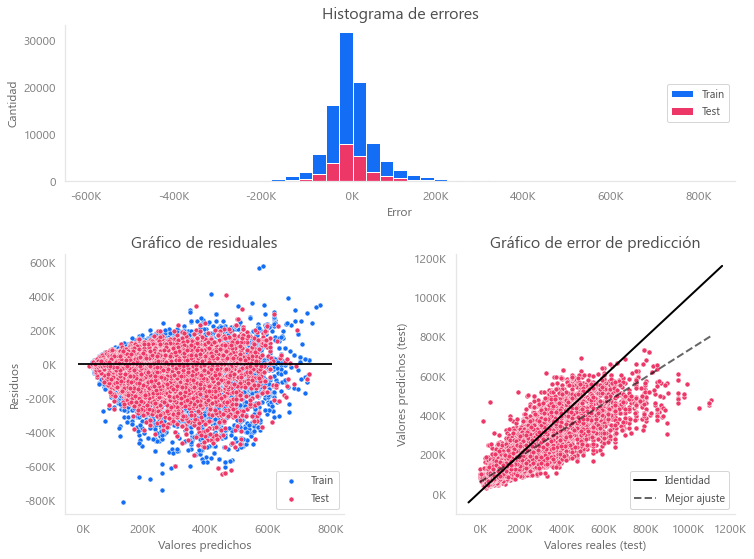

In [148]:
evaluar_modelo(y_train, y_train_pred_2, y_test, y_test_pred_2)

### 4.4.2 Busqueda del _alpha_ optimo

Si bien el grado cuatro se compartaba bien, nos quedaremos con grado 2 porque presenta buenos resultados, es estable y simple.

__Creamos el pipeline__

In [149]:
numerical_columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
categorical_columns = ['l2', 'property_type', 'class']

preprocessor = make_column_transformer((PolynomialFeatures(degree=2), numerical_columns),
                                       (OneHotEncoder(), categorical_columns))

regressor = Lasso(max_iter=1000, 
                  tol=0.1,
                  random_state=100)

transformer = PowerTransformer()
tt = TransformedTargetRegressor(regressor=regressor, transformer=transformer)

pipeline_poly_2 = make_pipeline(preprocessor, tt)

__Corremos un RandomizedSearch__

In [150]:
alpha_range = np.logspace(-10, 1, 100)

params = {'transformedtargetregressor__regressor__alpha': alpha_range}

rs = RandomizedSearchCV(estimator=pipeline_poly_2,
                        param_distributions=params,
                        scoring='neg_root_mean_squared_error',
                        cv=3, 
                        n_iter=10,
                        random_state=100,
                        n_jobs=-1,
                        verbose=2
                       )

In [151]:
rs.fit(X_train_poly, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   31.6s finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('polynomialfeatures',
                                                                               PolynomialFeatures(),
                                                                               ['rooms',
                                                                                'bedrooms',
                                                                                'bathrooms',
                                                                                'surface_total',
                                                                                'surface_covered']),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(),
                                          

In [152]:
print('Mejores parametros en el set de entrenamiento:', '\n')
print(rs.best_params_)
print()
print('Lista de scores en el set de entrenamiento:', '\n')
results = pd.DataFrame(rs.cv_results_)
results = results.astype({'param_transformedtargetregressor__regressor__alpha': 'float'})
results.sort_values(by=['param_transformedtargetregressor__regressor__alpha'], inplace=True)
means = results['mean_test_score'].values
stds = results['std_test_score'].values
alphas = results['param_transformedtargetregressor__regressor__alpha'].values
for mean, std, alpha in zip(means, stds, alphas):
    print('{:.2f} (+/{:.2f}) para alpha = {:.3e}'.format(-mean, -std * 5, alpha))  
print()

print("Evaluación completa con el mejor modelo hallado:", '\n')
model3 = rs.best_estimator_
model3.fit(X_train_poly, y_train)
y_train_pred_3 = model3.predict(X_train_poly)
y_test_pred_3 = model3.predict(X_test_poly)
metricas(y_train, y_train_pred_3, y_test, y_test_pred_3)

Mejores parametros en el set de entrenamiento: 

{'transformedtargetregressor__regressor__alpha': 2.1544346900318822e-08}

Lista de scores en el set de entrenamiento: 

67358.81 (+/-4470.71) para alpha = 2.154e-08
67358.82 (+/-4470.71) para alpha = 5.995e-08
67358.82 (+/-4470.72) para alpha = 7.743e-08
67358.87 (+/-4470.77) para alpha = 4.642e-07
67358.91 (+/-4470.82) para alpha = 7.743e-07
67358.94 (+/-4470.85) para alpha = 1.000e-06
67358.98 (+/-4470.90) para alpha = 1.292e-06
67359.31 (+/-4471.29) para alpha = 3.594e-06
67489.43 (+/-4405.19) para alpha = 7.743e-04
75452.39 (+/-6346.36) para alpha = 3.594e-02

Evaluación completa con el mejor modelo hallado: 

| RSME en Train: 67339.10239964012
| RSME en Test: 66478.76517877117
 ——————————————–––––––––-------
| MAE en Train: 42565.592659056834
| MAE en Test: 42068.14655797094
 ——————————————–––––––––-------
| R2 en Train: 0.7032683094299529
| R2 en Test: 0.7090997613424848


Gracias a esa busqueda podemos estimar un alpha optimo, donde haya compesación entre la simplificación del modelo y se mentaga un error cercano al modelo original. Para nuestro caso un $ Alpha = 3.594e-6$ funcionará bien.

In [153]:
numerical_columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
categorical_columns = ['l2', 'property_type', 'class']

preprocessor = make_column_transformer((PolynomialFeatures(degree=2), numerical_columns),
                                       (OneHotEncoder(), categorical_columns))

regressor = Lasso(alpha=3.594e-6,
                  max_iter=1000, 
                  tol=0.1,
                  random_state=100)

transformer = PowerTransformer()
tt = TransformedTargetRegressor(regressor=regressor, transformer=transformer)

pipeline_lasso_3 = make_pipeline(preprocessor, tt)

In [154]:
pipeline_lasso_3.fit(X_train_poly, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  ['rooms', 'bedrooms',
                                                   'bathrooms', 'surface_total',
                                                   'surface_covered']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['l2', 'property_type',
                                                   'class'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(regressor=Lasso(alpha=3.594e-06,
                                                            random_state=100,
                                                            tol=0.1),
                                            tran

In [155]:
y_train_pred_lasso_3 = pipeline_lasso_3.predict(X_train_poly)
y_test_pred_lasso_3 = pipeline_lasso_3.predict(X_test_poly)

In [156]:
metricas(y_train, y_train_pred_lasso_3, y_test, y_test_pred_lasso_3)

| RSME en Train: 67339.7205827266
| RSME en Test: 66479.2246560267
 ——————————————–––––––––-------
| MAE en Train: 42565.89465730248
| MAE en Test: 42068.47867276396
 ——————————————–––––––––-------
| R2 en Train: 0.703262861321862
| R2 en Test: 0.7090957401334614


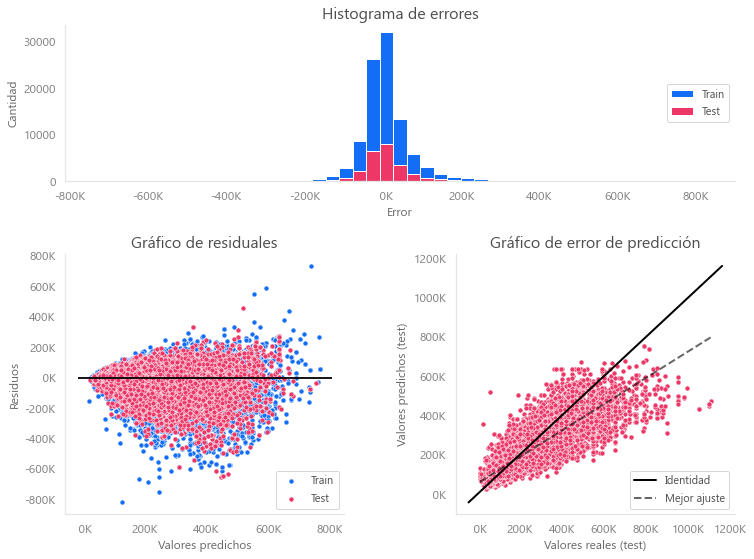

In [157]:
evaluar_modelo(y_train, y_train_pred_lasso_3, y_test, y_test_pred_lasso_3)

## 4.5 Modelo V: Bosques aleatorios

### 4.5.1 Random Search

Cuando estamos optimizando los hiperparámetros del modelo y utilizamos la misma estrategia de k-Fold CV para ajustar hiperparametros y para evaluar el rendimiento, se corre el riesgo de sobreajustar. No queremos estimar la precisión de nuestro modelo en la misma división para la que encontramos los mejores hiperparámetros.

En su lugar, utilizamos una estrategia de validación cruzada anidada que permite separar el paso de ajuste del hiperparámetro del paso de estimación del error. Para hacer esto, anidamos dos bucles de validación cruzada:
- El bucle interno para la sintonización del hiperparámetro y
- el bucle exterior para estimar la precisión.

<img src="attachment:image.png" alt="Nested CV" style="width: 600px;"/>

In [158]:
# Creamos el preprocesador 
numerical_columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
categorical_columns = ['l2', 'property_type', 'class']

preprocessor = make_column_transformer((StandardScaler(), numerical_columns),
                                       (OneHotEncoder(), categorical_columns))

# Creamos el predictor 
bosque = RandomForestRegressor(random_state=100)

# Creamos el pipeline
pipeline_bosque = make_pipeline(preprocessor, bosque)

# Establecemos los multiples valores de los parametros para optimizar 
params = {'randomforestregressor__n_estimators': np.arange(100, 200, 10), # Más estimators menos overfit
          'randomforestregressor__min_samples_split': np.arange(3, 10),  # Aumentar el tamaño mínimo para separar
          'randomforestregressor__min_samples_leaf': np.arange(2, 10),   # Aumentar el tamaño mínimo por hoja
          'randomforestregressor__max_features': ['sqrt'],             # Reducir el numero de features
          'randomforestregressor__max_depth': np.arange(10, 25)}          # Reducir la profundidad máxima

# Creamos el bucle interno y externo de la validación cruzada 5x2 
cv_interno = KFold(n_splits=2, shuffle=False, random_state=100)
cv_externo = KFold(n_splits=5, shuffle=False, random_state=100)

In [159]:
best_params = []
scores_train_int = [] 
scores_test_int = [] 
scores_train_ext = []
scores_test_ext = []

for i, (train_index, test_index) in enumerate(cv_externo.split(X_train)):
    # Divide entre train externo y test externo
    X_train_ext, X_test_ext = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_ext, y_test_ext = y_train[train_index], y_train[test_index]
    
    # Preparamos el Randomized Search
    rs_bosque = RandomizedSearchCV(estimator=pipeline_bosque,
                                   param_distributions=params,
                                   scoring='neg_root_mean_squared_error',
                                   cv=cv_interno, 
                                   n_iter=5,
                                   return_train_score=True,
                                   n_jobs=-1,
                                   random_state=i)
    
    # Entrena el modelo
    modelo = rs_bosque.fit(X_train_ext, y_train_ext)
    
    # Añade lo mejores parametros a la lista 
    best_params.append(modelo.best_params_)
    
    #Añade el score del bucle interno a las listas
    results = modelo.cv_results_
    best_index = np.nonzero(results['rank_test_score'] == 1)[0][0]
    scores_train_int.append(results['mean_train_score'][best_index])
    scores_test_int.append(results['mean_test_score'][best_index])
    
    # Añade los scores del bucle externo a las listas
    scores_train_ext.append(np.sqrt(mean_squared_error(y_train_ext, modelo.predict(X_train_ext))))
    scores_test_ext.append(np.sqrt(mean_squared_error(y_test_ext, modelo.predict(X_test_ext))))
    
    print('Split No: {}, Mean test score: {}'.format(i, results['mean_test_score'][best_index]))
    print('Best params: {} \n'.format(modelo.best_params_))

Split No: 0, Mean test score: -55871.483556597144
Best params: {'randomforestregressor__n_estimators': 110, 'randomforestregressor__min_samples_split': 8, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_depth': 24} 

Split No: 1, Mean test score: -58217.872133509554
Best params: {'randomforestregressor__n_estimators': 120, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_depth': 19} 

Split No: 2, Mean test score: -55373.45288476941
Best params: {'randomforestregressor__n_estimators': 160, 'randomforestregressor__min_samples_split': 8, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_depth': 23} 

Split No: 3, Mean test score: -58697.451043374436
Best params: {'randomforestregressor__n_estimators': 100, 'randomforestregressor_

In [160]:
best_params = pd.DataFrame(best_params)   
scores_train_int = pd.DataFrame(list(map(abs, scores_train_int)), columns=['train interno'])
scores_test_int = pd.DataFrame(list(map(abs, scores_test_int)), columns=['test interno'])
scores_train_ext = pd.DataFrame(scores_train_ext, columns=['train externo'])
scores_test_ext = pd.DataFrame(scores_test_ext, columns=['test externo']) 

results = pd.concat([best_params, 
                     scores_train_int, scores_test_int,
                     scores_train_ext, scores_test_ext], axis=1)

results.columns = ['n_estimators',
                   'min_samples_split',
                   'min_samples_leaf',
                   'max_features',
                   'max_depth',
                   'train_score_int',
                   'test_score_int',
                   'train_score_ext',
                   'test_score_ext']
results

n_estimators  min_samples_split  min_samples_leaf max_features  max_depth  \
0           110                  8                 2         sqrt         24   
1           120                  4                 4         sqrt         19   
2           160                  8                 2         sqrt         23   
3           100                  6                 5         sqrt         21   
4           170                  9                 7         sqrt         20   

   train_score_int  test_score_int  train_score_ext  test_score_ext  
0     46516.480858    55871.483557     44563.509901    51590.310839  
1     52456.883870    58217.872134     51210.030336    54630.782585  
2     45985.901733    55373.452885     43991.087609    53985.118112  
3     54079.624613    58697.451043     52156.335278    56096.174350  
4     56179.626319    59589.863669     54267.401063    57782.650640

La combinación que mejor se desempeñó y generó menos overfit fue la número 1 con los siguientes hiperparametros:
- __n_estimators:__ 120
- __min_samples_split:__ 4
- __min_samples_leaf:__ 4
- __max_features:__ sqrt
- __max_depth:__ 19

Con un score en el train externo de `51210` y `54630` en el score del test externo.

### 4.5.2 Grid Search

Dejaremos el resto de hiperparametros como están y trataremos de encontrar el optimo `max_depth` con GridSearch

In [161]:
# Creamos el predictor 
bosque = RandomForestRegressor(max_features='sqrt',
                               random_state=100)

# Creamos el pipeline
pipeline_bosque = make_pipeline(preprocessor, bosque)

# Establecemos los multiples valores de los parametros para optimizar
params = {'randomforestregressor__n_estimators': [120], 
          'randomforestregressor__min_samples_split': [3, 4, 5],  
          'randomforestregressor__min_samples_leaf': [3, 4, 5],         
          'randomforestregressor__max_depth': [17, 19, 21]}   


# Preparamos el Randomized Search
gs_bosque = GridSearchCV(estimator=pipeline_bosque,
                         param_grid=params,
                         scoring='neg_root_mean_squared_error',
                         return_train_score=True,
                         cv=3,
                         n_jobs=-1,
                         verbose=2
                        )

In [162]:
gs_bosque.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  2.6min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['rooms',
                                                                          'bedrooms',
                                                                          'bathrooms',
                                                                          'surface_total',
                                                                          'surface_covered']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['l2',
                                    

In [163]:
gs_bosque.best_params_

{'randomforestregressor__max_depth': 21,
 'randomforestregressor__min_samples_leaf': 3,
 'randomforestregressor__min_samples_split': 3,
 'randomforestregressor__n_estimators': 120}

In [164]:
gs_bosque.best_score_

-54680.44666186034

In [165]:
pd.DataFrame(gs_bosque.cv_results_)[['params','mean_train_score', 'mean_test_score']]

params  mean_train_score  \
0   {'randomforestregressor__max_depth': 17, 'rand...     -50539.630167   
1   {'randomforestregressor__max_depth': 17, 'rand...     -50539.630167   
2   {'randomforestregressor__max_depth': 17, 'rand...     -50539.630167   
3   {'randomforestregressor__max_depth': 17, 'rand...     -52516.088439   
4   {'randomforestregressor__max_depth': 17, 'rand...     -52516.088439   
5   {'randomforestregressor__max_depth': 17, 'rand...     -52516.088439   
6   {'randomforestregressor__max_depth': 17, 'rand...     -53793.012662   
7   {'randomforestregressor__max_depth': 17, 'rand...     -53793.012662   
8   {'randomforestregressor__max_depth': 17, 'rand...     -53793.012662   
9   {'randomforestregressor__max_depth': 19, 'rand...     -48903.147500   
10  {'randomforestregressor__max_depth': 19, 'rand...     -48903.147500   
11  {'randomforestregressor__max_depth': 19, 'rand...     -48903.147500   
12  {'randomforestregressor__max_depth': 19, 'rand...     -51301.551862   
13  {'randomforestregressor__max_depth': 19, 'rand...     -51301.551862   
14  {'randomforestregressor__max_depth': 19, 'rand...     -51301.551862   
15  {'randomforestregressor__max_depth': 19, 'rand...     -53015.031232   
16  {'randomforestregressor__max_depth': 19, 'rand...     -53015.031232   
17  {'randomforestregressor__max_depth': 19, 'rand...     -53015.031232   
18  {'randomforestregressor__max_depth': 21, 'rand...     -48005.256877   
19  {'randomforestregressor__max_depth': 21, 'rand...     -48005.256877   
20  {'randomforestregressor__max_depth': 21, 'rand...     -48005.256877   
21  {'randomforestregressor__max_depth': 21, 'rand...     -50674.858546   
22  {'randomforestregressor__max_depth': 21, 'rand...     -50674.858546   
23  {'randomforestregressor__max_depth': 21, 'rand...     -50674.858546   
24  {'randomforestregressor__max_depth': 21, 'rand...     -52533.521988   
25  {'randomforestregressor__max_depth': 21, 'rand...     -52533.521988   
26  {'randomforestregressor__max_depth': 21, 'rand...     -52533.521988   

    mean_test_score  
0     -56058.317469  
1     -56058.317469  
2     -56058.317469  
3     -56935.241907  
4     -56935.241907  
5     -56935.241907  
6     -57518.332672  
7     -57518.332672  
8     -57518.332672  
9     -55136.004104  
10    -55136.004104  
11    -55136.004104  
12    -56194.994005  
13    -56194.994005  
14    -56194.994005  
15    -57064.024126  
16    -57064.024126  
17    -57064.024126  
18    -54680.446662  
19    -54680.446662  
20    -54680.446662  
21    -55839.822690  
22    -55839.822690  
23    -55839.822690  
24    -56746.341865  
25    -56746.341865  
26    -56746.341865

In [166]:
pd.DataFrame(gs_bosque.cv_results_).loc[24:, ['params']].values

array([[{'randomforestregressor__max_depth': 21, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__min_samples_split': 3, 'randomforestregressor__n_estimators': 120}],
       [{'randomforestregressor__max_depth': 21, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 120}],
       [{'randomforestregressor__max_depth': 21, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 120}]],
      dtype=object)

Los valores seleccioandos para mean_samples_leaf no afectan mucho el desempeño. Por lo que nos quedaremos con el mayor. Quedando el diccionario de parametros así:
- __n_estimators:__ 120
- __min_samples_split:__ 5
- __min_samples_leaf:__ 5
- __max_features:__ sqrt
- __max_depth:__ 21

### 4.5.3 Comparación

In [167]:
def entrena_evalua(modelo, X_train, y_train, X_test, y_test):
    '''
    Entrena el modelo ingresado con los set de entrenamiento 
    y saca las métricas con los set de prueba.
    
    '''
    # Creamos el preprocesador 
    numerical_columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
    categorical_columns = ['l2', 'property_type', 'class']
    
    preprocessor = make_column_transformer((StandardScaler(), numerical_columns),
                                           (OneHotEncoder(), categorical_columns))

    
    # Creamos el pipeline
    pipe = make_pipeline(preprocessor, modelo)
        
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    print('  RENDIMIENTO DEL MODELO: {}'.format(modelo))
    print(' ——————————————–––––––––-------')
    print(f'| RSME en Train: {rmse_train}')
    print(f'| RSME en Test: {rmse_test}')
    print(' ——————————————–––––––––-------')
    print(f'| MAE en Train: {mae_train}')
    print(f'| MAE en Test: {mae_test}')
    print(' ——————————————–––––––––-------')
    print(f'| R2 en Train: {r2_train}')
    print(f'| R2 en Test: {r2_test}') 
    print(' ——————————————–––––––––-------')
    return [rmse_train, rmse_test]

In [168]:
bosque_base = RandomForestRegressor(random_state=100)

bosque_base_error = entrena_evalua(bosque_base, X_train, y_train, X_test, y_test)

  RENDIMIENTO DEL MODELO: RandomForestRegressor(random_state=100)
 ——————————————–––––––––-------
| RSME en Train: 32122.255945684963
| RSME en Test: 49222.370783002174
 ——————————————–––––––––-------
| MAE en Train: 18187.259161439048
| MAE en Test: 27558.516664033643
 ——————————————–––––––––-------
| R2 en Train: 0.9324786120454699
| R2 en Test: 0.840521095138923
 ——————————————–––––––––-------


In [169]:
bosque_random = RandomForestRegressor(n_estimators= 120,
                                      min_samples_split= 4,
                                      min_samples_leaf= 4,
                                      max_features= 'sqrt',
                                      max_depth= 19,
                                      random_state=100
                                     )

bosque_random_error = entrena_evalua(bosque_random, X_train, y_train, X_test, y_test)

  RENDIMIENTO DEL MODELO: RandomForestRegressor(max_depth=19, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=4, n_estimators=120, random_state=100)
 ——————————————–––––––––-------
| RSME en Train: 50371.93490123538
| RSME en Test: 53487.07888792303
 ——————————————–––––––––-------
| MAE en Train: 32219.726315915133
| MAE en Test: 33995.90110422951
 ——————————————–––––––––-------
| R2 en Train: 0.8339623601442516
| R2 en Test: 0.8116888870742256
 ——————————————–––––––––-------


In [170]:
bosque_grid =  RandomForestRegressor(n_estimators= 120,
                                      min_samples_split= 5,
                                      min_samples_leaf= 5,
                                      max_features= 'sqrt',
                                      max_depth= 21,
                                      random_state=100
                                     )

bosque_grid_error = entrena_evalua(bosque_grid, X_train, y_train, X_test, y_test)

  RENDIMIENTO DEL MODELO: RandomForestRegressor(max_depth=21, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=5, n_estimators=120, random_state=100)
 ——————————————–––––––––-------
| RSME en Train: 51316.28588293871
| RSME en Test: 53986.26966403081
 ——————————————–––––––––-------
| MAE en Train: 32932.92354019964
| MAE en Test: 34448.19574787995
 ——————————————–––––––––-------
| R2 en Train: 0.8276784007594373
| R2 en Test: 0.808157498382222
 ——————————————–––––––––-------


Nos quedaremos con los resultados del RandomizedSearch puesto que son liegeramente mejores, en vista de que el generado por el GridSearch no logra disminuir el overfit.

In [171]:
# Guardamos los resultados para comparar más adelante
numerical_columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
categorical_columns = ['l2', 'property_type', 'class']

preprocessor = make_column_transformer((StandardScaler(), numerical_columns),
                                       (OneHotEncoder(), categorical_columns))

bosque_random = RandomForestRegressor(n_estimators= 120,
                                      min_samples_split= 4,
                                      min_samples_leaf= 4,
                                      max_features= 'sqrt',
                                      max_depth= 19,
                                      random_state=100
                                     )

pipeline_bosque = make_pipeline(preprocessor, bosque_random)
    
pipeline_bosque.fit(X_train, y_train)
y_train_pred_forest = pipeline_bosque.predict(X_train)
y_test_pred_forest = pipeline_bosque.predict(X_test)

print(f'RSME en Train: {np.sqrt(mean_squared_error(y_train, y_train_pred_forest))}')
print(f'RSME en Test: {np.sqrt(mean_squared_error(y_test, y_test_pred_forest))}')

RSME en Train: 50371.93490123538
RSME en Test: 53487.07888792303


## 4.6 Modelo VI: XGBoost

Preprocesamos los datos

In [172]:
numerical_columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
categorical_columns = ['l2', 'property_type', 'class']

preprocessor = make_column_transformer((StandardScaler(), numerical_columns),
                                       (OneHotEncoder(), categorical_columns))

X_train_xgb = preprocessor.fit_transform(X_train)
X_test_xgb = preprocessor.transform(X_test)

In [173]:
dummie_names = (preprocessor.named_transformers_['onehotencoder']
                              .get_feature_names(input_features=categorical_columns))

feature_names = np.concatenate([numerical_columns, dummie_names])

Cargamos los datos en DMatrices

In [174]:
dtrain = xgb.DMatrix(X_train_xgb, label=y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test_xgb, label=y_test, feature_names=feature_names)

Definimos el diccionario de parametros a ajustar.

In [175]:
params = {# Parametros a ajustar
          'eta':.3, 
          'max_depth':6,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          # Otros parametros 
          'objective':'reg:squarederror',
          'eval_metric': 'rmse'
         }

Parametros `num_boost_round` y `early_stopping_rounds`

In [176]:
num_boost_round = 1000

xgb_model = xgb.train(params,
                      dtrain,
                      num_boost_round=num_boost_round,
                      evals=[(dtest, 'Test')],
                      early_stopping_rounds=20,
                      verbose_eval=100)  

[0]	Test-rmse:167459.06250
Will train until Test-rmse hasn't improved in 20 rounds.
[100]	Test-rmse:56022.72266
[200]	Test-rmse:54421.16406
[300]	Test-rmse:53312.19141
[400]	Test-rmse:52630.95703
[500]	Test-rmse:52162.16797
[600]	Test-rmse:51857.30859
[700]	Test-rmse:51571.50391
[800]	Test-rmse:51299.72656
[900]	Test-rmse:51017.05078
Stopping. Best iteration:
[941]	Test-rmse:50921.01953



In [177]:
print("Mejor RMSE: {:.2f} con {} rondas".format(xgb_model.best_score,
                                                xgb_model.best_iteration+1))

Mejor RMSE: 50921.02 con 942 rondas


### 4.6.1 Validación cruzada

Veamos qué puntuación de validación cruzada obtenemos con nuestros parámetros actuales:

In [178]:
cv_results = xgb.cv(params,
                    dtrain,
                    num_boost_round=num_boost_round,
                    seed=100,
                    nfold=3,
                    metrics={'rmse'},
                    early_stopping_rounds=20)
cv_results

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0      167835.296875      586.334392   167891.380208    1420.316716
1      126785.044271      431.369581   126891.593750    1319.745699
2      100361.460938      375.210538   100562.106771    1191.284729
3       83969.328125      356.346365    84286.265625    1087.179459
4       74466.101563      311.659358    74885.536459    1051.154180
..               ...             ...             ...            ...
859     37924.731771      328.522815    53813.863281     926.381012
860     37914.720052      330.484883    53813.041667     925.256493
861     37905.428386      332.587007    53814.574219     924.385910
862     37898.880209      335.275820    53813.893229     924.290863
863     37892.954427      331.795343    53810.718750     926.682070

[864 rows x 4 columns]

In [179]:
cv_results['test-rmse-mean'].min()

53810.71875033333

#### 4.6.1.1 Parametros 'max_depth' y 'min_child_weight'

`max_depth` es el número máximo de nodos permitidos desde la raíz hasta la hoja más lejana de un árbol. Los árboles más profundos pueden modelar relaciones más complejas añadiendo más nodos, pero a medida que profundizamos, las divisiones se vuelven menos relevantes y a veces sólo se deben al ruido, lo que hace que el modelo se sobreajuste.

`min_child_weight` es el peso mínimo necesario para crear un nuevo nodo en el árbol. Un min_child_weight más pequeño permite al algoritmo crear hijos que corresponden a menos muestras, permitiendo así árboles más complejos, pero de nuevo, con más probabilidades de sobreajustarse.

In [180]:
gridsearch_params = [(max_depth, min_child_weight) for max_depth in range(10, 20, 2)
                                                   for min_child_weight in range(5,8)]

In [181]:
min_rmse = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print('CV with max_depth={}, min_child_weight={}'.format(max_depth, min_child_weight))
    
    # Actualiza los parametros
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    # Ejecuta la validación cruzada
    cv_results = xgb.cv(params,
                        dtrain,
                        num_boost_round=num_boost_round,
                        seed=100,
                        nfold=3,
                        metrics={'rmse'},
                        early_stopping_rounds=20)
    
    # Actualiza el mejor RMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRSME {} para {} rondas\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth, min_child_weight)

print("MEJORES PARAMETROS: max_depth={} min_child_weight={}, RMSE: {}".format(
       best_params[0], best_params[1], min_rmse))

CV with max_depth=10, min_child_weight=5
	RSME 52998.621094 para 227 rondas

CV with max_depth=10, min_child_weight=6
	RSME 53088.259115 para 309 rondas

CV with max_depth=10, min_child_weight=7
	RSME 53161.30078133333 para 310 rondas

CV with max_depth=12, min_child_weight=5
	RSME 52723.247396 para 132 rondas

CV with max_depth=12, min_child_weight=6
	RSME 52942.39713533333 para 142 rondas

CV with max_depth=12, min_child_weight=7
	RSME 52984.283854333335 para 192 rondas

CV with max_depth=14, min_child_weight=5
	RSME 52706.86848966667 para 89 rondas

CV with max_depth=14, min_child_weight=6
	RSME 52720.557291666664 para 104 rondas

CV with max_depth=14, min_child_weight=7
	RSME 52777.58203133333 para 154 rondas

CV with max_depth=16, min_child_weight=5
	RSME 52623.96224 para 70 rondas

CV with max_depth=16, min_child_weight=6
	RSME 52718.53776033333 para 77 rondas

CV with max_depth=16, min_child_weight=7
	RSME 52776.345052 para 79 rondas

CV with max_depth=18, min_child_weight=5
	RS

In [182]:
# Actualizamos parametros
params['max_depth'] = 18
params['min_child_weight'] = 5

#### 4.6.1.2  Parametros 'subsample' y 'colsample_bytree'

Esos parámetros controlan el muestreo del conjunto de datos que se hace en cada ronda de impulso.
En lugar de utilizar todo el conjunto de entrenamiento cada vez, podemos construir un árbol con datos ligeramente diferentes en cada paso, lo que hace que sea menos probable que se sobreajuste a una sola muestra o característica.

- `subsample`corresponde a la fracción de observaciones (las filas) a submuestra en cada paso. Por defecto se establece en 1, lo que significa que utilizamos todas las filas.
- `colsample_bytree` corresponde a la fracción de características (las columnas) a utilizar. Por defecto está establecido en 1, lo que significa que usaremos todas las características.

In [183]:
gridsearch_params = [(subsample, colsample) for subsample in [i/10 for i in range(3, 8)]
                                            for colsample in [i/10 for i in range(3, 8)]]

In [184]:
min_rmse = float("Inf")
best_params = None

#Comenzamos con los valores más altos 
for subsample, colsample in reversed(gridsearch_params):
    print('CV with subsample={}, colsample={}'.format(subsample, colsample))
    
    # Actualiza los parametros
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    
    # Ejecuta la validación cruzada
    cv_results = xgb.cv(params,
                        dtrain,
                        num_boost_round=500,
                        seed=100,
                        nfold=3,
                        metrics={'rmse'},
                        early_stopping_rounds=10)
    
    # Actualiza el mejor RMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRSME {} para {} rondas\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample, colsample)

print("MEJORES PARAMETROS: subsample={} colsample={}, RMSE: {}".format(
       best_params[0], best_params[1], min_rmse))

CV with subsample=0.7, colsample=0.7
	RSME 53531.46093766667 para 45 rondas

CV with subsample=0.7, colsample=0.6
	RSME 53587.390625 para 55 rondas

CV with subsample=0.7, colsample=0.5
	RSME 53885.27083366667 para 53 rondas

CV with subsample=0.7, colsample=0.4
	RSME 54397.167969 para 55 rondas

CV with subsample=0.7, colsample=0.3
	RSME 55502.022135666666 para 118 rondas

CV with subsample=0.6, colsample=0.7
	RSME 53968.677083333336 para 54 rondas

CV with subsample=0.6, colsample=0.6
	RSME 54173.52734366667 para 54 rondas

CV with subsample=0.6, colsample=0.5
	RSME 54205.205729333335 para 86 rondas

CV with subsample=0.6, colsample=0.4
	RSME 54763.83203133333 para 93 rondas

CV with subsample=0.6, colsample=0.3
	RSME 55748.768229333335 para 118 rondas

CV with subsample=0.5, colsample=0.7
	RSME 54866.14843766667 para 31 rondas

CV with subsample=0.5, colsample=0.6
	RSME 54637.64192733334 para 63 rondas

CV with subsample=0.5, colsample=0.5
	RSME 55133.03125 para 31 rondas

CV with s

In [185]:
# Nuevamente actualizamos los paramteros
params['subsample'] = 0.7
params['colsample_bytree'] = 0.7

#### 4.6.1.3  Parametro 'eta'

El parámetro ETA controla el ritmo de aprendizaje. Corresponde a la contracción de los pesos asociados a las características después de cada ronda, es decir, define la cantidad de "corrección" que hacemos en cada paso.


En la práctica, tener un eta más bajo hace que nuestro modelo sea más robusto a la sobrecarga, por lo que, normalmente, cuanto más bajo sea el ritmo de aprendizaje, mejor. Pero con un eta más bajo, necesitamos más rondas de potenciación, lo que lleva más tiempo de entrenamiento, a veces sólo para mejoras marginales. Probemos un par de valores aquí, y cronometrémoslos con el comando del cuaderno:

In [186]:
min_rmse = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05]:
    print("CV with eta={}".format(eta))
    
    # Actualizamos los parametros
    params['eta'] = eta
    
    # Run and time CV
    %time cv_results = xgb.cv(params, dtrain, num_boost_round=500, seed=100, nfold=3, metrics={'rmse'}, early_stopping_rounds=10)
    
    # Actualiza el mejor RMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRSME {} para {} rondas\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
        
print("MEJORES PARAMETROS: eta={}, RMSE: {}".format(best_params, min_rmse))

CV with eta=0.3
Wall time: 10.9 s
	RSME 53531.46093766667 para 45 rondas

CV with eta=0.2
Wall time: 13.8 s
	RSME 52908.153646 para 64 rondas

CV with eta=0.1
Wall time: 23.2 s
	RSME 52127.019531 para 118 rondas

CV with eta=0.05
Wall time: 49.8 s
	RSME 51757.080729 para 256 rondas

MEJORES PARAMETROS: eta=0.05, RMSE: 51757.080729


In [187]:
params['eta'] = .05

In [188]:
model = xgb.train(params,
                  dtrain,
                  num_boost_round=num_boost_round,
                  evals=[(dtest, "Test")],
                  early_stopping_rounds=30,
                  verbose_eval=10
                 )

[0]	Test-rmse:218850.67188
Will train until Test-rmse hasn't improved in 30 rounds.
[10]	Test-rmse:140476.87500
[20]	Test-rmse:97029.84375
[30]	Test-rmse:73619.82031
[40]	Test-rmse:61554.09766
[50]	Test-rmse:55578.02344
[60]	Test-rmse:52927.49609
[70]	Test-rmse:51475.30859
[80]	Test-rmse:50735.29297
[90]	Test-rmse:50350.62891
[100]	Test-rmse:49974.09766
[110]	Test-rmse:49702.80859
[120]	Test-rmse:49571.29688
[130]	Test-rmse:49467.06641
[140]	Test-rmse:49363.60547
[150]	Test-rmse:49302.31250
[160]	Test-rmse:49261.98438
[170]	Test-rmse:49213.37500
[180]	Test-rmse:49158.88281
[190]	Test-rmse:49149.85547
[200]	Test-rmse:49097.43750
[210]	Test-rmse:49095.34766
[220]	Test-rmse:49095.75000
[230]	Test-rmse:49063.07422
[240]	Test-rmse:49045.03125
[250]	Test-rmse:49033.17578
[260]	Test-rmse:49013.94141
[270]	Test-rmse:48997.94922
[280]	Test-rmse:49002.50000
[290]	Test-rmse:48982.19531
[300]	Test-rmse:48983.07812
[310]	Test-rmse:48978.68750
[320]	Test-rmse:48954.61328
[330]	Test-rmse:48959.72656


### 4.6.2 Resultados

In [189]:
params

{'eta': 0.05,
 'max_depth': 18,
 'min_child_weight': 5,
 'subsample': 0.7,
 'colsample_bytree': 0.7,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

In [190]:
num_boost_round = 1000

xgb_model = xgb.train(params,
                      dtrain,
                      num_boost_round=num_boost_round,
                      evals=[(dtest, 'Test')],
                      early_stopping_rounds=10,
                      verbose_eval=50)  

[0]	Test-rmse:218850.67188
Will train until Test-rmse hasn't improved in 10 rounds.
[50]	Test-rmse:55578.02344
[100]	Test-rmse:49974.09766
[150]	Test-rmse:49302.31250
[200]	Test-rmse:49097.43750
Stopping. Best iteration:
[203]	Test-rmse:49090.26953



In [191]:
print("Mejor RMSE: {:.2f} con {} rondas".format(xgb_model.best_score,
                                                xgb_model.best_iteration+1))

Mejor RMSE: 49090.27 con 204 rondas


In [192]:
num_boost_round = xgb_model.best_iteration + 1

xgb_best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-rmse:218850.67188
[1]	Test-rmse:208853.60938
[2]	Test-rmse:199432.12500
[3]	Test-rmse:190672.56250
[4]	Test-rmse:182213.00000
[5]	Test-rmse:174224.35938
[6]	Test-rmse:166654.31250
[7]	Test-rmse:159496.96875
[8]	Test-rmse:152839.18750
[9]	Test-rmse:146409.23438
[10]	Test-rmse:140476.87500
[11]	Test-rmse:134863.73438
[12]	Test-rmse:129499.21875
[13]	Test-rmse:124523.11719
[14]	Test-rmse:119739.17969
[15]	Test-rmse:115511.17188
[16]	Test-rmse:111265.03125
[17]	Test-rmse:107265.90625
[18]	Test-rmse:103510.27344
[19]	Test-rmse:99957.43750
[20]	Test-rmse:97029.84375
[21]	Test-rmse:93822.45312
[22]	Test-rmse:90912.96875
[23]	Test-rmse:88137.96875
[24]	Test-rmse:85615.93750
[25]	Test-rmse:83259.17969
[26]	Test-rmse:81068.03906
[27]	Test-rmse:78866.32812
[28]	Test-rmse:77095.53125
[29]	Test-rmse:75450.82812
[30]	Test-rmse:73619.82031
[31]	Test-rmse:71940.57812
[32]	Test-rmse:70501.55469
[33]	Test-rmse:68982.19531
[34]	Test-rmse:67574.96094
[35]	Test-rmse:66419.60938
[36]	Test-rmse:6529

In [193]:
y_train_pred_xgb = xgb_best_model.predict(dtrain)
y_test_pred_xgb = xgb_best_model.predict(dtest)

In [194]:
np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))

49090.28850368979

In [195]:
xgb_best_model.save_model("my_xgb_model.model")

<a id="05"></a>
# 5. Resultados

## 5.1 Comparación de modelos

Comparemos los restultados de todos los modelos graficamente, del más simple al más complejo.

In [197]:
lista_resultados = [('Baseline', y_train_pred_dummy, y_test_pred_dummy),
                    ('Regresión Lineal', y_train_pred_lasso, y_test_pred_lasso),
                    ('Regresión Polinómica', y_train_pred_lasso_3, y_test_pred_lasso_3),
                    ('Arbol de decisión', y_train_pred_tree, y_test_pred_tree),
                    ('Bosque Aleatorio', y_train_pred_forest, y_test_pred_forest),
                    ('XGBoost', y_train_pred_xgb, y_test_pred_xgb),
                    ]                        

modelos = []
sets = []
scores = []

for name, y_train_pred, y_test_pred in lista_resultados:
    modelos.append(name)
    sets.append('Train')
    scores.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    modelos.append(name)
    sets.append('Test')
    scores.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

scores_modelos = { 'Modelo': modelos, 'Set': sets, 'Score': scores}

In [198]:
resultados = pd.DataFrame(scores_modelos)
resultados 

Modelo    Set          Score
0               Baseline  Train  123619.037456
1               Baseline   Test  123257.042781
2       Regresión Lineal  Train   68707.278721
3       Regresión Lineal   Test   67963.389425
4   Regresión Polinómica  Train   67339.720583
5   Regresión Polinómica   Test   66479.224656
6      Arbol de decisión  Train   59292.609198
7      Arbol de decisión   Test   60116.092609
8       Bosque Aleatorio  Train   50371.934901
9       Bosque Aleatorio   Test   53487.078888
10               XGBoost  Train   36890.458294
11               XGBoost   Test   49090.288504

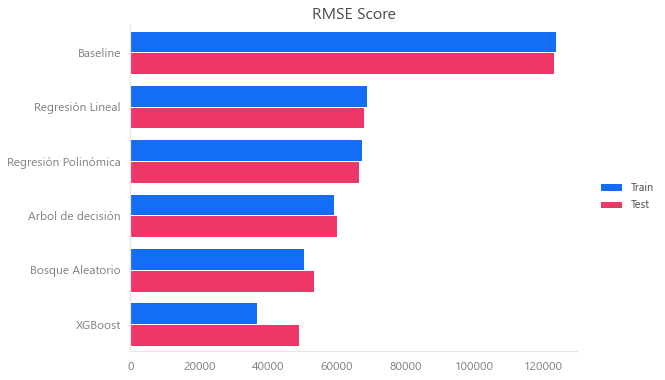

In [199]:
# Graficamos
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Score', 
                 y='Modelo',
                 hue='Set',
                 data=resultados,
                 palette=Palette, 
                 orient='h', 
                 saturation=1)
ax.set_title('RMSE Score')
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(frameon=False, bbox_to_anchor=(1.03, 0.55), loc='upper left')

Podemos hallar el error promedio en terminos porcentuales, pero lo haremos solo para nuestros dos mejores modelos.

In [200]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [201]:
mape_forest = mean_absolute_percentage_error(y_test, y_test_pred_forest)
mape_xgb = mean_absolute_percentage_error(y_test, y_test_pred_xgb)

print('MAPE para el set de prueba:')
print('‣ Random Forest - {:.1f}%'.format(mape_forest))
print('‣ XGBoost - {:.1f}%'.format(mape_xgb))

MAPE para el set de prueba:
‣ Random Forest - 19.4%
‣ XGBoost - 16.8%


Comparemos graficamente estos dos modelos

1. Bosque aleatorio

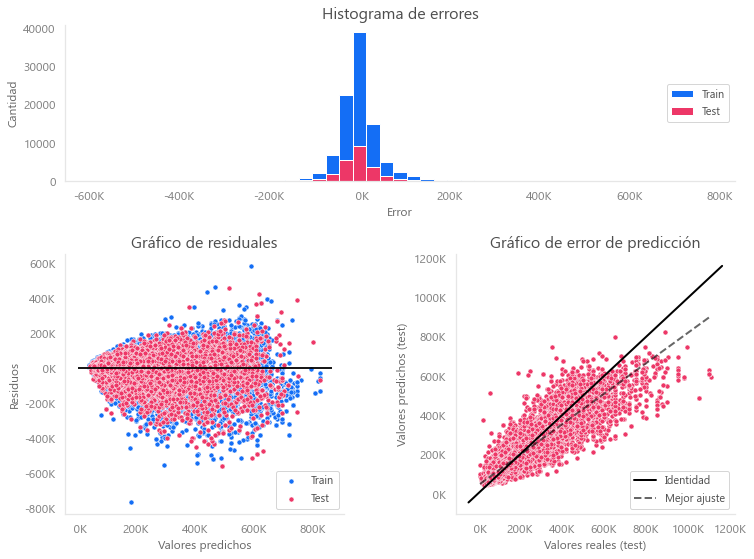

In [202]:
evaluar_modelo(y_train, y_train_pred_forest, y_test, y_test_pred_forest)

2. XGBoost

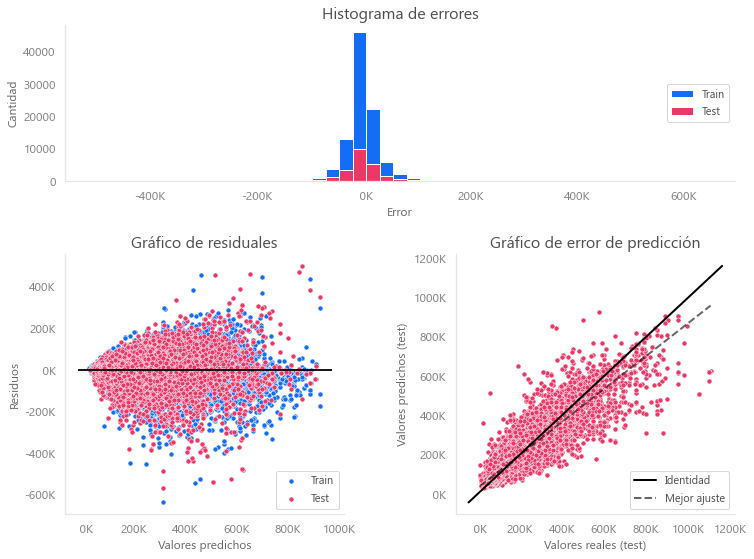

In [203]:
evaluar_modelo(y_train, y_train_pred_xgb, y_test, y_test_pred_xgb)

Durante todo la parte de modelado nos dimos cuenta que los modelos a menudo subvaloraban las propiedades. era notorio en el histograma, por ejemplo, porque tendían a tener una asimetría positiva. Pero también se notaban en los diagramas de dispersión: en el gráfico de residuales se notaba un diferencia considerable entre la parte superior (sobrevaloradas) y la inferior(subvaloradas), mientras que en el grafico de errrores de predicción la línea de regresión que mejor se ajustaba a los puntos se alejaba de la identidad porque los valores predichos tedían a ser más pequeños que los valores reales.

Podemos plantear hipotesis con respecto a porque los modelos tienen tal comportamiento. Quizá los atributos que nos permiten saber si una casa es costosa no se encuentran en los datos observados por el modelo, estos pueden ser (pero no limitados a):
1. Correspondientes al entorno:
    - Zonas de interés cercanas
    - Estrato de la zona
    - Seguridad de la zona
    - Accesibilidad
    - Fiabilidad de los servicios publicos
  
    
2. Correspondientes a la propiedad:
    - Antigüedad de la propiedad
    - Número de pisos 
    - Si está o no dentro de un condominio
    - Calidad de los materiales de construcción

No todas estás variables pueden ser facilmente cuantificadas sino que dependen del criterio humano. Sin embargo, con solo añadir algunas de ellas el modelo deberías ser capaz de generar mejores resultados. En definitiva, nos quedaremos con el modelo generado con XGBoost, porque si bien el overfit es mucho mayor que en los demás modelos, los errores se acercan mucho más al ideal con los datos con los que contamos. 

## 5.2 Importancia de atributos

### 5.2.1 Regresión lineal

Extraemos lo nombres de las columnas

In [204]:
def put_labels_2(X, text_format='{:.1%}', fontsize=12):
    padding = max(X) * 0.01
    for i, val in enumerate(X):
        ax.text(x=X[i]-padding,
                y=i,
                s= text_format.format(X[i]),
                va='center',
                ha='right',
                color='0.6',
                weight='bold',
                fontsize=fontsize)

In [205]:
numerical_columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
categorical_columns = ['l2', 'property_type', 'class']

poly_names = (pipeline_lasso_3.named_steps['columntransformer']
                              .named_transformers_['polynomialfeatures']
                              .get_feature_names(input_features=numerical_columns))

dummie_names = (pipeline_lasso_3.named_steps['columntransformer']
                              .named_transformers_['onehotencoder']
                              .get_feature_names(input_features=categorical_columns))

feature_names = np.concatenate([poly_names, dummie_names])

coefficients = pipeline_lasso_3.named_steps['transformedtargetregressor'].regressor_.coef_

coefs_lasso_2 = pd.DataFrame(np.abs(coefficients),
                             columns=['Coefficients'], 
                             index=feature_names)

coefs_lasso_2.sort_values(by=['Coefficients'],
                          ascending=False,
                          inplace=True)

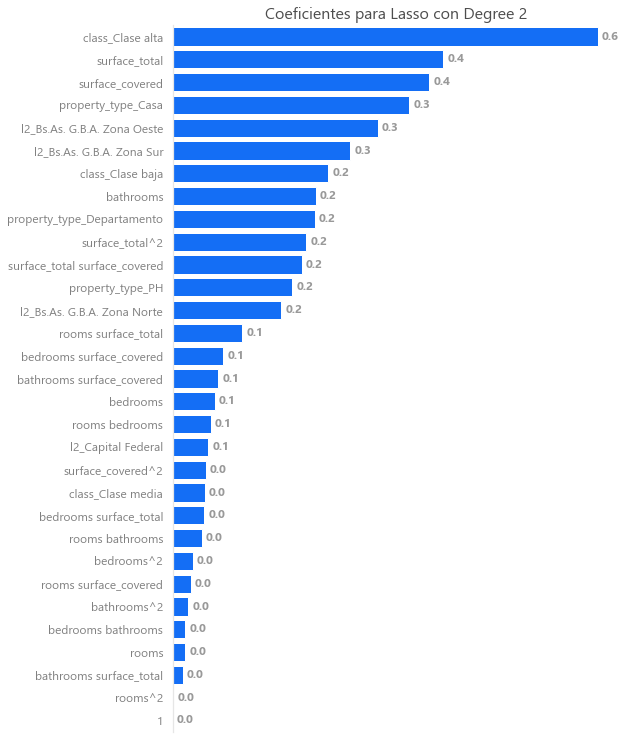

In [206]:
 plt.figure(figsize=(8, 13))
ax = sns.barplot(x=np.abs(coefs_lasso_2.Coefficients), 
                 y=coefs_lasso_2.index,
                 color=blue, 
                 orient='h', 
                 saturation=1)
ax.set_title('Coeficientes para Lasso con Degree 2')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(())
sns.despine(bottom=True)      
put_labels_2(np.abs(coefs_lasso_2.Coefficients), '{:.1f}')

Para facilitar el análisis volvimos todos los coeficientes a valores absolutos. Empecemos analizando las vaiables númericas original, luego las categoricas y finalmente los atributos polinómicos creados.
1. __Variables númericas.__ Las dos variables de superficie fueron relevantes para la regresión, al igual que el número de baños. Mientras que `rooms` y `bedrooms` no pareció tener mucha importancia, como ya habiamos concluido con el ana´silis previo de los coeficientes en el punto 4.2.


2. __Variables catgóricas.__ Aquí tenemos tres grupos: zona (l2), tipo de propiedad (property_type) y clase (class). 
    - La zona al parecer servía para explicar mucho de la propiedad, pero en concreto sí era o no de Capital Federal era lo que servía,  por esto creo que esta variable pudimos haberla convertido en booleana.
    - El tipo de propiedad también tuvo relevancia en la regresión, especialmente si era casa ya que de las tres clases esta era la que tenía un comportamiento más dispar con las otras variables. Si una propiedad era casa era más probable que el número de ambientes o habitaciones importara menos, al igual que la superficie total. De hecho lo unico que aparenteme servía para predecir los precios de la casa era la superficie total y el número de baños. Vease los heatmaps de correlación al final del punto 3.2.
    - Finalmente, la clase del barrio en que se encotraba la propiedad que era un atributo creado artifialmente a partir del costo promedio del metro cuadrado. Esta variable fue creada para remplazar el tener que introducir directamente el nombre del barrio al modelo. Pues el modelo realmente obtuvo valor de esta variables puesto la clase alta fue la que tuvo un mayor aporte, seguida por la clase baja y por ultimo la clase media. Que clase media no tengo mucha importancia tiene sentido porque es la que contiene la mayor cantidad de barrios y es por tanto la más variable. Las otras dos son los extremos y por eso dicen mucho de los precios de las propiedades de estos barrios.



3. __Variables polinómicas.__ El modelo no obtuvo gran mejora del degree 1 a los degrees 2, 3 y 4, por tanto podemos decir que precio  relamente tenía un relación mayoritariamente lineal con las demás variables y no era necesario crear atributos polinomicos. De todas las variables que se crearon solo le aportaron al modelo el cuadrado de la superficie total y el producto de la superfie total y la superficie cubierta. Aunque su aporte tampoco fue fundamental, como ya dijimos. 

### 5.2.2 Bosque aleatorio

Escribe tus interpretaciones del modelo aquí

In [207]:
dummie_names = (pipeline_bosque.named_steps['columntransformer']
                               .named_transformers_['onehotencoder']
                               .get_feature_names(input_features=categorical_columns))

feature_names = np.concatenate([numerical_columns, dummie_names])

importances = (pipeline_bosque.named_steps['randomforestregressor']
                              .feature_importances_)

feature_importances_forest = pd.DataFrame(importances,
                                          columns=['Coefficients'],
                                          index=feature_names)

feature_importances_forest.sort_values(by=['Coefficients'], 
                                       ascending=False, 
                                       inplace=True)

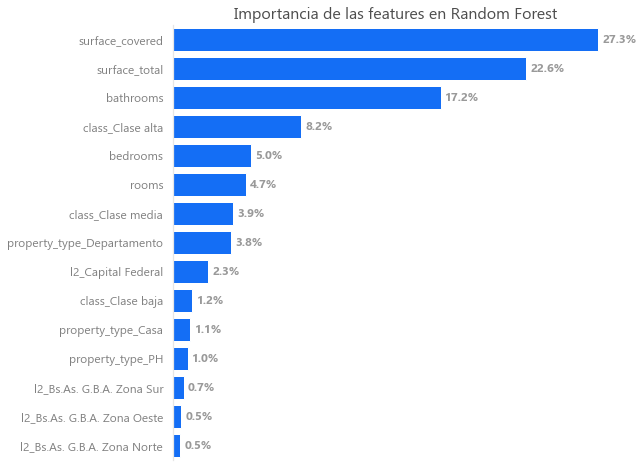

In [208]:
plt.figure(figsize=(8, 8))
ax = sns.barplot(x=feature_importances_forest.Coefficients, 
                 y=feature_importances_forest.index,
                 color=blue, 
                 orient='h', 
                 saturation=1)
ax.set_title('Importancia de las features en Random Forest')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(())
sns.despine(bottom=True)      
put_labels_2(feature_importances_forest.Coefficients)

### 5.2.3 XGBoost

In [209]:
feature_important = xgb_best_model.get_score(importance_type='total_gain')

feature_names = list(feature_important.keys())
importances = list(feature_important.values())

feature_importances_xgb = pd.DataFrame(importances,
                                       columns=['Score'],
                                       index=feature_names)

feature_importances_xgb.sort_values(by=['Score'], 
                                       ascending=False, 
                                       inplace=True)

feature_importances_xgb.Score = (feature_importances_xgb.Score/
                                 feature_importances_xgb.Score.sum())

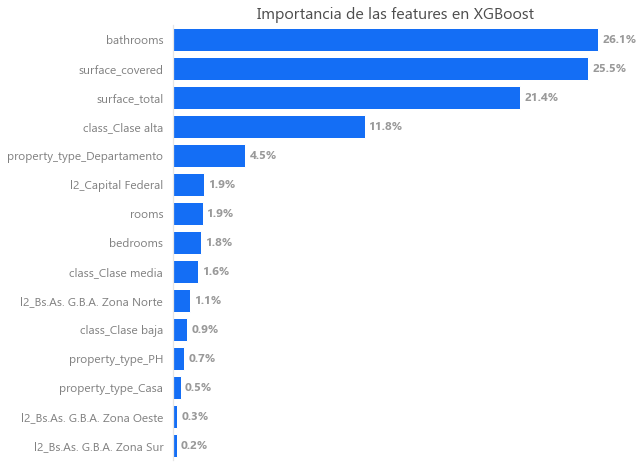

In [210]:
plt.figure(figsize=(8, 8))
ax = sns.barplot(x=feature_importances_xgb.Score, 
                 y=feature_importances_xgb.index,
                 color=blue, 
                 orient='h', 
                 saturation=1)

ax.set_title('Importancia de las features en XGBoost')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(())
sns.despine(bottom=True)      
put_labels_2(feature_importances_xgb.Score)

Para los dos modelos que funcionan con ensamble de arboles como son Random Forest y XGBoost los resultados de las importancias fueron muy parecidos.
- Ambos modelos tuvieron las mismas cuatro variables con el mayor score: `bathrooms`, `surface_covered`, `surface_total` y `class_Alta`
- Le dieron poca importancia a las variables de las zonas (l2). Con esto confirmamos que quizá sería necesario volver l2 una variable dicotómica que nos diga si la porpiedad pertenece o no Capital Federal.
- La importancia `rooms` y `bedrooms` fue medio-baja en los dos modelos, porque como dijimos, mucha de la información contenida en estas dos variables se puede obtener en la superficie total y cubierta.
- En cuanto al resto de clases (media y baja) no les dieron mucha importancia a diferencia de la regresión con Lasso.

<a id="06"></a>
# 6. Conclusiones y Próximos Pasos

En el proyecto de estudiaron con deteneimiento las variables predictoras y sus relaciones con la variable objetivo. Basado en el análisis exploratorio encontramos que las varaibles que mejor predicen el precio de un propiedad son la superficie_cubierta y el número de baños. Se alcanzó un error promedio de 49k USD con el mejor modelo, lo que equivale al 16,8% de error promedio.

Para mejorar el desempeño del modelo podrían tomarse los siguientes pasos (ordenados por complejidad ascendente):
1. Solo trabajar con los datos de una ciudad al entrenar un modelo, esto recude la variabilidad y por ello disminuye el error
2. Añadir la variable barrio en el entrenamiento (esto aumentará el costo computacional pero puede generar una ganancia no espectacular pero considerable)
3. Crear un modelo por tipo de propiedad: uno para departamentos y otro para casas, porque si bien ambas son propiedades habitables estas tienen comportamientos muy diferentes. De esta forma se pueden focalizar acciones para disminuir el error de manera independiente. 
4. Complementar el dataset con datos más específicos del entorno de la propiedad, como puede ser el índice de crímenes por zona, el estrato socioeconómico, el número de comercios a la redonda, entre otros. 
5. Trabajar con los datos de geolocalización combinado con una API de mapas para obtener el número de comercios y zonas de interes a la redonda de manera automática, así como precios de casas de viviendas cercanas. 